In [1]:
import pandas as pd
import numpy as np

import math
import os

# # Make TensorFlow logs less verbose
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf

import flwr as fl
import tensorflow_probability as tfp

import keras
from sklearn.model_selection import train_test_split
from utils import model as mod
from flwr.common import NDArrays, Scalar
from scipy.stats import pearsonr
from typing import Dict, Optional, Tuple, List, Union
import typing
import random
import json
import torch
np.random.seed(2048)
tf.random.set_seed(2048)
random.seed(2048)
tf.keras.utils.set_random_seed(2048)



NUM_EPOCHS=10
BATCH_SIZE=16
strat='FedOptAdam'
path='resultsbn'

2023-09-27 21:51:16.497961: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 21:51:16.500421: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 21:51:16.549867: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-27 21:51:16.552575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 21:51:18.532154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
!pwd

/rds/user/sc2427/hpc-work/Final/FL


In [3]:
data=pd.read_csv("all_data.csv")

In [4]:
df = pd.DataFrame(columns = data.columns)


In [5]:

dfs_to_concat = []

for i in range(250, 1000):
    mean_data = data.loc[data['Stamp'] == i].mean()
    dfs_to_concat.append(mean_data)

result_df = pd.concat(dfs_to_concat, axis=1).T.reset_index(drop=True)

In [6]:
data_new=result_df

In [7]:
data_new.shape

(750, 38)

In [8]:
y_labels=df.columns[-8:]

In [9]:
x_labels=df.columns[1:-8]

In [10]:
x=np.array(data_new[x_labels])

In [11]:
y=np.array(data_new[y_labels])

In [12]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1)

In [13]:
x_train.shape

(562, 29)

In [14]:
# y_train=y_train.reshape((1,y_train.shape[0],y_train.shape[1]))
y_train.shape

(562, 8)

In [15]:

model_eval = mod()
model_eval.compile(keras.optimizers.Adam(0.01), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError() ])

2023-09-27 21:51:27.785005: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [16]:
def pcc(y_val, y_pred):
  temp={}
  for i in range(len(y_labels)):
    temp[y_labels[i]]=(pearsonr(y_val[:,i],y_pred[:,i])[0])
  return sum(list(temp.values()))/len(list(temp.values()))

In [17]:
class FlowerClient(fl.client.NumPyClient):

    def __init__(self, model,cid, x_train, y_train, x_val, y_val, path) -> None:
        self.model = model
        self.cid=cid
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val
        self.path=path

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # loss, acc = self.model.evaluate(self.x_val, self.y_val, verbose=2)
        # loss, rmse = model.evaluate(self.x_val, self.y_val)
        loss,rmse=self.model.evaluate(self.x_val, self.y_val)

        # result["pr"].append(pr)


        try:
          data=pd.read_csv(f"{self.path}/result_{self.cid}.csv")
          data.drop(["Unnamed: 0"], axis=1, inplace=True)

        except:
          data=pd.DataFrame(columns=["round","Loss", "RMSE"])

        data=pd.concat([data,pd.Series([config['server_round'], loss, rmse ] , index=data.columns ).to_frame().T])
        data.to_csv(f"{self.path}/result_{self.cid}.csv")

        return loss, len(self.x_val), {"accuracy": rmse}


In [18]:

#import pearsonr
def get_eval_fn(model, result,result_train):
    """Return an evaluation function for server-side evaluation."""

    # Load data and model here to avoid the overhead of doing it in `evaluate` itself


    # The `evaluate` function will be called after every round
    def evaluate(server_round: int, weights: fl.common.NDArrays, config: Dict[str, Scalar]) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        model.set_weights(weights)  # Update model with the latest parameters
        loss, rmse = model.evaluate(x_test, y_test)
        loss_train,rmse_train=model.evaluate(x_train, y_train)
        result_train['Losses'].append(loss_train)
        result_train['rmse'].append(rmse_train)

        result["Losses"].append(loss)
        result["rmse"].append(rmse)
        # result["pr"].append(pr)
        for i in range(len(y_labels)):
          result["pearson"][y_labels[i]].append(pearsonr(y_test[:,i],model.predict(x_test)[:,i])[0])
          result_train['pearson'][y_labels[i]].append(pearsonr(y_train[:,i],model.predict(x_train)[:,i])[0])


        return loss, {"accuracy": rmse}

    return evaluate

In [19]:
model_eval.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 batch_normalization (Batch  (None, 16)                64        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_1 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
Total params: 1016 (3.97 KB)
Trainable params: 952 (3.72

In [20]:
def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
    }
    return config

def evaluate_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
    }
    return config

In [21]:
ray_init_args = {
            "num_gpus": 0,
            "num_cpus": 1
        }
client_res={"num_gpus": 0, "num_cpus": 1}

In [22]:
EXCLUDE_LIST=[]


In [23]:
def get_parameters(net, EXCLUDE_LIST) -> List[np.ndarray]:
        parameters = []
        for layer in net.layers:
            # print(f"  [layer {i}] {name}, {type(tensor)}, {tensor.shape}, {tensor.dtype}")

            # Check if this tensor should be included or not
            exclude = False
            for forbidden_ending in EXCLUDE_LIST:
                if forbidden_ending in name:
                    exclude = True
            if exclude:
                continue

            # Convert torch.Tensor to NumPy.ndarray
            parameters.append(np.array(layer.get_weights()))

        return parameters

In [24]:
# Create a custom FedOptAdam strategy
class FedOptAdamStrategy(fl.server.strategy.FedAvg):

    def aggregate(self, reports):
        # Extract model parameters from reports
        parameters = [report.parameters for report in reports]

        # Initialize aggregated model parameters
        aggregated_parameters = [torch.zeros_like(param) for param in parameters[0]]

        # Perform FedOptAdam aggregation
        for param_group in zip(*parameters):
            # Compute the mean of the parameters in the group
            mean_param = torch.mean(torch.stack(param_group), dim=0)

            # Update the aggregated parameters with FedOptAdam logic
            for i, param in enumerate(param_group):
                alpha = 0.1  # Adjust the learning rate if needed
                aggregated_parameters[i] += alpha * (param - mean_param)

        # Compute the final aggregated model parameters
        aggregated_parameters = [param / len(reports) for param in aggregated_parameters]

        return aggregated_parameters


In [25]:
inital=mod()
#for clients from 2 to 10, run the strategy for 10 rounds each and create a list of results
results=[]
results_train=[]
# for i in range(5):
for i in range(2,11):
    try:
        os.mkdir(f"{path}/{i}")
    except:
        print()
    try:
        os.mkdir(f"{path}/{i}/{strat}")
    except:
        print()
    
    NUM_CLIENTS = i
    # losses=[]
    def client_fn(cid: str) -> fl.client.Client:
        # Create model
        model = mod()
        model.compile(keras.optimizers.Adam(0.01), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError()])    
        partition_size = math.floor(len(x_train) / NUM_CLIENTS)
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        full_x_train_cid = x_train[idx_from:idx_to]
        full_y_train_cid = y_train[idx_from:idx_to]
    
    
        partition_size = math.floor(len(x_test) / NUM_CLIENTS)
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        full_x_test_cid = x_test[idx_from:idx_to]
        full_y_test_cid = y_test[idx_from:idx_to]
    
        # Create and return client
        return FlowerClient(model,cid, full_x_train_cid, full_y_train_cid, full_x_test_cid, full_y_test_cid, f"{path}/{i}/{strat}")


    
    
    result={ 'clients':i  , 'Losses':[], "rmse":[], 'pearson':{y_labels[i]:[] for i in range(len(y_labels))}}
    
    result_train={ 'clients':i  , 'Losses':[], "rmse":[], 'pearson':{y_labels[i]:[] for i in range(len(y_labels))}}
    
    try:
        del strategy
    except:
        print('starting')
    # Create FedAvg strategy
    strategy =FedOptAdamStrategy(
      min_fit_clients=i,  # Never sample less than 10 clients for training
      evaluate_fn=get_eval_fn(model_eval, result,result_train),
      on_fit_config_fn=fit_config,
      on_evaluate_config_fn=evaluate_config,
      initial_parameters=fl.common.ndarrays_to_parameters(inital.get_weights()),
    )
    
    # Start simulation
    fl.simulation.start_simulation(
      client_fn=client_fn,
      num_clients=NUM_CLIENTS,
      config=fl.server.ServerConfig(num_rounds=10),
      strategy=strategy,
      ray_init_args=ray_init_args,
      client_resources=client_res,
    )
    results.append(result)
    results_train.append(result_train)
    # print(result)
    # try:
    #     data=pd.read_csv(f"{path}/combine_random{result['clients']}.csv")
    #     data.drop(["Unnamed: 0"], axis=1, inplace=True)
        
    # except:
    #     data=pd.DataFrame(columns=["Method", "Loss_Task1", "RMSE_Task1"])
    # data=pd.concat([data,pd.Series(["FedAvgEWC_Aug", result['Losses'][-1],result['rmse'][-1]] , index=data.columns ).to_frame().T])
    # data.to_csv(f"{path}/combine_random{result['clients']}.csv")



INFO flwr 2023-09-27 21:51:28,198 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)



starting


2023-09-27 21:51:31,914	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 21:51:32,091	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 21:51:33,450 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.41': 1.0,

18/18 [==============================] - 0s 902us/step


INFO flwr 2023-09-27 21:51:35,690 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 21:51:35,690 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 21:51:35,691 | server.py:218 | fit_round 1: strategy sampled 2 clients (out of 2)
(pid=18999) 2023-09-27 21:51:36.390860: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=18999) 2023-09-27 21:51:36.392968: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=18999) 2023-09-27 21:51:36.445793: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=18999) 2023-09-27 21:51:36.446335: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=18999) Epoch 1/10
18/18 [==============================] - 1s 3ms/step - loss: 8.5964 - root_mean_squared_error: 2.9320
(launch_and_fit pid=18999) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 3.9288 - root_mean_squared_error: 1.9821
(launch_and_fit pid=18999) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.4936 - root_mean_squared_error: 0.7026
(launch_and_fit pid=18999) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.3263 - root_mean_squared_error: 0.5712
(launch_and_fit pid=18999) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2733 - root_mean_squared_error: 0.5228
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2347 - root_mean_squared_error: 0.4845
(launch_and_fit pid=18999) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2431 - root_mean_squared_error: 0.4931
(launch_and_fit pid=

DEBUG flwr 2023-09-27 21:51:44,640 | server.py:232 | fit_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-27 21:51:44,656 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


18/18 [==============================] - 0s 2ms/step - loss: 0.3128 - root_mean_squared_error: 0.5592
(launch_and_fit pid=18999) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2522 - root_mean_squared_error: 0.5022
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2467 - root_mean_squared_error: 0.4967
(launch_and_fit pid=18999) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2339 - root_mean_squared_error: 0.4836
(launch_and_fit pid=18999) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2269 - root_mean_squared_error: 0.4764
(launch_and_fit pid=18999) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2303 - root_mean_squared_error: 0.4799
(launch_and_fit pid=18999) Epoch 10/10
18/18 [==============================] - 0s 955us/step


INFO flwr 2023-09-27 21:51:46,148 | server.py:119 | fit progress: (1, 0.23246178030967712, {'accuracy': 0.4821428954601288}, 10.457138082943857)
DEBUG flwr 2023-09-27 21:51:46,149 | server.py:168 | evaluate_round 1: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 3ms/step - loss: 0.2313 - root_mean_squared_error: 0.4810


DEBUG flwr 2023-09-27 21:51:46,822 | server.py:182 | evaluate_round 1 received 2 results and 0 failures
WARNING flwr 2023-09-27 21:51:46,824 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 21:51:46,825 | server.py:218 | fit_round 2: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2336 - root_mean_squared_error: 0.4833
(launch_and_fit pid=18999) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2677 - root_mean_squared_error: 0.5174
(launch_and_fit pid=18999) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2396 - root_mean_squared_error: 0.4895
(launch_and_fit pid=18999) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2391 - root_mean_squared_error: 0.4890
(launch_and_fit pid=18999) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2323 - root_mean_squared_error: 0.4819
(launch_and_fit pid=18999) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2238 - root_mean_squared_error: 0.4731
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2316 - root_mean_squared_error: 0.4813
(launch_and_fit pid=18999) Epoch 7/10
18/18 [===============

DEBUG flwr 2023-09-27 21:51:50,049 | server.py:232 | fit_round 2 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2449 - root_mean_squared_error: 0.4948
(launch_and_fit pid=18999) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2373 - root_mean_squared_error: 0.4872
(launch_and_fit pid=18999) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2378 - root_mean_squared_error: 0.4876
(launch_and_fit pid=18999) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2350 - root_mean_squared_error: 0.4847
(launch_and_fit pid=18999) Epoch 10/10
18/18 [==============================] - 0s 2ms/step


INFO flwr 2023-09-27 21:51:51,510 | server.py:119 | fit progress: (2, 0.254096120595932, {'accuracy': 0.5040794610977173}, 15.819024541880935)
DEBUG flwr 2023-09-27 21:51:51,512 | server.py:168 | evaluate_round 2: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2597 - root_mean_squared_error: 0.5096


DEBUG flwr 2023-09-27 21:51:52,134 | server.py:182 | evaluate_round 2 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:51:52,136 | server.py:218 | fit_round 3: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2485 - root_mean_squared_error: 0.4985
(launch_and_fit pid=18999) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2548 - root_mean_squared_error: 0.5048
(launch_and_fit pid=18999) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2465 - root_mean_squared_error: 0.4964
(launch_and_fit pid=18999) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2331 - root_mean_squared_error: 0.4828
(launch_and_fit pid=18999) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2397 - root_mean_squared_error: 0.4896
(launch_and_fit pid=18999) Epoch 5/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2313 - root_mean_squared_error: 0.4809
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2308 - root_mean_squared_error: 0.4804
(launch_and_fit pid=18999) Epoch 7/10
18/18 [===============

DEBUG flwr 2023-09-27 21:51:55,040 | server.py:232 | fit_round 3 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2167 - root_mean_squared_error: 0.4655
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2166 - root_mean_squared_error: 0.4654
(launch_and_fit pid=18999) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2332 - root_mean_squared_error: 0.4829
(launch_and_fit pid=18999) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2169 - root_mean_squared_error: 0.4657
(launch_and_fit pid=18999) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2163 - root_mean_squared_error: 0.4650
(launch_and_fit pid=18999) Epoch 10/10
18/18 [==============================] - 0s 2ms/step


INFO flwr 2023-09-27 21:51:56,540 | server.py:119 | fit progress: (3, 0.2203502655029297, {'accuracy': 0.4694148004055023}, 20.849009342957288)
DEBUG flwr 2023-09-27 21:51:56,542 | server.py:168 | evaluate_round 3: strategy sampled 2 clients (out of 2)
(launch_and_evaluate pid=18999) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x2b648bfdaaf0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 [==============================] - 0s 2ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703


DEBUG flwr 2023-09-27 21:51:57,236 | server.py:182 | evaluate_round 3 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:51:57,238 | server.py:218 | fit_round 4: strategy sampled 2 clients (out of 2)
(launch_and_evaluate pid=18999) WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x2b659f10b670> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 [==============================] - 0s 2ms/step - loss: 0.2195 - root_mean_squared_error: 0.4685
(launch_and_fit pid=18999) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2492 - root_mean_squared_error: 0.4992
(launch_and_fit pid=18999) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2313 - root_mean_squared_error: 0.4809
(launch_and_fit pid=18999) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2409 - root_mean_squared_error: 0.4909
(launch_and_fit pid=18999) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2286 - root_mean_squared_error: 0.4781
(launch_and_fit pid=18999) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2167 - root_mean_squared_error: 0.4655
(launch_and_fit pid=18999) Epoch 7/10
18/18 [===============

DEBUG flwr 2023-09-27 21:52:00,216 | server.py:232 | fit_round 4 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2307 - root_mean_squared_error: 0.4803
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2486 - root_mean_squared_error: 0.4986
(launch_and_fit pid=18999) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2130 - root_mean_squared_error: 0.4615
(launch_and_fit pid=18999) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2171 - root_mean_squared_error: 0.4659
(launch_and_fit pid=18999) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2179 - root_mean_squared_error: 0.4668
(launch_and_fit pid=18999) Epoch 10/10
18/18 [==============================] - 0s 906us/step


INFO flwr 2023-09-27 21:52:01,490 | server.py:119 | fit progress: (4, 0.22120210528373718, {'accuracy': 0.47032126784324646}, 25.799245254602283)
DEBUG flwr 2023-09-27 21:52:01,491 | server.py:168 | evaluate_round 4: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 5ms/step - loss: 0.2183 - root_mean_squared_error: 0.4673


DEBUG flwr 2023-09-27 21:52:02,151 | server.py:182 | evaluate_round 4 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:52:02,153 | server.py:218 | fit_round 5: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2241 - root_mean_squared_error: 0.4733
(launch_and_fit pid=18999) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2517 - root_mean_squared_error: 0.5017
(launch_and_fit pid=18999) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2165 - root_mean_squared_error: 0.4653
(launch_and_fit pid=18999) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2308 - root_mean_squared_error: 0.4804
(launch_and_fit pid=18999) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2311 - root_mean_squared_error: 0.4808
(launch_and_fit pid=18999) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2252 - root_mean_squared_error: 0.4745
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2035 - root_mean_squared_error: 0.4511
(launch_and_fit pid=18999) Epoch 7/10
18/18 [===============

DEBUG flwr 2023-09-27 21:52:04,860 | server.py:232 | fit_round 5 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2214 - root_mean_squared_error: 0.4706
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2299 - root_mean_squared_error: 0.4795
(launch_and_fit pid=18999) Epoch 7/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2133 - root_mean_squared_error: 0.4618
(launch_and_fit pid=18999) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2317 - root_mean_squared_error: 0.4814
(launch_and_fit pid=18999) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2220 - root_mean_squared_error: 0.4711
(launch_and_fit pid=18999) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:52:06,533 | server.py:119 | fit progress: (5, 0.23214687407016754, {'accuracy': 0.48181623220443726}, 30.841944762971252)
DEBUG flwr 2023-09-27 21:52:06,534 | server.py:168 | evaluate_round 5: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2413 - root_mean_squared_error: 0.4912


DEBUG flwr 2023-09-27 21:52:07,273 | server.py:182 | evaluate_round 5 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:52:07,275 | server.py:218 | fit_round 6: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 3ms/step - loss: 0.2230 - root_mean_squared_error: 0.4722
(launch_and_fit pid=18999) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2377 - root_mean_squared_error: 0.4876
(launch_and_fit pid=18999) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2132 - root_mean_squared_error: 0.4617
(launch_and_fit pid=18999) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2148 - root_mean_squared_error: 0.4635
(launch_and_fit pid=18999) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2210 - root_mean_squared_error: 0.4701
(launch_and_fit pid=18999) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2173 - root_mean_squared_error: 0.4662
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2212 - root_mean_squared_error: 0.4704
(launch_and_fit pid=18999) Epoch 7/10
18/18 [===============

DEBUG flwr 2023-09-27 21:52:10,435 | server.py:232 | fit_round 6 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2222 - root_mean_squared_error: 0.4714
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2246 - root_mean_squared_error: 0.4739
(launch_and_fit pid=18999) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2113 - root_mean_squared_error: 0.4597
(launch_and_fit pid=18999) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2260 - root_mean_squared_error: 0.4754
(launch_and_fit pid=18999) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2417 - root_mean_squared_error: 0.4916
(launch_and_fit pid=18999) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:52:12,081 | server.py:119 | fit progress: (6, 0.2190476506948471, {'accuracy': 0.468025267124176}, 36.38990722596645)
DEBUG flwr 2023-09-27 21:52:12,082 | server.py:168 | evaluate_round 6: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-09-27 21:52:12,658 | server.py:182 | evaluate_round 6 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:52:12,660 | server.py:218 | fit_round 7: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2201 - root_mean_squared_error: 0.4691
(launch_and_fit pid=18999) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2396 - root_mean_squared_error: 0.4895
(launch_and_fit pid=18999) Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703
(launch_and_fit pid=18999) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2339 - root_mean_squared_error: 0.4837
(launch_and_fit pid=18999) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2254 - root_mean_squared_error: 0.4748
(launch_and_fit pid=18999) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2137 - root_mean_squared_error: 0.4623
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2180 - root_mean_squared_error: 0.4669
(launch_and_fit pid=18999) Epoch 7/10
18/18 [===============

DEBUG flwr 2023-09-27 21:52:15,395 | server.py:232 | fit_round 7 received 2 results and 0 failures


18/18 [==============================] - 0s 3ms/step - loss: 0.2166 - root_mean_squared_error: 0.4654
(launch_and_fit pid=18999) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2204 - root_mean_squared_error: 0.4695
(launch_and_fit pid=18999) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2119 - root_mean_squared_error: 0.4603
(launch_and_fit pid=18999) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2148 - root_mean_squared_error: 0.4635
(launch_and_fit pid=18999) Epoch 10/10
18/18 [==============================] - 0s 950us/step


INFO flwr 2023-09-27 21:52:16,836 | server.py:119 | fit progress: (7, 0.21877312660217285, {'accuracy': 0.46773192286491394}, 41.14545569801703)
DEBUG flwr 2023-09-27 21:52:16,838 | server.py:168 | evaluate_round 7: strategy sampled 2 clients (out of 2)
DEBUG flwr 2023-09-27 21:52:17,337 | server.py:182 | evaluate_round 7 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:52:17,339 | server.py:218 | fit_round 8: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2168 - root_mean_squared_error: 0.4656
(launch_and_fit pid=18999) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2388 - root_mean_squared_error: 0.4886
(launch_and_fit pid=18999) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2384 - root_mean_squared_error: 0.4882
(launch_and_fit pid=18999) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2213 - root_mean_squared_error: 0.4704
(launch_and_fit pid=18999) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2077 - root_mean_squared_error: 0.4558
(launch_and_fit pid=18999) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2218 - root_mean_squared_error: 0.4710
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2317 - root_mean_squared_error: 0.4814
(launch_and_fit pid=18999) Epoch 7/10
18/18 [===============

DEBUG flwr 2023-09-27 21:52:20,358 | server.py:232 | fit_round 8 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2132 - root_mean_squared_error: 0.4617
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2129 - root_mean_squared_error: 0.4615
(launch_and_fit pid=18999) Epoch 7/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2219 - root_mean_squared_error: 0.4711
(launch_and_fit pid=18999) Epoch 8/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2255 - root_mean_squared_error: 0.4749
(launch_and_fit pid=18999) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2275 - root_mean_squared_error: 0.4770
(launch_and_fit pid=18999) Epoch 10/10
18/18 [==============================] - 0s 876us/step


INFO flwr 2023-09-27 21:52:21,928 | server.py:119 | fit progress: (8, 0.21746641397476196, {'accuracy': 0.46633297204971313}, 46.23701788298786)
DEBUG flwr 2023-09-27 21:52:21,929 | server.py:168 | evaluate_round 8: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2145 - root_mean_squared_error: 0.4632


DEBUG flwr 2023-09-27 21:52:22,439 | server.py:182 | evaluate_round 8 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:52:22,441 | server.py:218 | fit_round 9: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2204 - root_mean_squared_error: 0.4695
(launch_and_fit pid=18999) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2465 - root_mean_squared_error: 0.4965
(launch_and_fit pid=18999) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2481 - root_mean_squared_error: 0.4981
(launch_and_fit pid=18999) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2217 - root_mean_squared_error: 0.4708
(launch_and_fit pid=18999) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2234 - root_mean_squared_error: 0.4726
(launch_and_fit pid=18999) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2297 - root_mean_squared_error: 0.4792
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2146 - root_mean_squared_error: 0.4633
(launch_and_fit pid=18999) Epoch 7/10
18/18 [===============

DEBUG flwr 2023-09-27 21:52:25,571 | server.py:232 | fit_round 9 received 2 results and 0 failures


18/18 [==============================] - 0s 1ms/step - loss: 0.2293 - root_mean_squared_error: 0.4788
(launch_and_fit pid=18999) Epoch 7/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2001 - root_mean_squared_error: 0.4474
(launch_and_fit pid=18999) Epoch 8/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2097 - root_mean_squared_error: 0.4579
(launch_and_fit pid=18999) Epoch 9/10
18/18 [==============================] - 0s 1ms/step - loss: 0.2045 - root_mean_squared_error: 0.4522
(launch_and_fit pid=18999) Epoch 10/10
18/18 [==============================] - 0s 911us/step


INFO flwr 2023-09-27 21:52:26,979 | server.py:119 | fit progress: (9, 0.21891175210475922, {'accuracy': 0.4678800702095032}, 51.28783818567172)
DEBUG flwr 2023-09-27 21:52:26,980 | server.py:168 | evaluate_round 9: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 3ms/step - loss: 0.2113 - root_mean_squared_error: 0.4597


DEBUG flwr 2023-09-27 21:52:27,597 | server.py:182 | evaluate_round 9 received 2 results and 0 failures
DEBUG flwr 2023-09-27 21:52:27,598 | server.py:218 | fit_round 10: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2265 - root_mean_squared_error: 0.4759
(launch_and_fit pid=18999) Epoch 1/10
18/18 [==============================] - 1s 2ms/step - loss: 0.2147 - root_mean_squared_error: 0.4634
(launch_and_fit pid=18999) Epoch 2/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2239 - root_mean_squared_error: 0.4731
(launch_and_fit pid=18999) Epoch 3/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2060 - root_mean_squared_error: 0.4539
(launch_and_fit pid=18999) Epoch 4/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501
(launch_and_fit pid=18999) Epoch 5/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2133 - root_mean_squared_error: 0.4618
(launch_and_fit pid=18999) Epoch 6/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2095 - root_mean_squared_error: 0.4577
(launch_and_fit pid=18999) Epoch 7/10
18/18 [===============

DEBUG flwr 2023-09-27 21:52:30,942 | server.py:232 | fit_round 10 received 2 results and 0 failures


18/18 [==============================] - 0s 2ms/step - loss: 0.2171 - root_mean_squared_error: 0.4660
(launch_and_fit pid=18999) Epoch 9/10
18/18 [==============================] - 0s 2ms/step - loss: 0.2154 - root_mean_squared_error: 0.4641
(launch_and_fit pid=18999) Epoch 10/10
18/18 [==============================] - 0s 875us/step


INFO flwr 2023-09-27 21:52:32,335 | server.py:119 | fit progress: (10, 0.22272440791130066, {'accuracy': 0.4719368815422058}, 56.64376936480403)
DEBUG flwr 2023-09-27 21:52:32,336 | server.py:168 | evaluate_round 10: strategy sampled 2 clients (out of 2)


3/3 [==============================] - 0s 2ms/step - loss: 0.2158 - root_mean_squared_error: 0.4646


DEBUG flwr 2023-09-27 21:52:32,874 | server.py:182 | evaluate_round 10 received 2 results and 0 failures
INFO flwr 2023-09-27 21:52:32,876 | server.py:147 | FL finished in 57.184558239765465
INFO flwr 2023-09-27 21:52:32,879 | app.py:218 | app_fit: losses_distributed [(1, 0.23246178776025772), (2, 0.2540960982441902), (3, 0.2203502655029297), (4, 0.22120209783315659), (5, 0.23214685916900635), (6, 0.2190476432442665), (7, 0.21877314895391464), (8, 0.21746642887592316), (9, 0.2189117595553398), (10, 0.22272440791130066)]
INFO flwr 2023-09-27 21:52:32,881 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 21:52:32,882 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 21:52:32,884 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.23246178030967712), (2, 0.254096120595932), (3, 0.2203502655029297), (4, 0.22120210528373718), (5, 0.23214687407016754), (6, 0.2190476506948471), (7, 0.21877312660217285), (8, 0.21746641397476196), (

1/3 [=========>....................] - ETA: 0s - loss: 0.1777 - root_mean_squared_error: 0.4216



2023-09-27 21:52:39,209	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 21:52:39,327	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 21:52:40,636 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

18/18 [==============================] - 0s 964us/step


INFO flwr 2023-09-27 21:52:42,141 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 21:52:42,141 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 21:52:42,142 | server.py:218 | fit_round 1: strategy sampled 3 clients (out of 3)
(pid=49534) 2023-09-27 21:52:42.996530: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=49534) 2023-09-27 21:52:42.998592: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=49534) 2023-09-27 21:52:43.050035: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=49534) 2023-09-27 21:52:43.050577: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=49534) Epoch 1/10
12/12 [==============================] - 1s 5ms/step - loss: 9.2756 - root_mean_squared_error: 3.0456
(launch_and_fit pid=49534) Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 6.5737 - root_mean_squared_error: 2.5639
(launch_and_fit pid=49534) Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 2.9381 - root_mean_squared_error: 1.7141
(launch_and_fit pid=49534) Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.4950 - root_mean_squared_error: 0.7035
(launch_and_fit pid=49534) Epoch 5/10
12/12 [==============================] - 0s 3ms/step - loss: 0.4134 - root_mean_squared_error: 0.6429
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2342 - root_mean_squared_error: 0.4839
(launch_and_fit pid=49534) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2456 - root_mean_squared_error: 0.4956
(launch_and_fit pid=

DEBUG flwr 2023-09-27 21:52:54,156 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-09-27 21:52:54,170 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


12/12 [==============================] - 0s 2ms/step - loss: 0.4350 - root_mean_squared_error: 0.6596
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2741 - root_mean_squared_error: 0.5236
(launch_and_fit pid=49534) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2597 - root_mean_squared_error: 0.5096
(launch_and_fit pid=49534) Epoch 8/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2485 - root_mean_squared_error: 0.4985
(launch_and_fit pid=49534) Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2585 - root_mean_squared_error: 0.5084
(launch_and_fit pid=49534) Epoch 10/10
18/18 [==============================] - 0s 913us/step


INFO flwr 2023-09-27 21:52:55,510 | server.py:119 | fit progress: (1, 0.23495566844940186, {'accuracy': 0.4847222566604614}, 13.368136857170612)
DEBUG flwr 2023-09-27 21:52:55,511 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2060 - root_mean_squared_error: 0.4539


DEBUG flwr 2023-09-27 21:52:56,375 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
WARNING flwr 2023-09-27 21:52:56,376 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 21:52:56,378 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2908 - root_mean_squared_error: 0.5392
(launch_and_fit pid=49534) Epoch 1/10
12/12 [==============================] - 1s 3ms/step - loss: 0.2672 - root_mean_squared_error: 0.5169
(launch_and_fit pid=49534) Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2519 - root_mean_squared_error: 0.5019
(launch_and_fit pid=49534) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2358 - root_mean_squared_error: 0.4856
(launch_and_fit pid=49534) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758
(launch_and_fit pid=49534) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2145 - root_mean_squared_error: 0.4631
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2080 - root_mean_squared_error: 0.4561
(launch_and_fit pid=49534) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 21:53:00,697 | server.py:232 | fit_round 2 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2430 - root_mean_squared_error: 0.4929
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2192 - root_mean_squared_error: 0.4682
(launch_and_fit pid=49534) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2217 - root_mean_squared_error: 0.4708
(launch_and_fit pid=49534) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2498 - root_mean_squared_error: 0.4998
(launch_and_fit pid=49534) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2517 - root_mean_squared_error: 0.5017
(launch_and_fit pid=49534) Epoch 10/10
18/18 [==============================] - 0s 983us/step


INFO flwr 2023-09-27 21:53:02,077 | server.py:119 | fit progress: (2, 0.22824499011039734, {'accuracy': 0.47774994373321533}, 19.935672791209072)
DEBUG flwr 2023-09-27 21:53:02,078 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2065 - root_mean_squared_error: 0.4545


(launch_and_evaluate pid=49534) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2ad7ebf180d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 3ms/step - loss: 0.2679 - root_mean_squared_error: 0.5176


DEBUG flwr 2023-09-27 21:53:03,043 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:53:03,044 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)
(launch_and_evaluate pid=49534) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2ad82ffdaca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 3ms/step - loss: 0.2108 - root_mean_squared_error: 0.4591
(launch_and_fit pid=49534) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2671 - root_mean_squared_error: 0.5168
(launch_and_fit pid=49534) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2418 - root_mean_squared_error: 0.4918
(launch_and_fit pid=49534) Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2357 - root_mean_squared_error: 0.4855
(launch_and_fit pid=49534) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2455 - root_mean_squared_error: 0.4955
(launch_and_fit pid=49534) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2287 - root_mean_squared_error: 0.4782
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2307 - root_mean_squared_error: 0.4803
(launch_and_fit pid=49534) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 21:53:07,300 | server.py:232 | fit_round 3 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2175 - root_mean_squared_error: 0.4664
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2157 - root_mean_squared_error: 0.4644
(launch_and_fit pid=49534) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1970 - root_mean_squared_error: 0.4438
(launch_and_fit pid=49534) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2213 - root_mean_squared_error: 0.4704
(launch_and_fit pid=49534) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2223 - root_mean_squared_error: 0.4715
(launch_and_fit pid=49534) Epoch 10/10
18/18 [==============================] - 0s 873us/step


INFO flwr 2023-09-27 21:53:08,696 | server.py:119 | fit progress: (3, 0.24584564566612244, {'accuracy': 0.4958282709121704}, 26.55410669790581)
DEBUG flwr 2023-09-27 21:53:08,697 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2217 - root_mean_squared_error: 0.4709


DEBUG flwr 2023-09-27 21:53:09,458 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:53:09,460 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2223 - root_mean_squared_error: 0.4715
(launch_and_fit pid=49534) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2574 - root_mean_squared_error: 0.5073
(launch_and_fit pid=49534) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2398 - root_mean_squared_error: 0.4897
(launch_and_fit pid=49534) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2461 - root_mean_squared_error: 0.4961
(launch_and_fit pid=49534) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2305 - root_mean_squared_error: 0.4801
(launch_and_fit pid=49534) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2292 - root_mean_squared_error: 0.4788
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2231 - root_mean_squared_error: 0.4723
(launch_and_fit pid=49534) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 21:53:13,871 | server.py:232 | fit_round 4 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.1956 - root_mean_squared_error: 0.4423
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2005 - root_mean_squared_error: 0.4478
(launch_and_fit pid=49534) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1923 - root_mean_squared_error: 0.4385
(launch_and_fit pid=49534) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1929 - root_mean_squared_error: 0.4392
(launch_and_fit pid=49534) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2058 - root_mean_squared_error: 0.4537
(launch_and_fit pid=49534) Epoch 10/10
18/18 [==============================] - 0s 828us/step


INFO flwr 2023-09-27 21:53:15,271 | server.py:119 | fit progress: (4, 0.2324678897857666, {'accuracy': 0.48214924335479736}, 33.129793758969754)
DEBUG flwr 2023-09-27 21:53:15,272 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 5ms/step - loss: 0.2725 - root_mean_squared_error: 0.5221


DEBUG flwr 2023-09-27 21:53:16,199 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:53:16,201 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 6ms/step - loss: 0.2091 - root_mean_squared_error: 0.4572
(launch_and_fit pid=49534) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2542 - root_mean_squared_error: 0.5042
(launch_and_fit pid=49534) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2084 - root_mean_squared_error: 0.4565
(launch_and_fit pid=49534) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2329 - root_mean_squared_error: 0.4825
(launch_and_fit pid=49534) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2073 - root_mean_squared_error: 0.4553
(launch_and_fit pid=49534) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2227 - root_mean_squared_error: 0.4719
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2020 - root_mean_squared_error: 0.4495
(launch_and_fit pid=49534) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 21:53:20,581 | server.py:232 | fit_round 5 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2142 - root_mean_squared_error: 0.4628
(launch_and_fit pid=49534) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2068 - root_mean_squared_error: 0.4548
(launch_and_fit pid=49534) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2380 - root_mean_squared_error: 0.4879
(launch_and_fit pid=49534) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2165 - root_mean_squared_error: 0.4653
(launch_and_fit pid=49534) Epoch 10/10
18/18 [==============================] - 0s 865us/step


INFO flwr 2023-09-27 21:53:22,061 | server.py:119 | fit progress: (5, 0.21751536428928375, {'accuracy': 0.4663854241371155}, 39.91875424887985)
DEBUG flwr 2023-09-27 21:53:22,062 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2566 - root_mean_squared_error: 0.5066


DEBUG flwr 2023-09-27 21:53:23,049 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:53:23,051 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.1960 - root_mean_squared_error: 0.4427
(launch_and_fit pid=49534) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2310 - root_mean_squared_error: 0.4806
(launch_and_fit pid=49534) Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2267 - root_mean_squared_error: 0.4762
(launch_and_fit pid=49534) Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2006 - root_mean_squared_error: 0.4478
(launch_and_fit pid=49534) Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2193 - root_mean_squared_error: 0.4683
(launch_and_fit pid=49534) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2042 - root_mean_squared_error: 0.4519
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531
(launch_and_fit pid=49534) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 21:53:27,439 | server.py:232 | fit_round 6 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2085 - root_mean_squared_error: 0.4566
(launch_and_fit pid=49534) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2028 - root_mean_squared_error: 0.4503
(launch_and_fit pid=49534) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2123 - root_mean_squared_error: 0.4608
(launch_and_fit pid=49534) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:53:28,980 | server.py:119 | fit progress: (6, 0.22200915217399597, {'accuracy': 0.47117847204208374}, 46.83793476829305)
DEBUG flwr 2023-09-27 21:53:28,981 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2007 - root_mean_squared_error: 0.4479


DEBUG flwr 2023-09-27 21:53:29,772 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:53:29,774 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2613 - root_mean_squared_error: 0.5112
(launch_and_fit pid=49534) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2574 - root_mean_squared_error: 0.5073
(launch_and_fit pid=49534) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2041 - root_mean_squared_error: 0.4517
(launch_and_fit pid=49534) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1982 - root_mean_squared_error: 0.4452
(launch_and_fit pid=49534) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2063 - root_mean_squared_error: 0.4542
(launch_and_fit pid=49534) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2051 - root_mean_squared_error: 0.4529
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2020 - root_mean_squared_error: 0.4494
(launch_and_fit pid=49534) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 21:53:33,975 | server.py:232 | fit_round 7 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2049 - root_mean_squared_error: 0.4526
(launch_and_fit pid=49534) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2023 - root_mean_squared_error: 0.4498
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2044 - root_mean_squared_error: 0.4521
(launch_and_fit pid=49534) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2225 - root_mean_squared_error: 0.4717
(launch_and_fit pid=49534) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2099 - root_mean_squared_error: 0.4582
(launch_and_fit pid=49534) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2397 - root_mean_squared_error: 0.4896
(launch_and_fit pid=49534) Epoch 10/10
18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:53:35,534 | server.py:119 | fit progress: (7, 0.2285183072090149, {'accuracy': 0.47803589701652527}, 53.39269159408286)
DEBUG flwr 2023-09-27 21:53:35,536 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 5ms/step - loss: 0.2753 - root_mean_squared_error: 0.5247


DEBUG flwr 2023-09-27 21:53:36,412 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:53:36,414 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2011 - root_mean_squared_error: 0.4484
(launch_and_fit pid=49534) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2407 - root_mean_squared_error: 0.4907
(launch_and_fit pid=49534) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2125 - root_mean_squared_error: 0.4610
(launch_and_fit pid=49534) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2420 - root_mean_squared_error: 0.4920
(launch_and_fit pid=49534) Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.2221 - root_mean_squared_error: 0.4713
(launch_and_fit pid=49534) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2062 - root_mean_squared_error: 0.4541
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2213 - root_mean_squared_error: 0.4704
(launch_and_fit pid=49534) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 21:53:40,484 | server.py:232 | fit_round 8 received 3 results and 0 failures


12/12 [==============================] - 1s 2ms/step - loss: 0.2097 - root_mean_squared_error: 0.4580
(launch_and_fit pid=49534) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2238 - root_mean_squared_error: 0.4731
(launch_and_fit pid=49534) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2136 - root_mean_squared_error: 0.4622
(launch_and_fit pid=49534) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1956 - root_mean_squared_error: 0.4423
(launch_and_fit pid=49534) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2011 - root_mean_squared_error: 0.4485
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1976 - root_mean_squared_error: 0.4445
(launch_and_fit pid=49534) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1926 - root_mean_squared_error: 0.4389
(launch_and_fit pid=49534) Epoch 8/10
12/12 [=============

INFO flwr 2023-09-27 21:53:41,910 | server.py:119 | fit progress: (8, 0.221903458237648, {'accuracy': 0.47106629610061646}, 59.7681115209125)
DEBUG flwr 2023-09-27 21:53:41,911 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 2ms/step - loss: 0.2019 - root_mean_squared_error: 0.4494


DEBUG flwr 2023-09-27 21:53:42,795 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:53:42,796 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 2ms/step - loss: 0.2021 - root_mean_squared_error: 0.4495
(launch_and_fit pid=49534) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2191 - root_mean_squared_error: 0.4681
(launch_and_fit pid=49534) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2113 - root_mean_squared_error: 0.4596
(launch_and_fit pid=49534) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2090 - root_mean_squared_error: 0.4571
(launch_and_fit pid=49534) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1938 - root_mean_squared_error: 0.4403
(launch_and_fit pid=49534) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1913 - root_mean_squared_error: 0.4374
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2040 - root_mean_squared_error: 0.4517
(launch_and_fit pid=49534) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 21:53:47,307 | server.py:232 | fit_round 9 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2077 - root_mean_squared_error: 0.4558
(launch_and_fit pid=49534) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2030 - root_mean_squared_error: 0.4505
(launch_and_fit pid=49534) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2076 - root_mean_squared_error: 0.4557
(launch_and_fit pid=49534) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1994 - root_mean_squared_error: 0.4465
(launch_and_fit pid=49534) Epoch 10/10
18/18 [==============================] - 0s 894us/step


INFO flwr 2023-09-27 21:53:48,677 | server.py:119 | fit progress: (9, 0.22303210198879242, {'accuracy': 0.47226274013519287}, 66.53530367091298)
DEBUG flwr 2023-09-27 21:53:48,678 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 2ms/step - loss: 0.2030 - root_mean_squared_error: 0.4505


DEBUG flwr 2023-09-27 21:53:49,573 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-09-27 21:53:49,575 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.2632 - root_mean_squared_error: 0.5131
(launch_and_fit pid=49534) Epoch 1/10
12/12 [==============================] - 1s 2ms/step - loss: 0.2232 - root_mean_squared_error: 0.4724
(launch_and_fit pid=49534) Epoch 2/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2028 - root_mean_squared_error: 0.4503
(launch_and_fit pid=49534) Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2152 - root_mean_squared_error: 0.4639
(launch_and_fit pid=49534) Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2153 - root_mean_squared_error: 0.4640
(launch_and_fit pid=49534) Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2202 - root_mean_squared_error: 0.4692
(launch_and_fit pid=49534) Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2129 - root_mean_squared_error: 0.4614
(launch_and_fit pid=49534) Epoch 7/10
12/12 [===============

DEBUG flwr 2023-09-27 21:53:53,482 | server.py:232 | fit_round 10 received 3 results and 0 failures


12/12 [==============================] - 0s 2ms/step - loss: 0.2352 - root_mean_squared_error: 0.4850
(launch_and_fit pid=49534) Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2215 - root_mean_squared_error: 0.4707
(launch_and_fit pid=49534) Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2180 - root_mean_squared_error: 0.4670
(launch_and_fit pid=49534) Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.2126 - root_mean_squared_error: 0.4610
(launch_and_fit pid=49534) Epoch 10/10
18/18 [==============================] - 0s 858us/step


INFO flwr 2023-09-27 21:53:54,951 | server.py:119 | fit progress: (10, 0.21661706268787384, {'accuracy': 0.4654213786125183}, 72.809368675109)
DEBUG flwr 2023-09-27 21:53:54,952 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


2/2 [==============================] - 0s 3ms/step - loss: 0.1984 - root_mean_squared_error: 0.4454


DEBUG flwr 2023-09-27 21:53:55,798 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
INFO flwr 2023-09-27 21:53:55,799 | server.py:147 | FL finished in 73.65690064104274
INFO flwr 2023-09-27 21:53:55,801 | app.py:218 | app_fit: losses_distributed [(1, 0.23510608077049255), (2, 0.22842458387215933), (3, 0.24598910907904306), (4, 0.23280065258344015), (5, 0.217953289548556), (6, 0.22224606573581696), (7, 0.22884931166966757), (8, 0.2223303566376368), (9, 0.22363394995530447), (10, 0.21720241010189056)]
INFO flwr 2023-09-27 21:53:55,802 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 21:53:55,802 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 21:53:55,804 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.23495566844940186), (2, 0.22824499011039734), (3, 0.24584564566612244), (4, 0.2324678897857666), (5, 0.21751536428928375), (6, 0.22200915217399597), (7, 0.2285183072090149), (8, 0.221903458237648), (

2/2 [==============================] - 0s 3ms/step - loss: 0.2566 - root_mean_squared_error: 0.5065



2023-09-27 21:54:02,159	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 21:54:02,278	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 21:54:03,624 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

18/18 [==============================] - 0s 2ms/step


INFO flwr 2023-09-27 21:54:05,148 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 21:54:05,150 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 21:54:05,151 | server.py:218 | fit_round 1: strategy sampled 4 clients (out of 4)
(pid=84788) 2023-09-27 21:54:06.102747: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=84788) 2023-09-27 21:54:06.104773: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=84788) 2023-09-27 21:54:06.155003: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=84788) 2023-09-27 21:54:06.155490: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=84788) Epoch 1/10
9/9 [==============================] - 1s 4ms/step - loss: 9.7296 - root_mean_squared_error: 3.1192
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 7.8364 - root_mean_squared_error: 2.7993
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 5.4682 - root_mean_squared_error: 2.3384
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 2.5287 - root_mean_squared_error: 1.5902
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.5991 - root_mean_squared_error: 0.7740
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.4227 - root_mean_squared_error: 0.6502
(launch_and_fit pid=84788) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.3892 - root_mean_squared_error: 0.6238
(launch_and_fit pid=84788) Epoch 8

DEBUG flwr 2023-09-27 21:54:18,058 | server.py:232 | fit_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-27 21:54:18,080 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


9/9 [==============================] - 0s 2ms/step - loss: 0.3479 - root_mean_squared_error: 0.5898
(launch_and_fit pid=84788) Epoch 7/10
9/9 [==============================] - 0s 3ms/step - loss: 0.3568 - root_mean_squared_error: 0.5973
(launch_and_fit pid=84788) Epoch 8/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2428 - root_mean_squared_error: 0.4927
(launch_and_fit pid=84788) Epoch 9/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2260 - root_mean_squared_error: 0.4754
(launch_and_fit pid=84788) Epoch 10/10
18/18 [==============================] - 0s 858us/step


INFO flwr 2023-09-27 21:54:19,479 | server.py:119 | fit progress: (1, 0.24183045327663422, {'accuracy': 0.49176260828971863}, 14.328532580751926)
DEBUG flwr 2023-09-27 21:54:19,480 | server.py:168 | evaluate_round 1: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 4ms/step - loss: 0.2830 - root_mean_squared_error: 0.5320


DEBUG flwr 2023-09-27 21:54:21,094 | server.py:182 | evaluate_round 1 received 4 results and 0 failures
WARNING flwr 2023-09-27 21:54:21,096 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 21:54:21,097 | server.py:218 | fit_round 2: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2143 - root_mean_squared_error: 0.4630
(launch_and_fit pid=84788) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2764 - root_mean_squared_error: 0.5258
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2112 - root_mean_squared_error: 0.4595
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2085 - root_mean_squared_error: 0.4566
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2129 - root_mean_squared_error: 0.4615
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2154 - root_mean_squared_error: 0.4641
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1999 - root_mean_squared_error: 0.4472
(launch_and_fit pid=84788) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 21:54:26,608 | server.py:232 | fit_round 2 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2952 - root_mean_squared_error: 0.5433
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2401 - root_mean_squared_error: 0.4900
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2143 - root_mean_squared_error: 0.4629
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2316 - root_mean_squared_error: 0.4812
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2238 - root_mean_squared_error: 0.4731
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2275 - root_mean_squared_error: 0.4770
(launch_and_fit pid=84788) Epoch 7/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2146 - root_mean_squared_error: 0.4633
(launch_and_fit pid=84788) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 21:54:28,227 | server.py:119 | fit progress: (2, 0.23641476035118103, {'accuracy': 0.4862250089645386}, 23.076587496791035)
DEBUG flwr 2023-09-27 21:54:28,228 | server.py:168 | evaluate_round 2: strategy sampled 4 clients (out of 4)
(launch_and_evaluate pid=84788) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2af7e39a5160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 3ms/step - loss: 0.2730 - root_mean_squared_error: 0.5225


(launch_and_evaluate pid=84788) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2af6e3fce3a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 3ms/step - loss: 0.2160 - root_mean_squared_error: 0.4648


DEBUG flwr 2023-09-27 21:54:29,481 | server.py:182 | evaluate_round 2 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:54:29,482 | server.py:218 | fit_round 3: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 5ms/step - loss: 0.2393 - root_mean_squared_error: 0.4892
(launch_and_fit pid=84788) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2638 - root_mean_squared_error: 0.5136
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2319 - root_mean_squared_error: 0.4816
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2347 - root_mean_squared_error: 0.4844
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2086 - root_mean_squared_error: 0.4567
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2256 - root_mean_squared_error: 0.4750
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2046 - root_mean_squared_error: 0.4523
(launch_and_fit pid=84788) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 21:54:35,265 | server.py:232 | fit_round 3 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2511 - root_mean_squared_error: 0.5011
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2256 - root_mean_squared_error: 0.4749
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2344 - root_mean_squared_error: 0.4842
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2149 - root_mean_squared_error: 0.4636
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1835 - root_mean_squared_error: 0.4284
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1906 - root_mean_squared_error: 0.4366
(launch_and_fit pid=84788) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1988 - root_mean_squared_error: 0.4459
(launch_and_fit pid=84788) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 21:54:36,718 | server.py:119 | fit progress: (3, 0.23934076726436615, {'accuracy': 0.4892246723175049}, 31.567364335991442)
DEBUG flwr 2023-09-27 21:54:36,719 | server.py:168 | evaluate_round 3: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2201 - root_mean_squared_error: 0.4691


DEBUG flwr 2023-09-27 21:54:37,893 | server.py:182 | evaluate_round 3 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:54:37,895 | server.py:218 | fit_round 4: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2534 - root_mean_squared_error: 0.5033
(launch_and_fit pid=84788) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2297 - root_mean_squared_error: 0.4792
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2112 - root_mean_squared_error: 0.4596
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2192 - root_mean_squared_error: 0.4682
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1960 - root_mean_squared_error: 0.4427
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2123 - root_mean_squared_error: 0.4607
(launch_and_fit pid=84788) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 21:54:43,237 | server.py:232 | fit_round 4 received 4 results and 0 failures


9/9 [==============================] - 1s 4ms/step - loss: 0.2776 - root_mean_squared_error: 0.5269
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2591 - root_mean_squared_error: 0.5090
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2337 - root_mean_squared_error: 0.4835
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2209 - root_mean_squared_error: 0.4700
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2132 - root_mean_squared_error: 0.4617
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2297 - root_mean_squared_error: 0.4792
(launch_and_fit pid=84788) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2453 - root_mean_squared_error: 0.4953
(launch_and_fit pid=84788) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 21:54:44,755 | server.py:119 | fit progress: (4, 0.23098953068256378, {'accuracy': 0.48061370849609375}, 39.60437614005059)
DEBUG flwr 2023-09-27 21:54:44,756 | server.py:168 | evaluate_round 4: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2521 - root_mean_squared_error: 0.5021


DEBUG flwr 2023-09-27 21:54:45,891 | server.py:182 | evaluate_round 4 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:54:45,892 | server.py:218 | fit_round 5: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 4ms/step - loss: 0.2122 - root_mean_squared_error: 0.4606
(launch_and_fit pid=84788) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2629 - root_mean_squared_error: 0.5127
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2254 - root_mean_squared_error: 0.4748
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2317 - root_mean_squared_error: 0.4814
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2255 - root_mean_squared_error: 0.4749
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2311 - root_mean_squared_error: 0.4808
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2182 - root_mean_squared_error: 0.4671
(launch_and_fit pid=84788) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 21:54:51,793 | server.py:232 | fit_round 5 received 4 results and 0 failures


9/9 [==============================] - 0s 3ms/step - loss: 0.2201 - root_mean_squared_error: 0.4691
(launch_and_fit pid=84788) Epoch 8/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2098 - root_mean_squared_error: 0.4580
(launch_and_fit pid=84788) Epoch 9/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1906 - root_mean_squared_error: 0.4366
(launch_and_fit pid=84788) Epoch 10/10
18/18 [==============================] - 0s 851us/step


INFO flwr 2023-09-27 21:54:53,439 | server.py:119 | fit progress: (5, 0.2298596203327179, {'accuracy': 0.4794367253780365}, 48.28881169203669)
DEBUG flwr 2023-09-27 21:54:53,440 | server.py:168 | evaluate_round 5: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2472 - root_mean_squared_error: 0.4972


DEBUG flwr 2023-09-27 21:54:54,742 | server.py:182 | evaluate_round 5 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:54:54,743 | server.py:218 | fit_round 6: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2014 - root_mean_squared_error: 0.4488
(launch_and_fit pid=84788) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2693 - root_mean_squared_error: 0.5189
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2533 - root_mean_squared_error: 0.5033
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2453 - root_mean_squared_error: 0.4953
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2266 - root_mean_squared_error: 0.4761
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2248 - root_mean_squared_error: 0.4742
(launch_and_fit pid=84788) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 21:55:00,037 | server.py:232 | fit_round 6 received 4 results and 0 failures


9/9 [==============================] - 1s 3ms/step - loss: 0.2251 - root_mean_squared_error: 0.4744
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2224 - root_mean_squared_error: 0.4716
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2115 - root_mean_squared_error: 0.4599
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2055 - root_mean_squared_error: 0.4533
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2107 - root_mean_squared_error: 0.4590
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2129 - root_mean_squared_error: 0.4615
(launch_and_fit pid=84788) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2047 - root_mean_squared_error: 0.4525
(launch_and_fit pid=84788) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 21:55:01,474 | server.py:119 | fit progress: (6, 0.22853036224842072, {'accuracy': 0.47804850339889526}, 56.32357208384201)
DEBUG flwr 2023-09-27 21:55:01,475 | server.py:168 | evaluate_round 6: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2034 - root_mean_squared_error: 0.4509


DEBUG flwr 2023-09-27 21:55:02,865 | server.py:182 | evaluate_round 6 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:55:02,866 | server.py:218 | fit_round 7: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2495 - root_mean_squared_error: 0.4995
(launch_and_fit pid=84788) Epoch 1/10
9/9 [==============================] - 1s 4ms/step - loss: 0.2180 - root_mean_squared_error: 0.4669
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2052 - root_mean_squared_error: 0.4530
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2039 - root_mean_squared_error: 0.4516
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1873 - root_mean_squared_error: 0.4328
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1917 - root_mean_squared_error: 0.4378
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1930 - root_mean_squared_error: 0.4393
(launch_and_fit pid=84788) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 21:55:08,905 | server.py:232 | fit_round 7 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2737 - root_mean_squared_error: 0.5231
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2367 - root_mean_squared_error: 0.4865
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2403 - root_mean_squared_error: 0.4902
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2084 - root_mean_squared_error: 0.4565
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2189 - root_mean_squared_error: 0.4679
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2181 - root_mean_squared_error: 0.4670
(launch_and_fit pid=84788) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2467 - root_mean_squared_error: 0.4967
(launch_and_fit pid=84788) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 21:55:10,268 | server.py:119 | fit progress: (7, 0.21734602749347687, {'accuracy': 0.46620383858680725}, 65.11793694691733)
DEBUG flwr 2023-09-27 21:55:10,269 | server.py:168 | evaluate_round 7: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501


DEBUG flwr 2023-09-27 21:55:11,727 | server.py:182 | evaluate_round 7 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:55:11,728 | server.py:218 | fit_round 8: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2061 - root_mean_squared_error: 0.4540
(launch_and_fit pid=84788) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2346 - root_mean_squared_error: 0.4843
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2121 - root_mean_squared_error: 0.4605
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1880 - root_mean_squared_error: 0.4336
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2016 - root_mean_squared_error: 0.4491
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1970 - root_mean_squared_error: 0.4439
(launch_and_fit pid=84788) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 21:55:17,292 | server.py:232 | fit_round 8 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2371 - root_mean_squared_error: 0.4869
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1812 - root_mean_squared_error: 0.4256
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1963 - root_mean_squared_error: 0.4430
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1837 - root_mean_squared_error: 0.4286
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1876 - root_mean_squared_error: 0.4331
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1857 - root_mean_squared_error: 0.4309
(launch_and_fit pid=84788) Epoch 7/10
9/9 [==============================] - 0s 3ms/step - loss: 0.1813 - root_mean_squared_error: 0.4258
(launch_and_fit pid=84788) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 21:55:18,792 | server.py:119 | fit progress: (8, 0.2284628003835678, {'accuracy': 0.47797781229019165}, 73.64119347697124)
DEBUG flwr 2023-09-27 21:55:18,792 | server.py:168 | evaluate_round 8: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2507 - root_mean_squared_error: 0.5007


DEBUG flwr 2023-09-27 21:55:20,162 | server.py:182 | evaluate_round 8 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:55:20,163 | server.py:218 | fit_round 9: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 6ms/step - loss: 0.2044 - root_mean_squared_error: 0.4521
(launch_and_fit pid=84788) Epoch 1/10
9/9 [==============================] - 1s 2ms/step - loss: 0.2368 - root_mean_squared_error: 0.4867
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2062 - root_mean_squared_error: 0.4541
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2043 - root_mean_squared_error: 0.4520
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2103 - root_mean_squared_error: 0.4586
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 3ms/step - loss: 0.2113 - root_mean_squared_error: 0.4597
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1966 - root_mean_squared_error: 0.4434
(launch_and_fit pid=84788) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 21:55:26,183 | server.py:232 | fit_round 9 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2706 - root_mean_squared_error: 0.5202
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2330 - root_mean_squared_error: 0.4827
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2410 - root_mean_squared_error: 0.4910
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2158 - root_mean_squared_error: 0.4646
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2189 - root_mean_squared_error: 0.4678
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2047 - root_mean_squared_error: 0.4525
(launch_and_fit pid=84788) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2128 - root_mean_squared_error: 0.4613
(launch_and_fit pid=84788) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 21:55:27,714 | server.py:119 | fit progress: (9, 0.2266494482755661, {'accuracy': 0.476077139377594}, 82.56387578183785)
DEBUG flwr 2023-09-27 21:55:27,716 | server.py:168 | evaluate_round 9: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2410 - root_mean_squared_error: 0.4909


DEBUG flwr 2023-09-27 21:55:29,014 | server.py:182 | evaluate_round 9 received 4 results and 0 failures
DEBUG flwr 2023-09-27 21:55:29,016 | server.py:218 | fit_round 10: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2112 - root_mean_squared_error: 0.4596
(launch_and_fit pid=84788) Epoch 1/10
9/9 [==============================] - 1s 3ms/step - loss: 0.2103 - root_mean_squared_error: 0.4585
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1834 - root_mean_squared_error: 0.4283
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1971 - root_mean_squared_error: 0.4439
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1901 - root_mean_squared_error: 0.4360
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1776 - root_mean_squared_error: 0.4214
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.1756 - root_mean_squared_error: 0.4190
(launch_and_fit pid=84788) Epoch 7/10
9/9 [=============================

DEBUG flwr 2023-09-27 21:55:34,588 | server.py:232 | fit_round 10 received 4 results and 0 failures


9/9 [==============================] - 1s 2ms/step - loss: 0.2577 - root_mean_squared_error: 0.5077
(launch_and_fit pid=84788) Epoch 2/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2292 - root_mean_squared_error: 0.4788
(launch_and_fit pid=84788) Epoch 3/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2292 - root_mean_squared_error: 0.4787
(launch_and_fit pid=84788) Epoch 4/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2267 - root_mean_squared_error: 0.4761
(launch_and_fit pid=84788) Epoch 5/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2293 - root_mean_squared_error: 0.4789
(launch_and_fit pid=84788) Epoch 6/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2266 - root_mean_squared_error: 0.4760
(launch_and_fit pid=84788) Epoch 7/10
9/9 [==============================] - 0s 2ms/step - loss: 0.2208 - root_mean_squared_error: 0.4699
(launch_and_fit pid=84788) Epoch 8/10
9/9 [=============================

INFO flwr 2023-09-27 21:55:36,162 | server.py:119 | fit progress: (10, 0.22051361203193665, {'accuracy': 0.4695887565612793}, 91.01141753559932)
DEBUG flwr 2023-09-27 21:55:36,163 | server.py:168 | evaluate_round 10: strategy sampled 4 clients (out of 4)


2/2 [==============================] - 0s 3ms/step - loss: 0.2053 - root_mean_squared_error: 0.4531


DEBUG flwr 2023-09-27 21:55:37,579 | server.py:182 | evaluate_round 10 received 4 results and 0 failures
INFO flwr 2023-09-27 21:55:37,580 | server.py:147 | FL finished in 92.42973356274888
INFO flwr 2023-09-27 21:55:37,582 | app.py:218 | app_fit: losses_distributed [(1, 0.2418304793536663), (2, 0.23641477525234222), (3, 0.23934075981378555), (4, 0.23098953440785408), (5, 0.2298596128821373), (6, 0.22853036224842072), (7, 0.21734601631760597), (8, 0.22846278920769691), (9, 0.2266494557261467), (10, 0.22051361948251724)]
INFO flwr 2023-09-27 21:55:37,583 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 21:55:37,584 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 21:55:37,585 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.24183045327663422), (2, 0.23641476035118103), (3, 0.23934076726436615), (4, 0.23098953068256378), (5, 0.2298596203327179), (6, 0.22853036224842072), (7, 0.21734602749347687), (8, 0.2284628003835678),


2/2 [==============================] - 0s 5ms/step - loss: 0.1958 - root_mean_squared_error: 0.4424


2023-09-27 21:55:42,859	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 21:55:43,000	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
INFO flwr 2023-09-27 21:55:44,130 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:128.232.224.41': 1.0,

18/18 [==============================] - 0s 900us/step


INFO flwr 2023-09-27 21:55:45,483 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 21:55:45,484 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 21:55:45,485 | server.py:218 | fit_round 1: strategy sampled 5 clients (out of 5)
(pid=125243) 2023-09-27 21:55:46.322498: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=125243) 2023-09-27 21:55:46.324468: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=125243) 2023-09-27 21:55:46.373736: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=125243) 2023-09-27 21:55:46.374191: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=125243) Epoch 1/10
7/7 [==============================] - 1s 4ms/step - loss: 9.8129 - root_mean_squared_error: 3.1326
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 8.3715 - root_mean_squared_error: 2.8934
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 6.8105 - root_mean_squared_error: 2.6097
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 4.6929 - root_mean_squared_error: 2.1663
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 2.4164 - root_mean_squared_error: 1.5545
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.7117 - root_mean_squared_error: 0.8436
(launch_and_fit pid=125243) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2872 - root_mean_squared_error: 0.5359
(launch_and_fit pid=125243)

DEBUG flwr 2023-09-27 21:55:56,312 | server.py:232 | fit_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-27 21:55:56,344 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


7/7 [==============================] - 1s 2ms/step - loss: 9.9183 - root_mean_squared_error: 3.1493
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 8.4426 - root_mean_squared_error: 2.9056
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 6.8883 - root_mean_squared_error: 2.6246
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 4.7466 - root_mean_squared_error: 2.1787
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 2.4612 - root_mean_squared_error: 1.5688
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.8071 - root_mean_squared_error: 0.8984
(launch_and_fit pid=125243) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.3392 - root_mean_squared_error: 0.5824
(launch_and_fit pid=125243) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 21:55:57,761 | server.py:119 | fit progress: (1, 0.3168262243270874, {'accuracy': 0.5628731846809387}, 12.276367989834398)
DEBUG flwr 2023-09-27 21:55:57,762 | server.py:168 | evaluate_round 1: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2506 - root_mean_squared_error: 0.5006


(launch_and_evaluate pid=125243) WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x2b7b3fba1160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
DEBUG flwr 2023-09-27 21:55:59,053 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2023-09-27 21:55:59,054 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 21:55:59,055 | server.py:218 | fit_round 2: strate

2/2 [==============================] - 0s 6ms/step - loss: 0.2948 - root_mean_squared_error: 0.5430
(launch_and_fit pid=125243) Epoch 1/10
7/7 [==============================] - 1s 3ms/step - loss: 0.2968 - root_mean_squared_error: 0.5448
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2305 - root_mean_squared_error: 0.4801
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2387 - root_mean_squared_error: 0.4886
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2232 - root_mean_squared_error: 0.4724
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2535 - root_mean_squared_error: 0.5035
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2262 - root_mean_squared_error: 0.4756
(launch_and_fit pid=125243) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 21:56:05,369 | server.py:232 | fit_round 2 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2935 - root_mean_squared_error: 0.5418
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2310 - root_mean_squared_error: 0.4806
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2118 - root_mean_squared_error: 0.4603
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2208 - root_mean_squared_error: 0.4699
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2160 - root_mean_squared_error: 0.4647
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2218 - root_mean_squared_error: 0.4710
(launch_and_fit pid=125243) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1984 - root_mean_squared_error: 0.4454
(launch_and_fit pid=125243) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 21:56:06,982 | server.py:119 | fit progress: (2, 0.2398550808429718, {'accuracy': 0.4897500276565552}, 21.497411016840488)
DEBUG flwr 2023-09-27 21:56:06,983 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 5)
(launch_and_evaluate pid=125243) WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x2b7d1e498c10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 2ms/step - loss: 0.2241 - root_mean_squared_error: 0.4734


DEBUG flwr 2023-09-27 21:56:08,376 | server.py:182 | evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2023-09-27 21:56:08,377 | server.py:218 | fit_round 3: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2893 - root_mean_squared_error: 0.5379
(launch_and_fit pid=125243) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2397 - root_mean_squared_error: 0.4896
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2287 - root_mean_squared_error: 0.4782
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1959 - root_mean_squared_error: 0.4427
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1930 - root_mean_squared_error: 0.4393
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1950 - root_mean_squared_error: 0.4416
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1792 - root_mean_squared_error: 0.4233
(launch_and_fit pid=125243) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 21:56:14,765 | server.py:232 | fit_round 3 received 5 results and 0 failures


7/7 [==============================] - 1s 3ms/step - loss: 0.2778 - root_mean_squared_error: 0.5270
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2484 - root_mean_squared_error: 0.4984
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2165 - root_mean_squared_error: 0.4653
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2170 - root_mean_squared_error: 0.4658
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2123 - root_mean_squared_error: 0.4608
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2014 - root_mean_squared_error: 0.4488
(launch_and_fit pid=125243) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2061 - root_mean_squared_error: 0.4540
(launch_and_fit pid=125243) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 21:56:16,081 | server.py:119 | fit progress: (3, 0.2369677722454071, {'accuracy': 0.4867933690547943}, 30.59653651667759)
DEBUG flwr 2023-09-27 21:56:16,082 | server.py:168 | evaluate_round 3: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 5ms/step - loss: 0.2253 - root_mean_squared_error: 0.4747


DEBUG flwr 2023-09-27 21:56:17,644 | server.py:182 | evaluate_round 3 received 5 results and 0 failures
DEBUG flwr 2023-09-27 21:56:17,645 | server.py:218 | fit_round 4: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 4ms/step - loss: 0.2741 - root_mean_squared_error: 0.5236
(launch_and_fit pid=125243) Epoch 1/10
7/7 [==============================] - 1s 3ms/step - loss: 0.2628 - root_mean_squared_error: 0.5127
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2487 - root_mean_squared_error: 0.4987
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2435 - root_mean_squared_error: 0.4935
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2283 - root_mean_squared_error: 0.4778
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2267 - root_mean_squared_error: 0.4762
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2232 - root_mean_squared_error: 0.4724
(launch_and_fit pid=125243) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 21:56:24,044 | server.py:232 | fit_round 4 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2307 - root_mean_squared_error: 0.4803
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2059 - root_mean_squared_error: 0.4538
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2055 - root_mean_squared_error: 0.4534
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2171 - root_mean_squared_error: 0.4659
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2060 - root_mean_squared_error: 0.4538
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1789 - root_mean_squared_error: 0.4229
(launch_and_fit pid=125243) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1842 - root_mean_squared_error: 0.4292
(launch_and_fit pid=125243) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 21:56:25,566 | server.py:119 | fit progress: (4, 0.23740464448928833, {'accuracy': 0.4872418940067291}, 40.08095371397212)
DEBUG flwr 2023-09-27 21:56:25,567 | server.py:168 | evaluate_round 4: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 5ms/step - loss: 0.2046 - root_mean_squared_error: 0.4523


DEBUG flwr 2023-09-27 21:56:27,013 | server.py:182 | evaluate_round 4 received 5 results and 0 failures
DEBUG flwr 2023-09-27 21:56:27,015 | server.py:218 | fit_round 5: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2703 - root_mean_squared_error: 0.5199
(launch_and_fit pid=125243) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2646 - root_mean_squared_error: 0.5144
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2188 - root_mean_squared_error: 0.4678
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2137 - root_mean_squared_error: 0.4623
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1968 - root_mean_squared_error: 0.4436
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2568 - root_mean_squared_error: 0.5067
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2154 - root_mean_squared_error: 0.4642
(launch_and_fit pid=125243) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 21:56:33,046 | server.py:232 | fit_round 5 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2247 - root_mean_squared_error: 0.4740
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2080 - root_mean_squared_error: 0.4560
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1978 - root_mean_squared_error: 0.4447
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1930 - root_mean_squared_error: 0.4393
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1929 - root_mean_squared_error: 0.4392
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1872 - root_mean_squared_error: 0.4326
(launch_and_fit pid=125243) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1891 - root_mean_squared_error: 0.4349
(launch_and_fit pid=125243) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 21:56:34,442 | server.py:119 | fit progress: (5, 0.23469863831996918, {'accuracy': 0.4844570457935333}, 48.957651149015874)
DEBUG flwr 2023-09-27 21:56:34,443 | server.py:168 | evaluate_round 5: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2752 - root_mean_squared_error: 0.5246


DEBUG flwr 2023-09-27 21:56:35,752 | server.py:182 | evaluate_round 5 received 5 results and 0 failures
DEBUG flwr 2023-09-27 21:56:35,753 | server.py:218 | fit_round 6: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2230 - root_mean_squared_error: 0.4722
(launch_and_fit pid=125243) Epoch 1/10
7/7 [==============================] - 1s 3ms/step - loss: 0.2220 - root_mean_squared_error: 0.4711
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2036 - root_mean_squared_error: 0.4512
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2081 - root_mean_squared_error: 0.4562
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1862 - root_mean_squared_error: 0.4315
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1747 - root_mean_squared_error: 0.4179
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1879 - root_mean_squared_error: 0.4335
(launch_and_fit pid=125243) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 21:56:42,114 | server.py:232 | fit_round 6 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2409 - root_mean_squared_error: 0.4908
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2612 - root_mean_squared_error: 0.5111
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2180 - root_mean_squared_error: 0.4669
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2130 - root_mean_squared_error: 0.4615
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1993 - root_mean_squared_error: 0.4464
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2075 - root_mean_squared_error: 0.4555
(launch_and_fit pid=125243) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2067 - root_mean_squared_error: 0.4546
(launch_and_fit pid=125243) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 21:56:43,587 | server.py:119 | fit progress: (6, 0.22841677069664001, {'accuracy': 0.4779296815395355}, 58.10221428889781)
DEBUG flwr 2023-09-27 21:56:43,588 | server.py:168 | evaluate_round 6: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 5ms/step - loss: 0.2164 - root_mean_squared_error: 0.4652


DEBUG flwr 2023-09-27 21:56:44,905 | server.py:182 | evaluate_round 6 received 5 results and 0 failures
DEBUG flwr 2023-09-27 21:56:44,906 | server.py:218 | fit_round 7: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 5ms/step - loss: 0.2045 - root_mean_squared_error: 0.4522
(launch_and_fit pid=125243) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2291 - root_mean_squared_error: 0.4787
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2061 - root_mean_squared_error: 0.4539
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1901 - root_mean_squared_error: 0.4360
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1969 - root_mean_squared_error: 0.4437
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1857 - root_mean_squared_error: 0.4309
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1897 - root_mean_squared_error: 0.4355
(launch_and_fit pid=125243) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 21:56:50,566 | server.py:232 | fit_round 7 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2482 - root_mean_squared_error: 0.4982
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2501 - root_mean_squared_error: 0.5001
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2215 - root_mean_squared_error: 0.4706
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2315 - root_mean_squared_error: 0.4811
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2260 - root_mean_squared_error: 0.4754
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2382 - root_mean_squared_error: 0.4881
(launch_and_fit pid=125243) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2145 - root_mean_squared_error: 0.4632
(launch_and_fit pid=125243) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 21:56:52,023 | server.py:119 | fit progress: (7, 0.2221740186214447, {'accuracy': 0.4713533818721771}, 66.53814534377307)
DEBUG flwr 2023-09-27 21:56:52,024 | server.py:168 | evaluate_round 7: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2624 - root_mean_squared_error: 0.5122


DEBUG flwr 2023-09-27 21:56:53,715 | server.py:182 | evaluate_round 7 received 5 results and 0 failures
DEBUG flwr 2023-09-27 21:56:53,716 | server.py:218 | fit_round 8: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.1840 - root_mean_squared_error: 0.4290
(launch_and_fit pid=125243) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2829 - root_mean_squared_error: 0.5318
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2584 - root_mean_squared_error: 0.5083
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2211 - root_mean_squared_error: 0.4702
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2169 - root_mean_squared_error: 0.4657
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2182 - root_mean_squared_error: 0.4671
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2178 - root_mean_squared_error: 0.4667
(launch_and_fit pid=125243) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 21:56:59,606 | server.py:232 | fit_round 8 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2410 - root_mean_squared_error: 0.4909
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2052 - root_mean_squared_error: 0.4530
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 4ms/step - loss: 0.2156 - root_mean_squared_error: 0.4644
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2005 - root_mean_squared_error: 0.4478
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1912 - root_mean_squared_error: 0.4372
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1948 - root_mean_squared_error: 0.4414
(launch_and_fit pid=125243) Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2222 - root_mean_squared_error: 0.4714
(launch_and_fit pid=125243) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 21:57:01,054 | server.py:119 | fit progress: (8, 0.2209366261959076, {'accuracy': 0.4700389504432678}, 75.56919492268935)
DEBUG flwr 2023-09-27 21:57:01,055 | server.py:168 | evaluate_round 8: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.1868 - root_mean_squared_error: 0.4322


DEBUG flwr 2023-09-27 21:57:02,372 | server.py:182 | evaluate_round 8 received 5 results and 0 failures
DEBUG flwr 2023-09-27 21:57:02,373 | server.py:218 | fit_round 9: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2162 - root_mean_squared_error: 0.4649
(launch_and_fit pid=125243) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2224 - root_mean_squared_error: 0.4716
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2279 - root_mean_squared_error: 0.4774
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1891 - root_mean_squared_error: 0.4349
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2073 - root_mean_squared_error: 0.4553
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2091 - root_mean_squared_error: 0.4573
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1877 - root_mean_squared_error: 0.4333
(launch_and_fit pid=125243) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 21:57:08,629 | server.py:232 | fit_round 9 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2499 - root_mean_squared_error: 0.4999
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1994 - root_mean_squared_error: 0.4465
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2017 - root_mean_squared_error: 0.4491
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1944 - root_mean_squared_error: 0.4409
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2097 - root_mean_squared_error: 0.4579
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1927 - root_mean_squared_error: 0.4390
(launch_and_fit pid=125243) Epoch 7/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2128 - root_mean_squared_error: 0.4613
(launch_and_fit pid=125243) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 21:57:10,091 | server.py:119 | fit progress: (9, 0.2301260530948639, {'accuracy': 0.4797145426273346}, 84.60654831957072)
DEBUG flwr 2023-09-27 21:57:10,092 | server.py:168 | evaluate_round 9: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 4ms/step - loss: 0.2013 - root_mean_squared_error: 0.4486


DEBUG flwr 2023-09-27 21:57:11,385 | server.py:182 | evaluate_round 9 received 5 results and 0 failures
DEBUG flwr 2023-09-27 21:57:11,386 | server.py:218 | fit_round 10: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2624 - root_mean_squared_error: 0.5122
(launch_and_fit pid=125243) Epoch 1/10
7/7 [==============================] - 1s 2ms/step - loss: 0.2577 - root_mean_squared_error: 0.5077
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2160 - root_mean_squared_error: 0.4647
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 2ms/step - loss: 0.2111 - root_mean_squared_error: 0.4595
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1980 - root_mean_squared_error: 0.4450
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1953 - root_mean_squared_error: 0.4419
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1848 - root_mean_squared_error: 0.4298
(launch_and_fit pid=125243) Epoch 7/10
7/7 [======================

DEBUG flwr 2023-09-27 21:57:17,335 | server.py:232 | fit_round 10 received 5 results and 0 failures


7/7 [==============================] - 1s 2ms/step - loss: 0.2466 - root_mean_squared_error: 0.4966
(launch_and_fit pid=125243) Epoch 2/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2351 - root_mean_squared_error: 0.4849
(launch_and_fit pid=125243) Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2299 - root_mean_squared_error: 0.4794
(launch_and_fit pid=125243) Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2143 - root_mean_squared_error: 0.4630
(launch_and_fit pid=125243) Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2210 - root_mean_squared_error: 0.4701
(launch_and_fit pid=125243) Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2324 - root_mean_squared_error: 0.4820
(launch_and_fit pid=125243) Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1984 - root_mean_squared_error: 0.4455
(launch_and_fit pid=125243) Epoch 8/10
7/7 [======================

INFO flwr 2023-09-27 21:57:18,839 | server.py:119 | fit progress: (10, 0.22296534478664398, {'accuracy': 0.47219204902648926}, 93.35445989994332)
DEBUG flwr 2023-09-27 21:57:18,840 | server.py:168 | evaluate_round 10: strategy sampled 5 clients (out of 5)


2/2 [==============================] - 0s 3ms/step - loss: 0.2134 - root_mean_squared_error: 0.4620


DEBUG flwr 2023-09-27 21:57:20,679 | server.py:182 | evaluate_round 10 received 5 results and 0 failures
INFO flwr 2023-09-27 21:57:20,681 | server.py:147 | FL finished in 95.19600496068597
INFO flwr 2023-09-27 21:57:20,682 | app.py:218 | app_fit: losses_distributed [(1, 0.3174152076244354), (2, 0.2402115672826767), (3, 0.23723333179950715), (4, 0.2378657191991806), (5, 0.23532648086547853), (6, 0.22864782810211182), (7, 0.22251315414905548), (8, 0.2210676074028015), (9, 0.23064356446266174), (10, 0.22336268424987793)]
INFO flwr 2023-09-27 21:57:20,683 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 21:57:20,684 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 21:57:20,685 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.3168262243270874), (2, 0.2398550808429718), (3, 0.2369677722454071), (4, 0.23740464448928833), (5, 0.23469863831996918), (6, 0.22841677069664001), (7, 0.2221740186214447), (8, 0.2209366261959076), (9,


2/2 [==============================] - 0s 3ms/step - loss: 0.1954 - root_mean_squared_error: 0.4420


2023-09-27 21:57:27,708	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 21:57:27,859	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
INFO flwr 2023-09-27 21:57:29,259 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 1.0, 'memory': 10124

18/18 [==============================] - 0s 864us/step


INFO flwr 2023-09-27 21:57:30,671 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 21:57:30,672 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 21:57:30,673 | server.py:218 | fit_round 1: strategy sampled 6 clients (out of 6)
(pid=166643) 2023-09-27 21:57:31.766531: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=166643) 2023-09-27 21:57:31.768876: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=166643) 2023-09-27 21:57:31.826557: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=166643) 2023-09-27 21:57:31.827482: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=166643) Epoch 1/10
6/6 [==============================] - 1s 7ms/step - loss: 10.0302 - root_mean_squared_error: 3.1670
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 8.7056 - root_mean_squared_error: 2.9505
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 7.4754 - root_mean_squared_error: 2.7341
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 5.8624 - root_mean_squared_error: 2.4212
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 3.9033 - root_mean_squared_error: 1.9757
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 1.9816 - root_mean_squared_error: 1.4077
(launch_and_fit pid=166643) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.6905 - root_mean_squared_error: 0.8310
(launch_and_fit pid=166643

DEBUG flwr 2023-09-27 21:57:46,300 | server.py:232 | fit_round 1 received 6 results and 0 failures
WARNING flwr 2023-09-27 21:57:46,328 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


6/6 [==============================] - 1s 2ms/step - loss: 9.9745 - root_mean_squared_error: 3.1582
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 8.6064 - root_mean_squared_error: 2.9337
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 7.4374 - root_mean_squared_error: 2.7272
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 5.8725 - root_mean_squared_error: 2.4233
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 3.9439 - root_mean_squared_error: 1.9859
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 1.9928 - root_mean_squared_error: 1.4117
(launch_and_fit pid=166643) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.6886 - root_mean_squared_error: 0.8298
(launch_and_fit pid=166643) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 21:57:47,700 | server.py:119 | fit progress: (1, 0.264128714799881, {'accuracy': 0.5139345526695251}, 17.027327242773026)
DEBUG flwr 2023-09-27 21:57:47,701 | server.py:168 | evaluate_round 1: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 110ms/step - loss: 0.2620 - root_mean_squared_error: 0.5119


(launch_and_evaluate pid=166643) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b784bfa01f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 109ms/step - loss: 0.2245 - root_mean_squared_error: 0.4738


DEBUG flwr 2023-09-27 21:57:49,367 | server.py:182 | evaluate_round 1 received 6 results and 0 failures
WARNING flwr 2023-09-27 21:57:49,369 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 21:57:49,370 | server.py:218 | fit_round 2: strategy sampled 6 clients (out of 6)
(launch_and_evaluate pid=166643) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b79cfb0d280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python

1/1 [==============================] - 0s 122ms/step - loss: 0.3200 - root_mean_squared_error: 0.5656
(launch_and_fit pid=166643) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.3102 - root_mean_squared_error: 0.5569
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2477 - root_mean_squared_error: 0.4977
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2158 - root_mean_squared_error: 0.4645
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2341 - root_mean_squared_error: 0.4838
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2150 - root_mean_squared_error: 0.4637
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2179 - root_mean_squared_error: 0.4668
(launch_and_fit pid=166643) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 21:57:57,255 | server.py:232 | fit_round 2 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.3397 - root_mean_squared_error: 0.5828
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2654 - root_mean_squared_error: 0.5152
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2213 - root_mean_squared_error: 0.4704
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2376 - root_mean_squared_error: 0.4874
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2363 - root_mean_squared_error: 0.4861
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2097 - root_mean_squared_error: 0.4580
(launch_and_fit pid=166643) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1946 - root_mean_squared_error: 0.4411
(launch_and_fit pid=166643) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 21:57:58,534 | server.py:119 | fit progress: (2, 0.24496768414974213, {'accuracy': 0.4949420988559723}, 27.86111974483356)
DEBUG flwr 2023-09-27 21:57:58,535 | server.py:168 | evaluate_round 2: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 124ms/step - loss: 0.3016 - root_mean_squared_error: 0.5492


DEBUG flwr 2023-09-27 21:58:00,154 | server.py:182 | evaluate_round 2 received 6 results and 0 failures
DEBUG flwr 2023-09-27 21:58:00,155 | server.py:218 | fit_round 3: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 107ms/step - loss: 0.2249 - root_mean_squared_error: 0.4742
(launch_and_fit pid=166643) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.2673 - root_mean_squared_error: 0.5170
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2328 - root_mean_squared_error: 0.4825
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2040 - root_mean_squared_error: 0.4517
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1892 - root_mean_squared_error: 0.4349
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1761 - root_mean_squared_error: 0.4196
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1667 - root_mean_squared_error: 0.4083
(launch_and_fit pid=166643) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 21:58:07,873 | server.py:232 | fit_round 3 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.2634 - root_mean_squared_error: 0.5133
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2407 - root_mean_squared_error: 0.4906
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2174 - root_mean_squared_error: 0.4663
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1982 - root_mean_squared_error: 0.4452
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1944 - root_mean_squared_error: 0.4409
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.2074 - root_mean_squared_error: 0.4554
(launch_and_fit pid=166643) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1868 - root_mean_squared_error: 0.4322
(launch_and_fit pid=166643) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 21:58:09,186 | server.py:119 | fit progress: (3, 0.24403570592403412, {'accuracy': 0.4939996898174286}, 38.51349094603211)
DEBUG flwr 2023-09-27 21:58:09,187 | server.py:168 | evaluate_round 3: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 106ms/step - loss: 0.2377 - root_mean_squared_error: 0.4875


DEBUG flwr 2023-09-27 21:58:10,980 | server.py:182 | evaluate_round 3 received 6 results and 0 failures
DEBUG flwr 2023-09-27 21:58:10,981 | server.py:218 | fit_round 4: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 125ms/step - loss: 0.2186 - root_mean_squared_error: 0.4675
(launch_and_fit pid=166643) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2658 - root_mean_squared_error: 0.5155
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2340 - root_mean_squared_error: 0.4838
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2267 - root_mean_squared_error: 0.4762
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2410 - root_mean_squared_error: 0.4909
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2054 - root_mean_squared_error: 0.4532
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2090 - root_mean_squared_error: 0.4572
(launch_and_fit pid=166643) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 21:58:18,356 | server.py:232 | fit_round 4 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.2434 - root_mean_squared_error: 0.4934
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2219 - root_mean_squared_error: 0.4711
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2215 - root_mean_squared_error: 0.4707
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2028 - root_mean_squared_error: 0.4503
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2259 - root_mean_squared_error: 0.4753
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2132 - root_mean_squared_error: 0.4618
(launch_and_fit pid=166643) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2061 - root_mean_squared_error: 0.4539
(launch_and_fit pid=166643) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 21:58:19,800 | server.py:119 | fit progress: (4, 0.2328980267047882, {'accuracy': 0.4825950562953949}, 49.12713058618829)
DEBUG flwr 2023-09-27 21:58:19,801 | server.py:168 | evaluate_round 4: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 113ms/step - loss: 0.2955 - root_mean_squared_error: 0.5436


DEBUG flwr 2023-09-27 21:58:21,281 | server.py:182 | evaluate_round 4 received 6 results and 0 failures
DEBUG flwr 2023-09-27 21:58:21,282 | server.py:218 | fit_round 5: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 109ms/step - loss: 0.2242 - root_mean_squared_error: 0.4735
(launch_and_fit pid=166643) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2747 - root_mean_squared_error: 0.5242
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 0.2786 - root_mean_squared_error: 0.5278
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2324 - root_mean_squared_error: 0.4821
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2600 - root_mean_squared_error: 0.5099
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2274 - root_mean_squared_error: 0.4768
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2231 - root_mean_squared_error: 0.4723
(launch_and_fit pid=166643) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 21:58:29,100 | server.py:232 | fit_round 5 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.2707 - root_mean_squared_error: 0.5203
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2324 - root_mean_squared_error: 0.4821
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2039 - root_mean_squared_error: 0.4515
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1928 - root_mean_squared_error: 0.4391
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1958 - root_mean_squared_error: 0.4425
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1896 - root_mean_squared_error: 0.4354
(launch_and_fit pid=166643) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1967 - root_mean_squared_error: 0.4435
(launch_and_fit pid=166643) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 21:58:30,672 | server.py:119 | fit progress: (5, 0.2337571382522583, {'accuracy': 0.4834843575954437}, 59.999199191108346)
DEBUG flwr 2023-09-27 21:58:30,673 | server.py:168 | evaluate_round 5: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 106ms/step - loss: 0.2842 - root_mean_squared_error: 0.5331


DEBUG flwr 2023-09-27 21:58:32,177 | server.py:182 | evaluate_round 5 received 6 results and 0 failures
DEBUG flwr 2023-09-27 21:58:32,179 | server.py:218 | fit_round 6: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 116ms/step - loss: 0.2167 - root_mean_squared_error: 0.4655
(launch_and_fit pid=166643) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2769 - root_mean_squared_error: 0.5263
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2330 - root_mean_squared_error: 0.4827
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2187 - root_mean_squared_error: 0.4676
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2255 - root_mean_squared_error: 0.4749
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2077 - root_mean_squared_error: 0.4557
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2222 - root_mean_squared_error: 0.4714
(launch_and_fit pid=166643) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 21:58:40,100 | server.py:232 | fit_round 6 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.2278 - root_mean_squared_error: 0.4773
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2188 - root_mean_squared_error: 0.4678
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2258 - root_mean_squared_error: 0.4752
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2121 - root_mean_squared_error: 0.4606
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2052 - root_mean_squared_error: 0.4530
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2472 - root_mean_squared_error: 0.4972
(launch_and_fit pid=166643) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2203 - root_mean_squared_error: 0.4693
(launch_and_fit pid=166643) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 21:58:41,497 | server.py:119 | fit progress: (6, 0.22752761840820312, {'accuracy': 0.47699853777885437}, 70.82442639674991)
DEBUG flwr 2023-09-27 21:58:41,498 | server.py:168 | evaluate_round 6: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 124ms/step - loss: 0.2783 - root_mean_squared_error: 0.5275


DEBUG flwr 2023-09-27 21:58:43,014 | server.py:182 | evaluate_round 6 received 6 results and 0 failures
DEBUG flwr 2023-09-27 21:58:43,015 | server.py:218 | fit_round 7: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 116ms/step - loss: 0.2220 - root_mean_squared_error: 0.4711
(launch_and_fit pid=166643) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2586 - root_mean_squared_error: 0.5086
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2017 - root_mean_squared_error: 0.4491
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2059 - root_mean_squared_error: 0.4537
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1818 - root_mean_squared_error: 0.4264
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1776 - root_mean_squared_error: 0.4215
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1856 - root_mean_squared_error: 0.4308
(launch_and_fit pid=166643) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 21:58:50,546 | server.py:232 | fit_round 7 received 6 results and 0 failures


6/6 [==============================] - 1s 3ms/step - loss: 0.2459 - root_mean_squared_error: 0.4959
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 0.2309 - root_mean_squared_error: 0.4805
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 4ms/step - loss: 0.2069 - root_mean_squared_error: 0.4548
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 0.1965 - root_mean_squared_error: 0.4433
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2044 - root_mean_squared_error: 0.4521
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2029 - root_mean_squared_error: 0.4504
(launch_and_fit pid=166643) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1945 - root_mean_squared_error: 0.4410
(launch_and_fit pid=166643) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 21:58:52,029 | server.py:119 | fit progress: (7, 0.22172658145427704, {'accuracy': 0.4708785116672516}, 81.35598802985623)
DEBUG flwr 2023-09-27 21:58:52,030 | server.py:168 | evaluate_round 7: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 108ms/step - loss: 0.2573 - root_mean_squared_error: 0.5073


DEBUG flwr 2023-09-27 21:58:53,547 | server.py:182 | evaluate_round 7 received 6 results and 0 failures
DEBUG flwr 2023-09-27 21:58:53,549 | server.py:218 | fit_round 8: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 123ms/step - loss: 0.1865 - root_mean_squared_error: 0.4318
(launch_and_fit pid=166643) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2284 - root_mean_squared_error: 0.4779
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1950 - root_mean_squared_error: 0.4416
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1940 - root_mean_squared_error: 0.4405
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1898 - root_mean_squared_error: 0.4357
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1736 - root_mean_squared_error: 0.4167
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1799 - root_mean_squared_error: 0.4242
(launch_and_fit pid=166643) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 21:59:01,251 | server.py:232 | fit_round 8 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.2396 - root_mean_squared_error: 0.4895
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2210 - root_mean_squared_error: 0.4701
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2011 - root_mean_squared_error: 0.4485
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2071 - root_mean_squared_error: 0.4551
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1774 - root_mean_squared_error: 0.4212
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1824 - root_mean_squared_error: 0.4271
(launch_and_fit pid=166643) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1998 - root_mean_squared_error: 0.4470
(launch_and_fit pid=166643) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 21:59:02,572 | server.py:119 | fit progress: (8, 0.22493316233158112, {'accuracy': 0.47427117824554443}, 91.89930048910901)
DEBUG flwr 2023-09-27 21:59:02,573 | server.py:168 | evaluate_round 8: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 113ms/step - loss: 0.2188 - root_mean_squared_error: 0.4678


DEBUG flwr 2023-09-27 21:59:04,320 | server.py:182 | evaluate_round 8 received 6 results and 0 failures
DEBUG flwr 2023-09-27 21:59:04,321 | server.py:218 | fit_round 9: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 117ms/step - loss: 0.2173 - root_mean_squared_error: 0.4661
(launch_and_fit pid=166643) Epoch 1/10
6/6 [==============================] - 1s 2ms/step - loss: 0.2489 - root_mean_squared_error: 0.4989
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2205 - root_mean_squared_error: 0.4696
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2269 - root_mean_squared_error: 0.4764
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 2ms/step - loss: 0.2299 - root_mean_squared_error: 0.4795
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2086 - root_mean_squared_error: 0.4567
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2256 - root_mean_squared_error: 0.4749
(launch_and_fit pid=166643) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 21:59:12,122 | server.py:232 | fit_round 9 received 6 results and 0 failures


6/6 [==============================] - 1s 4ms/step - loss: 0.2402 - root_mean_squared_error: 0.4901
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.2178 - root_mean_squared_error: 0.4667
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1967 - root_mean_squared_error: 0.4435
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1971 - root_mean_squared_error: 0.4440
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 4ms/step - loss: 0.2024 - root_mean_squared_error: 0.4499
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1890 - root_mean_squared_error: 0.4347
(launch_and_fit pid=166643) Epoch 7/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1909 - root_mean_squared_error: 0.4370
(launch_and_fit pid=166643) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 21:59:13,555 | server.py:119 | fit progress: (9, 0.22366103529930115, {'accuracy': 0.47292813658714294}, 102.88231059489772)
DEBUG flwr 2023-09-27 21:59:13,556 | server.py:168 | evaluate_round 9: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 117ms/step - loss: 0.1919 - root_mean_squared_error: 0.4380


DEBUG flwr 2023-09-27 21:59:15,648 | server.py:182 | evaluate_round 9 received 6 results and 0 failures
DEBUG flwr 2023-09-27 21:59:15,653 | server.py:218 | fit_round 10: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 111ms/step - loss: 0.1900 - root_mean_squared_error: 0.4359
(launch_and_fit pid=166643) Epoch 1/10
6/6 [==============================] - 1s 3ms/step - loss: 0.2040 - root_mean_squared_error: 0.4516
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1915 - root_mean_squared_error: 0.4376
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1986 - root_mean_squared_error: 0.4456
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1853 - root_mean_squared_error: 0.4305
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1906 - root_mean_squared_error: 0.4366
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1973 - root_mean_squared_error: 0.4442
(launch_and_fit pid=166643) Epoch 7/10
6/6 [====================

DEBUG flwr 2023-09-27 21:59:23,356 | server.py:232 | fit_round 10 received 6 results and 0 failures


6/6 [==============================] - 1s 2ms/step - loss: 0.2288 - root_mean_squared_error: 0.4783
(launch_and_fit pid=166643) Epoch 2/10
6/6 [==============================] - 0s 2ms/step - loss: 0.1999 - root_mean_squared_error: 0.4472
(launch_and_fit pid=166643) Epoch 3/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1930 - root_mean_squared_error: 0.4394
(launch_and_fit pid=166643) Epoch 4/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1878 - root_mean_squared_error: 0.4334
(launch_and_fit pid=166643) Epoch 5/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1911 - root_mean_squared_error: 0.4372
(launch_and_fit pid=166643) Epoch 6/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1968 - root_mean_squared_error: 0.4436
(launch_and_fit pid=166643) Epoch 7/10
6/6 [==============================] - 0s 3ms/step - loss: 0.1921 - root_mean_squared_error: 0.4383
(launch_and_fit pid=166643) Epoch 8/10
6/6 [======================

INFO flwr 2023-09-27 21:59:24,859 | server.py:119 | fit progress: (10, 0.22060219943523407, {'accuracy': 0.46968308091163635}, 114.18596726888791)
DEBUG flwr 2023-09-27 21:59:24,860 | server.py:168 | evaluate_round 10: strategy sampled 6 clients (out of 6)


1/1 [==============================] - 0s 115ms/step - loss: 0.2167 - root_mean_squared_error: 0.4655


DEBUG flwr 2023-09-27 21:59:26,355 | server.py:182 | evaluate_round 10 received 6 results and 0 failures
INFO flwr 2023-09-27 21:59:26,357 | server.py:147 | FL finished in 115.68373436201364
INFO flwr 2023-09-27 21:59:26,358 | app.py:218 | app_fit: losses_distributed [(1, 0.26451555887858075), (2, 0.24495162069797516), (3, 0.24407594154278436), (4, 0.23295735319455466), (5, 0.23396921157836914), (6, 0.22774779548247656), (7, 0.22212146719296774), (8, 0.22550147523482642), (9, 0.2242033009727796), (10, 0.22105942914883295)]
INFO flwr 2023-09-27 21:59:26,359 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 21:59:26,360 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 21:59:26,361 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.264128714799881), (2, 0.24496768414974213), (3, 0.24403570592403412), (4, 0.2328980267047882), (5, 0.2337571382522583), (6, 0.22752761840820312), (7, 0.22172658145427704), (8, 0.22493316233158112)

1/1 [==============================] - 0s 111ms/step - loss: 0.1889 - root_mean_squared_error: 0.4346



WARNING flwr 2023-09-27 21:59:26,416 | fedavg.py:118 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO flwr 2023-09-27 21:59:26,418 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


1/1 [==============================] - 0s 112ms/step - loss: 0.1846 - root_mean_squared_error: 0.4296


2023-09-27 21:59:32,857	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 21:59:32,993	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
INFO flwr 2023-09-27 21:59:34,399 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 21:59:36,490 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 21:59:36,491 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 21:59:36,492 | server.py:218 | fit_round 1: strategy sampled 7 clients (out of 7)
(pid=213557) 2023-09-27 21:59:37.347002: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=213557) 2023-09-27 21:59:37.352083: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=213557) 2023-09-27 21:59:37.467035: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=213557) 2023-09-27 21:59:37.467732: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=213557) Epoch 1/10
5/5 [==============================] - 1s 4ms/step - loss: 9.3593 - root_mean_squared_error: 3.0593
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 8.1905 - root_mean_squared_error: 2.8619
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 7.3488 - root_mean_squared_error: 2.7109
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 6.2932 - root_mean_squared_error: 2.5086
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 4.8953 - root_mean_squared_error: 2.2125
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 3.3563 - root_mean_squared_error: 1.8320
(launch_and_fit pid=213557) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 1.9088 - root_mean_squared_error: 1.3816
(launch_and_fit pid=213557)

DEBUG flwr 2023-09-27 21:59:49,589 | server.py:232 | fit_round 1 received 7 results and 0 failures
WARNING flwr 2023-09-27 21:59:49,621 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


5/5 [==============================] - 1s 4ms/step - loss: 10.1164 - root_mean_squared_error: 3.1806
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 8.9749 - root_mean_squared_error: 2.9958
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 8.0114 - root_mean_squared_error: 2.8304
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 6.8220 - root_mean_squared_error: 2.6119
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 5.2913 - root_mean_squared_error: 2.3003
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 3.5533 - root_mean_squared_error: 1.8850
(launch_and_fit pid=213557) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 1.9585 - root_mean_squared_error: 1.3994
(launch_and_fit pid=213557) Epoch 8/10
5/5 [=====================

INFO flwr 2023-09-27 21:59:51,035 | server.py:119 | fit progress: (1, 0.2699589133262634, {'accuracy': 0.5195757150650024}, 14.54297884972766)
DEBUG flwr 2023-09-27 21:59:51,036 | server.py:168 | evaluate_round 1: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 118ms/step - loss: 0.2725 - root_mean_squared_error: 0.5220


(launch_and_evaluate pid=213557) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b1a3bcd6a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 124ms/step - loss: 0.2845 - root_mean_squared_error: 0.5334


(launch_and_evaluate pid=213557) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b1a3bd464c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 114ms/step - loss: 0.2862 - root_mean_squared_error: 0.5350


DEBUG flwr 2023-09-27 21:59:53,354 | server.py:182 | evaluate_round 1 received 7 results and 0 failures
WARNING flwr 2023-09-27 21:59:53,357 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 21:59:53,360 | server.py:218 | fit_round 2: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 181ms/step - loss: 0.2690 - root_mean_squared_error: 0.5186
(launch_and_fit pid=213557) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.3464 - root_mean_squared_error: 0.5886
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2593 - root_mean_squared_error: 0.5092
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1975 - root_mean_squared_error: 0.4445
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1856 - root_mean_squared_error: 0.4309
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2033 - root_mean_squared_error: 0.4509
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1882 - root_mean_squared_error: 0.4338
(launch_and_fit pid=213557) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:00:02,343 | server.py:232 | fit_round 2 received 7 results and 0 failures


5/5 [==============================] - 1s 4ms/step - loss: 0.3305 - root_mean_squared_error: 0.5749
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2615 - root_mean_squared_error: 0.5114
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2223 - root_mean_squared_error: 0.4715
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2381 - root_mean_squared_error: 0.4879
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2192 - root_mean_squared_error: 0.4682
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1803 - root_mean_squared_error: 0.4246
(launch_and_fit pid=213557) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1876 - root_mean_squared_error: 0.4331
(launch_and_fit pid=213557) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:00:03,953 | server.py:119 | fit progress: (2, 0.2584485113620758, {'accuracy': 0.5083783268928528}, 27.46082097478211)
DEBUG flwr 2023-09-27 22:00:03,954 | server.py:168 | evaluate_round 2: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 122ms/step - loss: 0.2545 - root_mean_squared_error: 0.5045


DEBUG flwr 2023-09-27 22:00:06,015 | server.py:182 | evaluate_round 2 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:00:06,017 | server.py:218 | fit_round 3: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 105ms/step - loss: 0.3370 - root_mean_squared_error: 0.5805
(launch_and_fit pid=213557) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.3000 - root_mean_squared_error: 0.5478
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2441 - root_mean_squared_error: 0.4940
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2425 - root_mean_squared_error: 0.4925
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2205 - root_mean_squared_error: 0.4695
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2326 - root_mean_squared_error: 0.4823
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2117 - root_mean_squared_error: 0.4602
(launch_and_fit pid=213557) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:00:14,506 | server.py:232 | fit_round 3 received 7 results and 0 failures


5/5 [==============================] - 1s 4ms/step - loss: 0.2597 - root_mean_squared_error: 0.5096
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.2930 - root_mean_squared_error: 0.5412
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2040 - root_mean_squared_error: 0.4517
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1785 - root_mean_squared_error: 0.4225
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1823 - root_mean_squared_error: 0.4270
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1654 - root_mean_squared_error: 0.4067
(launch_and_fit pid=213557) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1831 - root_mean_squared_error: 0.4279
(launch_and_fit pid=213557) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:00:16,056 | server.py:119 | fit progress: (3, 0.24831603467464447, {'accuracy': 0.49831321835517883}, 39.56387420371175)
DEBUG flwr 2023-09-27 22:00:16,058 | server.py:168 | evaluate_round 3: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 118ms/step - loss: 0.2365 - root_mean_squared_error: 0.4863


DEBUG flwr 2023-09-27 22:00:17,784 | server.py:182 | evaluate_round 3 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:00:17,786 | server.py:218 | fit_round 4: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 107ms/step - loss: 0.2556 - root_mean_squared_error: 0.5056
(launch_and_fit pid=213557) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2664 - root_mean_squared_error: 0.5162
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2070 - root_mean_squared_error: 0.4550
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2087 - root_mean_squared_error: 0.4568
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1856 - root_mean_squared_error: 0.4309
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1768 - root_mean_squared_error: 0.4204
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1800 - root_mean_squared_error: 0.4243
(launch_and_fit pid=213557) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:00:26,435 | server.py:232 | fit_round 4 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.3433 - root_mean_squared_error: 0.5859
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.3659 - root_mean_squared_error: 0.6049
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.3112 - root_mean_squared_error: 0.5579
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2733 - root_mean_squared_error: 0.5228
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2495 - root_mean_squared_error: 0.4995
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2430 - root_mean_squared_error: 0.4929
(launch_and_fit pid=213557) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2802 - root_mean_squared_error: 0.5293
(launch_and_fit pid=213557) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:00:27,961 | server.py:119 | fit progress: (4, 0.23799647390842438, {'accuracy': 0.48784878849983215}, 51.46924911160022)
DEBUG flwr 2023-09-27 22:00:27,962 | server.py:168 | evaluate_round 4: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 128ms/step - loss: 0.2390 - root_mean_squared_error: 0.4889


DEBUG flwr 2023-09-27 22:00:29,978 | server.py:182 | evaluate_round 4 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:00:29,979 | server.py:218 | fit_round 5: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 107ms/step - loss: 0.2400 - root_mean_squared_error: 0.4899
(launch_and_fit pid=213557) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2733 - root_mean_squared_error: 0.5228
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2881 - root_mean_squared_error: 0.5368
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2502 - root_mean_squared_error: 0.5002
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2615 - root_mean_squared_error: 0.5113
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2942 - root_mean_squared_error: 0.5424
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2530 - root_mean_squared_error: 0.5030
(launch_and_fit pid=213557) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:00:38,110 | server.py:232 | fit_round 5 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2868 - root_mean_squared_error: 0.5355
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2457 - root_mean_squared_error: 0.4957
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2042 - root_mean_squared_error: 0.4519
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2072 - root_mean_squared_error: 0.4552
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1979 - root_mean_squared_error: 0.4449
(launch_and_fit pid=213557) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1839 - root_mean_squared_error: 0.4288
(launch_and_fit pid=213557) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:00:39,554 | server.py:119 | fit progress: (5, 0.23780156672000885, {'accuracy': 0.48764902353286743}, 63.061903652735054)
DEBUG flwr 2023-09-27 22:00:39,554 | server.py:168 | evaluate_round 5: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 126ms/step - loss: 0.2020 - root_mean_squared_error: 0.4494


DEBUG flwr 2023-09-27 22:00:41,428 | server.py:182 | evaluate_round 5 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:00:41,430 | server.py:218 | fit_round 6: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 117ms/step - loss: 0.2462 - root_mean_squared_error: 0.4962
(launch_and_fit pid=213557) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2100 - root_mean_squared_error: 0.4582
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1860 - root_mean_squared_error: 0.4313
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2014 - root_mean_squared_error: 0.4487
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2098 - root_mean_squared_error: 0.4581
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1842 - root_mean_squared_error: 0.4292
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1771 - root_mean_squared_error: 0.4208
(launch_and_fit pid=213557) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:00:49,372 | server.py:232 | fit_round 6 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2745 - root_mean_squared_error: 0.5240
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2075 - root_mean_squared_error: 0.4556
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1941 - root_mean_squared_error: 0.4405
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2082 - root_mean_squared_error: 0.4563
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1940 - root_mean_squared_error: 0.4405
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1992 - root_mean_squared_error: 0.4463
(launch_and_fit pid=213557) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1929 - root_mean_squared_error: 0.4392
(launch_and_fit pid=213557) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:00:50,922 | server.py:119 | fit progress: (6, 0.23886153101921082, {'accuracy': 0.488734632730484}, 74.43080224003643)
DEBUG flwr 2023-09-27 22:00:50,924 | server.py:168 | evaluate_round 6: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 187ms/step - loss: 0.2273 - root_mean_squared_error: 0.4767


DEBUG flwr 2023-09-27 22:00:53,424 | server.py:182 | evaluate_round 6 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:00:53,426 | server.py:218 | fit_round 7: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 183ms/step - loss: 0.2532 - root_mean_squared_error: 0.5032
(launch_and_fit pid=213557) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2292 - root_mean_squared_error: 0.4787
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2451 - root_mean_squared_error: 0.4951
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2033 - root_mean_squared_error: 0.4509
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1896 - root_mean_squared_error: 0.4354
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1864 - root_mean_squared_error: 0.4317
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1740 - root_mean_squared_error: 0.4171
(launch_and_fit pid=213557) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:01:01,389 | server.py:232 | fit_round 7 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2606 - root_mean_squared_error: 0.5105
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2370 - root_mean_squared_error: 0.4868
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2156 - root_mean_squared_error: 0.4644
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2264 - root_mean_squared_error: 0.4759
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2197 - root_mean_squared_error: 0.4687
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1919 - root_mean_squared_error: 0.4380
(launch_and_fit pid=213557) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1905 - root_mean_squared_error: 0.4365
(launch_and_fit pid=213557) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:01:02,768 | server.py:119 | fit progress: (7, 0.24252969026565552, {'accuracy': 0.4924730360507965}, 86.2762965047732)
DEBUG flwr 2023-09-27 22:01:02,769 | server.py:168 | evaluate_round 7: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 106ms/step - loss: 0.2637 - root_mean_squared_error: 0.5135


DEBUG flwr 2023-09-27 22:01:04,498 | server.py:182 | evaluate_round 7 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:01:04,500 | server.py:218 | fit_round 8: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 126ms/step - loss: 0.2386 - root_mean_squared_error: 0.4884
(launch_and_fit pid=213557) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2503 - root_mean_squared_error: 0.5003
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2129 - root_mean_squared_error: 0.4614
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2066 - root_mean_squared_error: 0.4545
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2099 - root_mean_squared_error: 0.4582
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2180 - root_mean_squared_error: 0.4669
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1989 - root_mean_squared_error: 0.4460
(launch_and_fit pid=213557) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:01:12,510 | server.py:232 | fit_round 8 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2338 - root_mean_squared_error: 0.4835
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1971 - root_mean_squared_error: 0.4439
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1712 - root_mean_squared_error: 0.4138
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1626 - root_mean_squared_error: 0.4032
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1500 - root_mean_squared_error: 0.3872
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1680 - root_mean_squared_error: 0.4099
(launch_and_fit pid=213557) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1531 - root_mean_squared_error: 0.3913
(launch_and_fit pid=213557) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:01:14,177 | server.py:119 | fit progress: (8, 0.23462924361228943, {'accuracy': 0.4843854308128357}, 97.68488133791834)
DEBUG flwr 2023-09-27 22:01:14,178 | server.py:168 | evaluate_round 8: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 128ms/step - loss: 0.2437 - root_mean_squared_error: 0.4937


DEBUG flwr 2023-09-27 22:01:16,447 | server.py:182 | evaluate_round 8 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:01:16,449 | server.py:218 | fit_round 9: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 154ms/step - loss: 0.2938 - root_mean_squared_error: 0.5420
(launch_and_fit pid=213557) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2573 - root_mean_squared_error: 0.5072
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2203 - root_mean_squared_error: 0.4694
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2121 - root_mean_squared_error: 0.4605
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1982 - root_mean_squared_error: 0.4452
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1850 - root_mean_squared_error: 0.4302
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2104 - root_mean_squared_error: 0.4587
(launch_and_fit pid=213557) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:01:24,522 | server.py:232 | fit_round 9 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2985 - root_mean_squared_error: 0.5463
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2728 - root_mean_squared_error: 0.5223
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2348 - root_mean_squared_error: 0.4846
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2368 - root_mean_squared_error: 0.4866
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2198 - root_mean_squared_error: 0.4689
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2199 - root_mean_squared_error: 0.4689
(launch_and_fit pid=213557) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2080 - root_mean_squared_error: 0.4561
(launch_and_fit pid=213557) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:01:26,007 | server.py:119 | fit progress: (9, 0.23298576474189758, {'accuracy': 0.48268598318099976}, 109.51532323984429)
DEBUG flwr 2023-09-27 22:01:26,008 | server.py:168 | evaluate_round 9: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 112ms/step - loss: 0.2463 - root_mean_squared_error: 0.4963


DEBUG flwr 2023-09-27 22:01:27,715 | server.py:182 | evaluate_round 9 received 7 results and 0 failures
DEBUG flwr 2023-09-27 22:01:27,716 | server.py:218 | fit_round 10: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 106ms/step - loss: 0.1928 - root_mean_squared_error: 0.4391
(launch_and_fit pid=213557) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2510 - root_mean_squared_error: 0.5010
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1936 - root_mean_squared_error: 0.4400
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1888 - root_mean_squared_error: 0.4345
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1968 - root_mean_squared_error: 0.4436
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1765 - root_mean_squared_error: 0.4201
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2012 - root_mean_squared_error: 0.4486
(launch_and_fit pid=213557) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:01:35,732 | server.py:232 | fit_round 10 received 7 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2191 - root_mean_squared_error: 0.4681
(launch_and_fit pid=213557) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1925 - root_mean_squared_error: 0.4388
(launch_and_fit pid=213557) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1729 - root_mean_squared_error: 0.4158
(launch_and_fit pid=213557) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1821 - root_mean_squared_error: 0.4268
(launch_and_fit pid=213557) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1772 - root_mean_squared_error: 0.4209
(launch_and_fit pid=213557) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1752 - root_mean_squared_error: 0.4185
(launch_and_fit pid=213557) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1836 - root_mean_squared_error: 0.4285
(launch_and_fit pid=213557) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:01:37,295 | server.py:119 | fit progress: (10, 0.2259717881679535, {'accuracy': 0.47536495327949524}, 120.8028926406987)
DEBUG flwr 2023-09-27 22:01:37,296 | server.py:168 | evaluate_round 10: strategy sampled 7 clients (out of 7)


1/1 [==============================] - 0s 107ms/step - loss: 0.2350 - root_mean_squared_error: 0.4847


DEBUG flwr 2023-09-27 22:01:39,186 | server.py:182 | evaluate_round 10 received 7 results and 0 failures
INFO flwr 2023-09-27 22:01:39,187 | server.py:147 | FL finished in 122.69569603772834
INFO flwr 2023-09-27 22:01:39,189 | app.py:218 | app_fit: losses_distributed [(1, 0.26987084320613314), (2, 0.2614974251815251), (3, 0.25138263404369354), (4, 0.24074752628803253), (5, 0.2405624794108527), (6, 0.24170729092189244), (7, 0.24545893498829432), (8, 0.2375107088259288), (9, 0.23579975536891393), (10, 0.22858757844993047)]
INFO flwr 2023-09-27 22:01:39,190 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 22:01:39,191 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 22:01:39,192 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.2699589133262634), (2, 0.2584485113620758), (3, 0.24831603467464447), (4, 0.23799647390842438), (5, 0.23780156672000885), (6, 0.23886153101921082), (7, 0.24252969026565552), (8, 0.23462924361228943)

1/1 [==============================] - 0s 126ms/step - loss: 0.2333 - root_mean_squared_error: 0.4830



2023-09-27 22:01:44,509	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 22:01:44,613	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
INFO flwr 2023-09-27 22:01:45,779 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

18/18 [==============================] - 0s 958us/step


INFO flwr 2023-09-27 22:01:47,177 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 22:01:47,178 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 22:01:47,179 | server.py:218 | fit_round 1: strategy sampled 8 clients (out of 8)
(pid=266947) 2023-09-27 22:01:48.010977: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=266947) 2023-09-27 22:01:48.013242: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=266947) 2023-09-27 22:01:48.069254: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=266947) 2023-09-27 22:01:48.069705: I tensorflow/core/platform/cpu_feature_gu

(launch_and_fit pid=266947) Epoch 1/10
5/5 [==============================] - 1s 7ms/step - loss: 10.0944 - root_mean_squared_error: 3.1772
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 8.8059 - root_mean_squared_error: 2.9675
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 7.9224 - root_mean_squared_error: 2.8147
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 6.8704 - root_mean_squared_error: 2.6211
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 4ms/step - loss: 5.5332 - root_mean_squared_error: 2.3523
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 3.9883 - root_mean_squared_error: 1.9971
(launch_and_fit pid=266947) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 2.3789 - root_mean_squared_error: 1.5424
(launch_and_fit pid=266947

DEBUG flwr 2023-09-27 22:02:02,230 | server.py:232 | fit_round 1 received 8 results and 0 failures
WARNING flwr 2023-09-27 22:02:02,280 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


5/5 [==============================] - 1s 2ms/step - loss: 9.8623 - root_mean_squared_error: 3.1404
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 8.6263 - root_mean_squared_error: 2.9370
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 7.7584 - root_mean_squared_error: 2.7854
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 6.6987 - root_mean_squared_error: 2.5882
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 5.3806 - root_mean_squared_error: 2.3196
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 3.7865 - root_mean_squared_error: 1.9459
(launch_and_fit pid=266947) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 2.2476 - root_mean_squared_error: 1.4992
(launch_and_fit pid=266947) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:02:03,647 | server.py:119 | fit progress: (1, 0.27880972623825073, {'accuracy': 0.5280243754386902}, 16.4679770139046)
DEBUG flwr 2023-09-27 22:02:03,648 | server.py:168 | evaluate_round 1: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 113ms/step - loss: 0.3189 - root_mean_squared_error: 0.5648


(launch_and_evaluate pid=266947) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2af874b6fb80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 108ms/step - loss: 0.3216 - root_mean_squared_error: 0.5671


(launch_and_evaluate pid=266947) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2af874becb80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 128ms/step - loss: 0.3704 - root_mean_squared_error: 0.6086


DEBUG flwr 2023-09-27 22:02:05,820 | server.py:182 | evaluate_round 1 received 8 results and 0 failures
WARNING flwr 2023-09-27 22:02:05,822 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 22:02:05,823 | server.py:218 | fit_round 2: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 119ms/step - loss: 0.2315 - root_mean_squared_error: 0.4811
(launch_and_fit pid=266947) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.3062 - root_mean_squared_error: 0.5534
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2701 - root_mean_squared_error: 0.5197
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2198 - root_mean_squared_error: 0.4688
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2793 - root_mean_squared_error: 0.5285
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2272 - root_mean_squared_error: 0.4766
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2136 - root_mean_squared_error: 0.4622
(launch_and_fit pid=266947) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:02:15,801 | server.py:232 | fit_round 2 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.3036 - root_mean_squared_error: 0.5510
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2812 - root_mean_squared_error: 0.5303
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2347 - root_mean_squared_error: 0.4844
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2103 - root_mean_squared_error: 0.4586
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2188 - root_mean_squared_error: 0.4677
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1974 - root_mean_squared_error: 0.4443
(launch_and_fit pid=266947) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2125 - root_mean_squared_error: 0.4609
(launch_and_fit pid=266947) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:02:17,184 | server.py:119 | fit progress: (2, 0.23982322216033936, {'accuracy': 0.4897174835205078}, 30.00509683182463)
DEBUG flwr 2023-09-27 22:02:17,185 | server.py:168 | evaluate_round 2: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 109ms/step - loss: 0.2597 - root_mean_squared_error: 0.5096


DEBUG flwr 2023-09-27 22:02:19,272 | server.py:182 | evaluate_round 2 received 8 results and 0 failures
DEBUG flwr 2023-09-27 22:02:19,273 | server.py:218 | fit_round 3: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 108ms/step - loss: 0.2961 - root_mean_squared_error: 0.5441
(launch_and_fit pid=266947) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2784 - root_mean_squared_error: 0.5277
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2282 - root_mean_squared_error: 0.4777
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1888 - root_mean_squared_error: 0.4345
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1815 - root_mean_squared_error: 0.4261
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2037 - root_mean_squared_error: 0.4513
(launch_and_fit pid=266947) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:02:29,345 | server.py:232 | fit_round 3 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.3110 - root_mean_squared_error: 0.5577
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2828 - root_mean_squared_error: 0.5318
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2368 - root_mean_squared_error: 0.4866
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2024 - root_mean_squared_error: 0.4498
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2145 - root_mean_squared_error: 0.4631
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2145 - root_mean_squared_error: 0.4631
(launch_and_fit pid=266947) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1802 - root_mean_squared_error: 0.4244
(launch_and_fit pid=266947) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:02:30,752 | server.py:119 | fit progress: (3, 0.2315709888935089, {'accuracy': 0.48121824860572815}, 43.573238105047494)
DEBUG flwr 2023-09-27 22:02:30,753 | server.py:168 | evaluate_round 3: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 123ms/step - loss: 0.2057 - root_mean_squared_error: 0.4535


DEBUG flwr 2023-09-27 22:02:32,863 | server.py:182 | evaluate_round 3 received 8 results and 0 failures
DEBUG flwr 2023-09-27 22:02:32,865 | server.py:218 | fit_round 4: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 107ms/step - loss: 0.2075 - root_mean_squared_error: 0.4555
(launch_and_fit pid=266947) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2404 - root_mean_squared_error: 0.4903
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2511 - root_mean_squared_error: 0.5011
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2008 - root_mean_squared_error: 0.4481
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2041 - root_mean_squared_error: 0.4518
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1951 - root_mean_squared_error: 0.4417
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1743 - root_mean_squared_error: 0.4175
(launch_and_fit pid=266947) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:02:43,218 | server.py:232 | fit_round 4 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2664 - root_mean_squared_error: 0.5162
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2198 - root_mean_squared_error: 0.4688
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1952 - root_mean_squared_error: 0.4418
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1840 - root_mean_squared_error: 0.4289
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2027 - root_mean_squared_error: 0.4502
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1869 - root_mean_squared_error: 0.4323
(launch_and_fit pid=266947) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2096 - root_mean_squared_error: 0.4578
(launch_and_fit pid=266947) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:02:44,638 | server.py:119 | fit progress: (4, 0.2410576194524765, {'accuracy': 0.4909762144088745}, 57.45916589675471)
DEBUG flwr 2023-09-27 22:02:44,639 | server.py:168 | evaluate_round 4: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 122ms/step - loss: 0.2598 - root_mean_squared_error: 0.5097


DEBUG flwr 2023-09-27 22:02:48,767 | server.py:182 | evaluate_round 4 received 8 results and 0 failures


1/1 [==============================] - 0s 113ms/step - loss: 0.2101 - root_mean_squared_error: 0.4584


DEBUG flwr 2023-09-27 22:02:48,768 | server.py:218 | fit_round 5: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 117ms/step - loss: 0.2170 - root_mean_squared_error: 0.4658
(launch_and_fit pid=266947) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2377 - root_mean_squared_error: 0.4875
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2056 - root_mean_squared_error: 0.4534
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1947 - root_mean_squared_error: 0.4413
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2130 - root_mean_squared_error: 0.4616
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1899 - root_mean_squared_error: 0.4358
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1757 - root_mean_squared_error: 0.4192
(launch_and_fit pid=266947) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:02:59,171 | server.py:232 | fit_round 5 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2729 - root_mean_squared_error: 0.5224
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2666 - root_mean_squared_error: 0.5164
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2718 - root_mean_squared_error: 0.5214
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1981 - root_mean_squared_error: 0.4451
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2405 - root_mean_squared_error: 0.4904
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2319 - root_mean_squared_error: 0.4815
(launch_and_fit pid=266947) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1942 - root_mean_squared_error: 0.4407
(launch_and_fit pid=266947) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:03:00,722 | server.py:119 | fit progress: (5, 0.22506585717201233, {'accuracy': 0.4744110405445099}, 73.54331466881558)
DEBUG flwr 2023-09-27 22:03:00,724 | server.py:168 | evaluate_round 5: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 111ms/step - loss: 0.2904 - root_mean_squared_error: 0.5389


DEBUG flwr 2023-09-27 22:03:02,852 | server.py:182 | evaluate_round 5 received 8 results and 0 failures
DEBUG flwr 2023-09-27 22:03:02,854 | server.py:218 | fit_round 6: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 116ms/step - loss: 0.1963 - root_mean_squared_error: 0.4431
(launch_and_fit pid=266947) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2242 - root_mean_squared_error: 0.4735
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1980 - root_mean_squared_error: 0.4450
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1853 - root_mean_squared_error: 0.4305
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1677 - root_mean_squared_error: 0.4095
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1867 - root_mean_squared_error: 0.4321
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1800 - root_mean_squared_error: 0.4242
(launch_and_fit pid=266947) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:03:13,251 | server.py:232 | fit_round 6 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2494 - root_mean_squared_error: 0.4994
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2268 - root_mean_squared_error: 0.4763
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2270 - root_mean_squared_error: 0.4765
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2021 - root_mean_squared_error: 0.4496
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1879 - root_mean_squared_error: 0.4334
(launch_and_fit pid=266947) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2018 - root_mean_squared_error: 0.4492
(launch_and_fit pid=266947) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:03:14,838 | server.py:119 | fit progress: (6, 0.23117470741271973, {'accuracy': 0.4808063209056854}, 87.65858829813078)
DEBUG flwr 2023-09-27 22:03:14,839 | server.py:168 | evaluate_round 6: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 122ms/step - loss: 0.2738 - root_mean_squared_error: 0.5232


DEBUG flwr 2023-09-27 22:03:16,912 | server.py:182 | evaluate_round 6 received 8 results and 0 failures
DEBUG flwr 2023-09-27 22:03:16,914 | server.py:218 | fit_round 7: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 116ms/step - loss: 0.2261 - root_mean_squared_error: 0.4755
(launch_and_fit pid=266947) Epoch 1/10
5/5 [==============================] - 1s 3ms/step - loss: 0.2186 - root_mean_squared_error: 0.4675
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2222 - root_mean_squared_error: 0.4714
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1958 - root_mean_squared_error: 0.4425
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1734 - root_mean_squared_error: 0.4164
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1758 - root_mean_squared_error: 0.4193
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1580 - root_mean_squared_error: 0.3975
(launch_and_fit pid=266947) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:03:27,135 | server.py:232 | fit_round 7 received 8 results and 0 failures


5/5 [==============================] - 1s 2ms/step - loss: 0.2434 - root_mean_squared_error: 0.4933
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2155 - root_mean_squared_error: 0.4642
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1924 - root_mean_squared_error: 0.4386
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1694 - root_mean_squared_error: 0.4116
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1793 - root_mean_squared_error: 0.4235
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1627 - root_mean_squared_error: 0.4033
(launch_and_fit pid=266947) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1834 - root_mean_squared_error: 0.4282
(launch_and_fit pid=266947) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:03:28,544 | server.py:119 | fit progress: (7, 0.2278767228126526, {'accuracy': 0.47736436128616333}, 101.36497516697273)
DEBUG flwr 2023-09-27 22:03:28,545 | server.py:168 | evaluate_round 7: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 125ms/step - loss: 0.2750 - root_mean_squared_error: 0.5244


DEBUG flwr 2023-09-27 22:03:30,541 | server.py:182 | evaluate_round 7 received 8 results and 0 failures
DEBUG flwr 2023-09-27 22:03:30,542 | server.py:218 | fit_round 8: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 123ms/step - loss: 0.2131 - root_mean_squared_error: 0.4617
(launch_and_fit pid=266947) Epoch 1/10
5/5 [==============================] - 1s 4ms/step - loss: 0.2453 - root_mean_squared_error: 0.4953
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1932 - root_mean_squared_error: 0.4396
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1837 - root_mean_squared_error: 0.4287
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1871 - root_mean_squared_error: 0.4325
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1781 - root_mean_squared_error: 0.4220
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1985 - root_mean_squared_error: 0.4456
(launch_and_fit pid=266947) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:03:40,737 | server.py:232 | fit_round 8 received 8 results and 0 failures


5/5 [==============================] - 1s 4ms/step - loss: 0.2235 - root_mean_squared_error: 0.4727
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1880 - root_mean_squared_error: 0.4336
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1831 - root_mean_squared_error: 0.4279
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1844 - root_mean_squared_error: 0.4294
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1758 - root_mean_squared_error: 0.4193
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1538 - root_mean_squared_error: 0.3921
(launch_and_fit pid=266947) Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1519 - root_mean_squared_error: 0.3898
(launch_and_fit pid=266947) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:03:42,274 | server.py:119 | fit progress: (8, 0.22521764039993286, {'accuracy': 0.47457101941108704}, 115.0947757451795)
DEBUG flwr 2023-09-27 22:03:42,275 | server.py:168 | evaluate_round 8: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 119ms/step - loss: 0.1992 - root_mean_squared_error: 0.4464


DEBUG flwr 2023-09-27 22:03:44,666 | server.py:182 | evaluate_round 8 received 8 results and 0 failures
DEBUG flwr 2023-09-27 22:03:44,668 | server.py:218 | fit_round 9: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 175ms/step - loss: 0.1868 - root_mean_squared_error: 0.4322
(launch_and_fit pid=266947) Epoch 1/10
5/5 [==============================] - 1s 5ms/step - loss: 0.2154 - root_mean_squared_error: 0.4641
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2035 - root_mean_squared_error: 0.4511
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1938 - root_mean_squared_error: 0.4402
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 0.2036 - root_mean_squared_error: 0.4513
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1791 - root_mean_squared_error: 0.4232
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1891 - root_mean_squared_error: 0.4348
(launch_and_fit pid=266947) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:03:55,098 | server.py:232 | fit_round 9 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2162 - root_mean_squared_error: 0.4649
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1901 - root_mean_squared_error: 0.4360
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1662 - root_mean_squared_error: 0.4076
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1778 - root_mean_squared_error: 0.4217
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1847 - root_mean_squared_error: 0.4298
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.1505 - root_mean_squared_error: 0.3880
(launch_and_fit pid=266947) Epoch 7/10
5/5 [==============================] - 0s 4ms/step - loss: 0.1529 - root_mean_squared_error: 0.3911
(launch_and_fit pid=266947) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:03:56,608 | server.py:119 | fit progress: (9, 0.2293737232685089, {'accuracy': 0.4789298176765442}, 129.42867255117744)
DEBUG flwr 2023-09-27 22:03:56,610 | server.py:168 | evaluate_round 9: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 110ms/step - loss: 0.2219 - root_mean_squared_error: 0.4711


DEBUG flwr 2023-09-27 22:03:58,808 | server.py:182 | evaluate_round 9 received 8 results and 0 failures
DEBUG flwr 2023-09-27 22:03:58,810 | server.py:218 | fit_round 10: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 114ms/step - loss: 0.2794 - root_mean_squared_error: 0.5286
(launch_and_fit pid=266947) Epoch 1/10
5/5 [==============================] - 1s 2ms/step - loss: 0.2648 - root_mean_squared_error: 0.5146
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1787 - root_mean_squared_error: 0.4227
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2011 - root_mean_squared_error: 0.4485
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1839 - root_mean_squared_error: 0.4288
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2109 - root_mean_squared_error: 0.4593
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1772 - root_mean_squared_error: 0.4210
(launch_and_fit pid=266947) Epoch 7/10
5/5 [====================

DEBUG flwr 2023-09-27 22:04:08,981 | server.py:232 | fit_round 10 received 8 results and 0 failures


5/5 [==============================] - 1s 3ms/step - loss: 0.2598 - root_mean_squared_error: 0.5097
(launch_and_fit pid=266947) Epoch 2/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2389 - root_mean_squared_error: 0.4888
(launch_and_fit pid=266947) Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2223 - root_mean_squared_error: 0.4715
(launch_and_fit pid=266947) Epoch 4/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2178 - root_mean_squared_error: 0.4667
(launch_and_fit pid=266947) Epoch 5/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2134 - root_mean_squared_error: 0.4620
(launch_and_fit pid=266947) Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 0.1962 - root_mean_squared_error: 0.4429
(launch_and_fit pid=266947) Epoch 7/10
5/5 [==============================] - 0s 2ms/step - loss: 0.2002 - root_mean_squared_error: 0.4474
(launch_and_fit pid=266947) Epoch 8/10
5/5 [======================

INFO flwr 2023-09-27 22:04:10,354 | server.py:119 | fit progress: (10, 0.21991635859012604, {'accuracy': 0.4689524471759796}, 143.1751433960162)
DEBUG flwr 2023-09-27 22:04:10,355 | server.py:168 | evaluate_round 10: strategy sampled 8 clients (out of 8)


1/1 [==============================] - 0s 116ms/step - loss: 0.2105 - root_mean_squared_error: 0.4588


DEBUG flwr 2023-09-27 22:04:12,462 | server.py:182 | evaluate_round 10 received 8 results and 0 failures
INFO flwr 2023-09-27 22:04:12,464 | server.py:147 | FL finished in 145.28468951303512
INFO flwr 2023-09-27 22:04:12,465 | app.py:218 | app_fit: losses_distributed [(1, 0.2787964418530464), (2, 0.2409067526459694), (3, 0.23251082375645638), (4, 0.24276500567793846), (5, 0.22628571093082428), (6, 0.2324531525373459), (7, 0.2291393857449293), (8, 0.2265279944986105), (9, 0.2307539228349924), (10, 0.2211176883429289)]
INFO flwr 2023-09-27 22:04:12,466 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 22:04:12,467 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 22:04:12,468 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.27880972623825073), (2, 0.23982322216033936), (3, 0.2315709888935089), (4, 0.2410576194524765), (5, 0.22506585717201233), (6, 0.23117470741271973), (7, 0.2278767228126526), (8, 0.22521764039993286), (9,

1/1 [==============================] - 0s 122ms/step - loss: 0.2419 - root_mean_squared_error: 0.4919



2023-09-27 22:04:18,686	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 22:04:18,840	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
INFO flwr 2023-09-27 22:04:20,037 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 101242654925.0, '

18/18 [==============================] - 0s 1ms/step


INFO flwr 2023-09-27 22:04:21,535 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 22:04:21,536 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 22:04:21,537 | server.py:218 | fit_round 1: strategy sampled 9 clients (out of 9)
(pid=47906) 2023-09-27 22:04:22.664792: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=47906) 2023-09-27 22:04:22.666999: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=47906) 2023-09-27 22:04:22.755554: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=47906) 2023-09-27 22:04:22.756363: I tensorflow/core/platform/cpu_feature_guard.

(launch_and_fit pid=47906) Epoch 1/10
4/4 [==============================] - 1s 6ms/step - loss: 10.1834 - root_mean_squared_error: 3.1911
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 9.0637 - root_mean_squared_error: 3.0106
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 8.3681 - root_mean_squared_error: 2.8928
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 7.5830 - root_mean_squared_error: 2.7537
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 6.6253 - root_mean_squared_error: 2.5740
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 5.4658 - root_mean_squared_error: 2.3379
(launch_and_fit pid=47906) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 4.1605 - root_mean_squared_error: 2.0397
(launch_and_fit pid=47906) Epoch 

DEBUG flwr 2023-09-27 22:04:40,457 | server.py:232 | fit_round 1 received 9 results and 0 failures
WARNING flwr 2023-09-27 22:04:40,511 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


4/4 [==============================] - 1s 3ms/step - loss: 10.0528 - root_mean_squared_error: 3.1706
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 8.9414 - root_mean_squared_error: 2.9902
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 8.2120 - root_mean_squared_error: 2.8657
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 7.5027 - root_mean_squared_error: 2.7391
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 6.5877 - root_mean_squared_error: 2.5667
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 5.5029 - root_mean_squared_error: 2.3458
(launch_and_fit pid=47906) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 4.3303 - root_mean_squared_error: 2.0809
(launch_and_fit pid=47906) Epoch 8/10
4/4 [============================

INFO flwr 2023-09-27 22:04:42,024 | server.py:119 | fit progress: (1, 0.5570132732391357, {'accuracy': 0.7463332414627075}, 20.4868386387825)
DEBUG flwr 2023-09-27 22:04:42,024 | server.py:168 | evaluate_round 1: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 108ms/step - loss: 0.4594 - root_mean_squared_error: 0.6778


(launch_and_evaluate pid=47906) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b22f8420b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 107ms/step - loss: 0.5746 - root_mean_squared_error: 0.7580


(launch_and_evaluate pid=47906) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b22fa48a9d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 107ms/step - loss: 0.4311 - root_mean_squared_error: 0.6566


DEBUG flwr 2023-09-27 22:04:44,147 | server.py:182 | evaluate_round 1 received 9 results and 0 failures
WARNING flwr 2023-09-27 22:04:44,148 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 22:04:44,149 | server.py:218 | fit_round 2: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 114ms/step - loss: 0.5875 - root_mean_squared_error: 0.7665
(launch_and_fit pid=47906) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.4516 - root_mean_squared_error: 0.6720
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2583 - root_mean_squared_error: 0.5082
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2172 - root_mean_squared_error: 0.4660
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2073 - root_mean_squared_error: 0.4553
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2175 - root_mean_squared_error: 0.4664
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1946 - root_mean_squared_error: 0.4412
(launch_and_fit pid=47906) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 22:04:55,159 | server.py:232 | fit_round 2 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.4707 - root_mean_squared_error: 0.6860
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.3237 - root_mean_squared_error: 0.5689
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2965 - root_mean_squared_error: 0.5445
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2371 - root_mean_squared_error: 0.4869
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2482 - root_mean_squared_error: 0.4982
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2552 - root_mean_squared_error: 0.5052
(launch_and_fit pid=47906) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2422 - root_mean_squared_error: 0.4921
(launch_and_fit pid=47906) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 22:04:56,651 | server.py:119 | fit progress: (2, 0.2580062448978424, {'accuracy': 0.5079431533813477}, 35.11398370889947)
DEBUG flwr 2023-09-27 22:04:56,652 | server.py:168 | evaluate_round 2: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 112ms/step - loss: 0.2895 - root_mean_squared_error: 0.5381


DEBUG flwr 2023-09-27 22:04:59,225 | server.py:182 | evaluate_round 2 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:04:59,227 | server.py:218 | fit_round 3: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 110ms/step - loss: 0.1946 - root_mean_squared_error: 0.4411
(launch_and_fit pid=47906) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2756 - root_mean_squared_error: 0.5249
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2577 - root_mean_squared_error: 0.5076
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2085 - root_mean_squared_error: 0.4566
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2130 - root_mean_squared_error: 0.4615
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1908 - root_mean_squared_error: 0.4368
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1838 - root_mean_squared_error: 0.4287
(launch_and_fit pid=47906) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 22:05:10,281 | server.py:232 | fit_round 3 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2672 - root_mean_squared_error: 0.5169
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2084 - root_mean_squared_error: 0.4565
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1946 - root_mean_squared_error: 0.4412
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1600 - root_mean_squared_error: 0.4000
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2034 - root_mean_squared_error: 0.4510
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1704 - root_mean_squared_error: 0.4128
(launch_and_fit pid=47906) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1423 - root_mean_squared_error: 0.3772
(launch_and_fit pid=47906) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 22:05:11,697 | server.py:119 | fit progress: (3, 0.2555288076400757, {'accuracy': 0.5054985880851746}, 50.16023741196841)
DEBUG flwr 2023-09-27 22:05:11,698 | server.py:168 | evaluate_round 3: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 118ms/step - loss: 0.3212 - root_mean_squared_error: 0.5667


DEBUG flwr 2023-09-27 22:05:14,247 | server.py:182 | evaluate_round 3 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:05:14,248 | server.py:218 | fit_round 4: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 104ms/step - loss: 0.2190 - root_mean_squared_error: 0.4680
(launch_and_fit pid=47906) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2234 - root_mean_squared_error: 0.4726
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2336 - root_mean_squared_error: 0.4833
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2022 - root_mean_squared_error: 0.4496
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1837 - root_mean_squared_error: 0.4286
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1814 - root_mean_squared_error: 0.4259
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2048 - root_mean_squared_error: 0.4526
(launch_and_fit pid=47906) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 22:05:25,290 | server.py:232 | fit_round 4 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2275 - root_mean_squared_error: 0.4769
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2077 - root_mean_squared_error: 0.4557
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1811 - root_mean_squared_error: 0.4256
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2090 - root_mean_squared_error: 0.4572
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1747 - root_mean_squared_error: 0.4180
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1675 - root_mean_squared_error: 0.4093
(launch_and_fit pid=47906) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1686 - root_mean_squared_error: 0.4106
(launch_and_fit pid=47906) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 22:05:26,702 | server.py:119 | fit progress: (4, 0.2456703633069992, {'accuracy': 0.4956514537334442}, 65.16572598274797)
DEBUG flwr 2023-09-27 22:05:26,704 | server.py:168 | evaluate_round 4: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 104ms/step - loss: 0.2147 - root_mean_squared_error: 0.4634


DEBUG flwr 2023-09-27 22:05:28,885 | server.py:182 | evaluate_round 4 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:05:28,886 | server.py:218 | fit_round 5: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 108ms/step - loss: 0.2177 - root_mean_squared_error: 0.4665
(launch_and_fit pid=47906) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2087 - root_mean_squared_error: 0.4569
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1870 - root_mean_squared_error: 0.4325
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1895 - root_mean_squared_error: 0.4353
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1867 - root_mean_squared_error: 0.4320
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1672 - root_mean_squared_error: 0.4089
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1624 - root_mean_squared_error: 0.4030
(launch_and_fit pid=47906) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 22:05:39,715 | server.py:232 | fit_round 5 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2712 - root_mean_squared_error: 0.5208
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2017 - root_mean_squared_error: 0.4491
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2201 - root_mean_squared_error: 0.4692
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2126 - root_mean_squared_error: 0.4611
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1998 - root_mean_squared_error: 0.4470
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1817 - root_mean_squared_error: 0.4263
(launch_and_fit pid=47906) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1670 - root_mean_squared_error: 0.4087
(launch_and_fit pid=47906) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 22:05:41,150 | server.py:119 | fit progress: (5, 0.23676924407482147, {'accuracy': 0.4865894019603729}, 79.61328530311584)
DEBUG flwr 2023-09-27 22:05:41,151 | server.py:168 | evaluate_round 5: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 129ms/step - loss: 0.2093 - root_mean_squared_error: 0.4575


DEBUG flwr 2023-09-27 22:05:43,635 | server.py:182 | evaluate_round 5 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:05:43,636 | server.py:218 | fit_round 6: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 106ms/step - loss: 0.2080 - root_mean_squared_error: 0.4561
(launch_and_fit pid=47906) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2192 - root_mean_squared_error: 0.4682
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1836 - root_mean_squared_error: 0.4285
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1719 - root_mean_squared_error: 0.4146
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1498 - root_mean_squared_error: 0.3871
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1533 - root_mean_squared_error: 0.3916
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1984 - root_mean_squared_error: 0.4455
(launch_and_fit pid=47906) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 22:05:54,801 | server.py:232 | fit_round 6 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2002 - root_mean_squared_error: 0.4475
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1652 - root_mean_squared_error: 0.4065
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1575 - root_mean_squared_error: 0.3969
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1645 - root_mean_squared_error: 0.4056
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1509 - root_mean_squared_error: 0.3884
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1382 - root_mean_squared_error: 0.3717
(launch_and_fit pid=47906) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1590 - root_mean_squared_error: 0.3988
(launch_and_fit pid=47906) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 22:05:56,160 | server.py:119 | fit progress: (6, 0.24067600071430206, {'accuracy': 0.49058741331100464}, 94.62297511892393)
DEBUG flwr 2023-09-27 22:05:56,161 | server.py:168 | evaluate_round 6: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 123ms/step - loss: 0.2232 - root_mean_squared_error: 0.4724


DEBUG flwr 2023-09-27 22:05:58,737 | server.py:182 | evaluate_round 6 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:05:58,739 | server.py:218 | fit_round 7: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 109ms/step - loss: 0.3069 - root_mean_squared_error: 0.5540
(launch_and_fit pid=47906) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2359 - root_mean_squared_error: 0.4857
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2329 - root_mean_squared_error: 0.4826
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1873 - root_mean_squared_error: 0.4328
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1711 - root_mean_squared_error: 0.4136
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1864 - root_mean_squared_error: 0.4318
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1662 - root_mean_squared_error: 0.4077
(launch_and_fit pid=47906) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 22:06:09,709 | server.py:232 | fit_round 7 received 9 results and 0 failures


4/4 [==============================] - 1s 5ms/step - loss: 0.2415 - root_mean_squared_error: 0.4914
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2426 - root_mean_squared_error: 0.4925
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2174 - root_mean_squared_error: 0.4663
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1872 - root_mean_squared_error: 0.4327
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1696 - root_mean_squared_error: 0.4118
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1856 - root_mean_squared_error: 0.4309
(launch_and_fit pid=47906) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1734 - root_mean_squared_error: 0.4164
(launch_and_fit pid=47906) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 22:06:11,215 | server.py:119 | fit progress: (7, 0.23734062910079956, {'accuracy': 0.48717617988586426}, 109.67870127689093)
DEBUG flwr 2023-09-27 22:06:11,216 | server.py:168 | evaluate_round 7: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 123ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703


DEBUG flwr 2023-09-27 22:06:13,571 | server.py:182 | evaluate_round 7 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:06:13,572 | server.py:218 | fit_round 8: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 125ms/step - loss: 0.2066 - root_mean_squared_error: 0.4545
(launch_and_fit pid=47906) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2691 - root_mean_squared_error: 0.5188
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2265 - root_mean_squared_error: 0.4759
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2167 - root_mean_squared_error: 0.4655
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2038 - root_mean_squared_error: 0.4514
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1982 - root_mean_squared_error: 0.4452
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1804 - root_mean_squared_error: 0.4247
(launch_and_fit pid=47906) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 22:06:24,938 | server.py:232 | fit_round 8 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2068 - root_mean_squared_error: 0.4547
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1721 - root_mean_squared_error: 0.4149
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1644 - root_mean_squared_error: 0.4054
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1492 - root_mean_squared_error: 0.3863
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1462 - root_mean_squared_error: 0.3824
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1503 - root_mean_squared_error: 0.3877
(launch_and_fit pid=47906) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1734 - root_mean_squared_error: 0.4165
(launch_and_fit pid=47906) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 22:06:26,331 | server.py:119 | fit progress: (8, 0.22830945253372192, {'accuracy': 0.4778173863887787}, 124.79442861676216)
DEBUG flwr 2023-09-27 22:06:26,332 | server.py:168 | evaluate_round 8: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 140ms/step - loss: 0.2764 - root_mean_squared_error: 0.5258


DEBUG flwr 2023-09-27 22:06:28,956 | server.py:182 | evaluate_round 8 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:06:28,957 | server.py:218 | fit_round 9: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 185ms/step - loss: 0.2445 - root_mean_squared_error: 0.4944
(launch_and_fit pid=47906) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2164 - root_mean_squared_error: 0.4652
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1963 - root_mean_squared_error: 0.4430
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1906 - root_mean_squared_error: 0.4366
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1881 - root_mean_squared_error: 0.4337
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1708 - root_mean_squared_error: 0.4133
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1603 - root_mean_squared_error: 0.4004
(launch_and_fit pid=47906) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 22:06:40,663 | server.py:232 | fit_round 9 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2249 - root_mean_squared_error: 0.4743
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1946 - root_mean_squared_error: 0.4412
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1953 - root_mean_squared_error: 0.4420
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1901 - root_mean_squared_error: 0.4360
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1739 - root_mean_squared_error: 0.4171
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1785 - root_mean_squared_error: 0.4225
(launch_and_fit pid=47906) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1564 - root_mean_squared_error: 0.3955
(launch_and_fit pid=47906) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 22:06:42,223 | server.py:119 | fit progress: (9, 0.22919346392154694, {'accuracy': 0.4787415564060211}, 140.68630740884691)
DEBUG flwr 2023-09-27 22:06:42,224 | server.py:168 | evaluate_round 9: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 109ms/step - loss: 0.2389 - root_mean_squared_error: 0.4888


DEBUG flwr 2023-09-27 22:06:44,577 | server.py:182 | evaluate_round 9 received 9 results and 0 failures
DEBUG flwr 2023-09-27 22:06:44,578 | server.py:218 | fit_round 10: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 125ms/step - loss: 0.2265 - root_mean_squared_error: 0.4759
(launch_and_fit pid=47906) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2226 - root_mean_squared_error: 0.4719
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1803 - root_mean_squared_error: 0.4247
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1595 - root_mean_squared_error: 0.3994
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1790 - root_mean_squared_error: 0.4231
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1356 - root_mean_squared_error: 0.3682
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1500 - root_mean_squared_error: 0.3873
(launch_and_fit pid=47906) Epoch 7/10
4/4 [===========================

DEBUG flwr 2023-09-27 22:06:55,717 | server.py:232 | fit_round 10 received 9 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2632 - root_mean_squared_error: 0.5130
(launch_and_fit pid=47906) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2154 - root_mean_squared_error: 0.4641
(launch_and_fit pid=47906) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1945 - root_mean_squared_error: 0.4410
(launch_and_fit pid=47906) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1985 - root_mean_squared_error: 0.4455
(launch_and_fit pid=47906) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1847 - root_mean_squared_error: 0.4297
(launch_and_fit pid=47906) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1947 - root_mean_squared_error: 0.4412
(launch_and_fit pid=47906) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1693 - root_mean_squared_error: 0.4115
(launch_and_fit pid=47906) Epoch 8/10
4/4 [=============================

INFO flwr 2023-09-27 22:06:57,215 | server.py:119 | fit progress: (10, 0.2327030897140503, {'accuracy': 0.4823930859565735}, 155.67837637010962)
DEBUG flwr 2023-09-27 22:06:57,217 | server.py:168 | evaluate_round 10: strategy sampled 9 clients (out of 9)


1/1 [==============================] - 0s 111ms/step - loss: 0.2437 - root_mean_squared_error: 0.4937


DEBUG flwr 2023-09-27 22:06:59,861 | server.py:182 | evaluate_round 10 received 9 results and 0 failures
INFO flwr 2023-09-27 22:06:59,862 | server.py:147 | FL finished in 158.32537210872397
INFO flwr 2023-09-27 22:06:59,863 | app.py:218 | app_fit: losses_distributed [(1, 0.562497638993793), (2, 0.26092086566819084), (3, 0.2591043214003245), (4, 0.24878488149907854), (5, 0.23960216343402863), (6, 0.2439868317710029), (7, 0.24029660556051466), (8, 0.2306765682167477), (9, 0.23172441124916077), (10, 0.2358085595899158)]
INFO flwr 2023-09-27 22:06:59,864 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 22:06:59,865 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 22:06:59,866 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.5570132732391357), (2, 0.2580062448978424), (3, 0.2555288076400757), (4, 0.2456703633069992), (5, 0.23676924407482147), (6, 0.24067600071430206), (7, 0.23734062910079956), (8, 0.22830945253372192), (9,

1/1 [==============================] - 0s 117ms/step - loss: 0.2784 - root_mean_squared_error: 0.5276



WARNING flwr 2023-09-27 22:06:59,921 | fedavg.py:118 | 
Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

INFO flwr 2023-09-27 22:06:59,924 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)


1/1 [==============================] - 0s 110ms/step - loss: 0.2087 - root_mean_squared_error: 0.4568


2023-09-27 22:07:06,034	ERROR resource_spec.py:199 -- Could not parse gpu information.
Traceback (most recent call last):
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 193, in resolve
    gpu_types = _get_gpu_types_gputil()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/ray/_private/resource_spec.py", line 304, in _get_gpu_types_gputil
    gpu_list = GPUtil.getGPUs()
  File "/home/sc2427/jupyter-env/lib/python3.9/site-packages/GPUtil/GPUtil.py", line 102, in getGPUs
    deviceIds = int(vals[i])
ValueError: invalid literal for int() with base 10: "NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running."
2023-09-27 22:07:06,172	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
INFO flwr 2023-09-27 22:07:07,315 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1

18/18 [==============================] - 0s 917us/step


INFO flwr 2023-09-27 22:07:08,680 | server.py:91 | initial parameters (loss, other metrics): 11.060606956481934, {'accuracy': 3.325749158859253}
INFO flwr 2023-09-27 22:07:08,681 | server.py:101 | FL starting
DEBUG flwr 2023-09-27 22:07:08,682 | server.py:218 | fit_round 1: strategy sampled 10 clients (out of 10)
(pid=113602) 2023-09-27 22:07:09.633171: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=113602) 2023-09-27 22:07:09.635247: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=113602) 2023-09-27 22:07:09.685253: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
(pid=113602) 2023-09-27 22:07:09.685744: I tensorflow/core/platform/cpu_feature_

(launch_and_fit pid=113602) Epoch 1/10
4/4 [==============================] - 1s 8ms/step - loss: 10.2457 - root_mean_squared_error: 3.2009
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 9.1579 - root_mean_squared_error: 3.0262
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 8.4217 - root_mean_squared_error: 2.9020
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 7.6450 - root_mean_squared_error: 2.7650
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 6.6305 - root_mean_squared_error: 2.5750
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 5.4351 - root_mean_squared_error: 2.3313
(launch_and_fit pid=113602) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 4.1074 - root_mean_squared_error: 2.0267
(launch_and_fit pid=113602

DEBUG flwr 2023-09-27 22:07:29,480 | server.py:232 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-09-27 22:07:29,545 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


4/4 [==============================] - 1s 3ms/step - loss: 9.6657 - root_mean_squared_error: 3.1090
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 8.5370 - root_mean_squared_error: 2.9218
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 7.8626 - root_mean_squared_error: 2.8040
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 7.1544 - root_mean_squared_error: 2.6748
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 6.2658 - root_mean_squared_error: 2.5032
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 5.1961 - root_mean_squared_error: 2.2795
(launch_and_fit pid=113602) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 4.0060 - root_mean_squared_error: 2.0015
(launch_and_fit pid=113602) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 22:07:30,990 | server.py:119 | fit progress: (1, 0.6039077043533325, {'accuracy': 0.777114987373352}, 22.30810393905267)
DEBUG flwr 2023-09-27 22:07:30,991 | server.py:168 | evaluate_round 1: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 177ms/step - loss: 0.7754 - root_mean_squared_error: 0.8806


(launch_and_evaluate pid=113602) WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_test_function.<locals>.test_function at 0x2b147f269940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 116ms/step - loss: 0.6503 - root_mean_squared_error: 0.8064


(launch_and_evaluate pid=113602) WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_test_function.<locals>.test_function at 0x2b147f1fd550> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 107ms/step - loss: 0.4995 - root_mean_squared_error: 0.7067


DEBUG flwr 2023-09-27 22:07:34,407 | server.py:182 | evaluate_round 1 received 10 results and 0 failures
WARNING flwr 2023-09-27 22:07:34,408 | fedavg.py:274 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-09-27 22:07:34,408 | server.py:218 | fit_round 2: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 118ms/step - loss: 0.7326 - root_mean_squared_error: 0.8559
(launch_and_fit pid=113602) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.5614 - root_mean_squared_error: 0.7492
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2858 - root_mean_squared_error: 0.5346
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2729 - root_mean_squared_error: 0.5224
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2860 - root_mean_squared_error: 0.5348
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2302 - root_mean_squared_error: 0.4797
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2381 - root_mean_squared_error: 0.4880
(launch_and_fit pid=113602) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 22:07:47,265 | server.py:232 | fit_round 2 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.4362 - root_mean_squared_error: 0.6604
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2520 - root_mean_squared_error: 0.5020
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2508 - root_mean_squared_error: 0.5008
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2253 - root_mean_squared_error: 0.4747
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1994 - root_mean_squared_error: 0.4465
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2589 - root_mean_squared_error: 0.5088
(launch_and_fit pid=113602) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2074 - root_mean_squared_error: 0.4554
(launch_and_fit pid=113602) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 22:07:48,782 | server.py:119 | fit progress: (2, 0.24605637788772583, {'accuracy': 0.4960407018661499}, 40.099976176861674)
DEBUG flwr 2023-09-27 22:07:48,783 | server.py:168 | evaluate_round 2: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 166ms/step - loss: 0.3072 - root_mean_squared_error: 0.5542


DEBUG flwr 2023-09-27 22:07:51,883 | server.py:182 | evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:07:51,884 | server.py:218 | fit_round 3: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 133ms/step - loss: 0.1718 - root_mean_squared_error: 0.4145
(launch_and_fit pid=113602) Epoch 1/10
4/4 [==============================] - 1s 4ms/step - loss: 0.2580 - root_mean_squared_error: 0.5079
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2316 - root_mean_squared_error: 0.4812
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2078 - root_mean_squared_error: 0.4558
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2074 - root_mean_squared_error: 0.4554
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1717 - root_mean_squared_error: 0.4143
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1816 - root_mean_squared_error: 0.4261
(launch_and_fit pid=113602) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 22:08:05,144 | server.py:232 | fit_round 3 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2681 - root_mean_squared_error: 0.5178
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2207 - root_mean_squared_error: 0.4698
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1904 - root_mean_squared_error: 0.4363
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2117 - root_mean_squared_error: 0.4601
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1849 - root_mean_squared_error: 0.4300
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2012 - root_mean_squared_error: 0.4486
(launch_and_fit pid=113602) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1809 - root_mean_squared_error: 0.4254
(launch_and_fit pid=113602) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 22:08:06,639 | server.py:119 | fit progress: (3, 0.23663419485092163, {'accuracy': 0.4864506125450134}, 57.956707880832255)
DEBUG flwr 2023-09-27 22:08:06,640 | server.py:168 | evaluate_round 3: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 125ms/step - loss: 0.2264 - root_mean_squared_error: 0.4758


DEBUG flwr 2023-09-27 22:08:09,616 | server.py:182 | evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:08:09,618 | server.py:218 | fit_round 4: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 120ms/step - loss: 0.2497 - root_mean_squared_error: 0.4997
(launch_and_fit pid=113602) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.3538 - root_mean_squared_error: 0.5948
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2558 - root_mean_squared_error: 0.5058
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.3292 - root_mean_squared_error: 0.5738
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2450 - root_mean_squared_error: 0.4949
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2420 - root_mean_squared_error: 0.4919
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2318 - root_mean_squared_error: 0.4815
(launch_and_fit pid=113602) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 22:08:23,141 | server.py:232 | fit_round 4 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2509 - root_mean_squared_error: 0.5009
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2002 - root_mean_squared_error: 0.4474
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2256 - root_mean_squared_error: 0.4750
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1875 - root_mean_squared_error: 0.4330
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1907 - root_mean_squared_error: 0.4367
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1812 - root_mean_squared_error: 0.4257
(launch_and_fit pid=113602) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1950 - root_mean_squared_error: 0.4416
(launch_and_fit pid=113602) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 22:08:24,754 | server.py:119 | fit progress: (4, 0.23868095874786377, {'accuracy': 0.4885498285293579}, 76.07212062412873)
DEBUG flwr 2023-09-27 22:08:24,755 | server.py:168 | evaluate_round 4: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 140ms/step - loss: 0.1712 - root_mean_squared_error: 0.4138


DEBUG flwr 2023-09-27 22:08:28,198 | server.py:182 | evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:08:28,200 | server.py:218 | fit_round 5: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 126ms/step - loss: 0.2633 - root_mean_squared_error: 0.5131
(launch_and_fit pid=113602) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2457 - root_mean_squared_error: 0.4957
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2493 - root_mean_squared_error: 0.4993
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2076 - root_mean_squared_error: 0.4557
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1911 - root_mean_squared_error: 0.4372
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1938 - root_mean_squared_error: 0.4402
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1811 - root_mean_squared_error: 0.4256
(launch_and_fit pid=113602) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 22:08:41,640 | server.py:232 | fit_round 5 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2541 - root_mean_squared_error: 0.5040
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2448 - root_mean_squared_error: 0.4947
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2212 - root_mean_squared_error: 0.4703
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2023 - root_mean_squared_error: 0.4497
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1986 - root_mean_squared_error: 0.4457
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2084 - root_mean_squared_error: 0.4565
(launch_and_fit pid=113602) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1965 - root_mean_squared_error: 0.4433
(launch_and_fit pid=113602) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 22:08:43,183 | server.py:119 | fit progress: (5, 0.2364812195301056, {'accuracy': 0.48629334568977356}, 94.50132524920627)
DEBUG flwr 2023-09-27 22:08:43,184 | server.py:168 | evaluate_round 5: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 111ms/step - loss: 0.2287 - root_mean_squared_error: 0.4782


DEBUG flwr 2023-09-27 22:08:46,018 | server.py:182 | evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:08:46,020 | server.py:218 | fit_round 6: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 129ms/step - loss: 0.2526 - root_mean_squared_error: 0.5026
(launch_and_fit pid=113602) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2535 - root_mean_squared_error: 0.5035
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2410 - root_mean_squared_error: 0.4909
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1813 - root_mean_squared_error: 0.4258
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1855 - root_mean_squared_error: 0.4307
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1765 - root_mean_squared_error: 0.4201
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1916 - root_mean_squared_error: 0.4377
(launch_and_fit pid=113602) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 22:08:59,480 | server.py:232 | fit_round 6 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2470 - root_mean_squared_error: 0.4970
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1999 - root_mean_squared_error: 0.4471
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1916 - root_mean_squared_error: 0.4378
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2038 - root_mean_squared_error: 0.4514
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1755 - root_mean_squared_error: 0.4189
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1897 - root_mean_squared_error: 0.4356
(launch_and_fit pid=113602) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1605 - root_mean_squared_error: 0.4007
(launch_and_fit pid=113602) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 22:09:00,953 | server.py:119 | fit progress: (6, 0.23514024913311005, {'accuracy': 0.484912633895874}, 112.27132547600195)
DEBUG flwr 2023-09-27 22:09:00,954 | server.py:168 | evaluate_round 6: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 127ms/step - loss: 0.2809 - root_mean_squared_error: 0.5300


DEBUG flwr 2023-09-27 22:09:04,157 | server.py:182 | evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:09:04,158 | server.py:218 | fit_round 7: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 131ms/step - loss: 0.1842 - root_mean_squared_error: 0.4292
(launch_and_fit pid=113602) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2620 - root_mean_squared_error: 0.5118
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2401 - root_mean_squared_error: 0.4900
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2042 - root_mean_squared_error: 0.4519
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2325 - root_mean_squared_error: 0.4821
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1992 - root_mean_squared_error: 0.4464
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2036 - root_mean_squared_error: 0.4513
(launch_and_fit pid=113602) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 22:09:17,450 | server.py:232 | fit_round 7 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2294 - root_mean_squared_error: 0.4789
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2011 - root_mean_squared_error: 0.4485
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2128 - root_mean_squared_error: 0.4612
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2124 - root_mean_squared_error: 0.4609
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1801 - root_mean_squared_error: 0.4244
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2004 - root_mean_squared_error: 0.4476
(launch_and_fit pid=113602) Epoch 7/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1939 - root_mean_squared_error: 0.4403
(launch_and_fit pid=113602) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 22:09:18,888 | server.py:119 | fit progress: (7, 0.2290237545967102, {'accuracy': 0.4785642623901367}, 130.20558972889557)
DEBUG flwr 2023-09-27 22:09:18,888 | server.py:168 | evaluate_round 7: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 109ms/step - loss: 0.2932 - root_mean_squared_error: 0.5415


DEBUG flwr 2023-09-27 22:09:22,577 | server.py:182 | evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:09:22,578 | server.py:218 | fit_round 8: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 110ms/step - loss: 0.1671 - root_mean_squared_error: 0.4087
(launch_and_fit pid=113602) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2869 - root_mean_squared_error: 0.5357
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2458 - root_mean_squared_error: 0.4957
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2136 - root_mean_squared_error: 0.4622
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2320 - root_mean_squared_error: 0.4817
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 4ms/step - loss: 0.1932 - root_mean_squared_error: 0.4396
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 4ms/step - loss: 0.2003 - root_mean_squared_error: 0.4476
(launch_and_fit pid=113602) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 22:09:35,635 | server.py:232 | fit_round 8 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2284 - root_mean_squared_error: 0.4779
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2088 - root_mean_squared_error: 0.4569
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1858 - root_mean_squared_error: 0.4310
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2013 - root_mean_squared_error: 0.4487
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1928 - root_mean_squared_error: 0.4390
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1690 - root_mean_squared_error: 0.4111
(launch_and_fit pid=113602) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1647 - root_mean_squared_error: 0.4058
(launch_and_fit pid=113602) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 22:09:37,083 | server.py:119 | fit progress: (8, 0.2320767492055893, {'accuracy': 0.4817434549331665}, 148.4013150120154)
DEBUG flwr 2023-09-27 22:09:37,084 | server.py:168 | evaluate_round 8: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 121ms/step - loss: 0.2504 - root_mean_squared_error: 0.5004


DEBUG flwr 2023-09-27 22:09:39,481 | server.py:182 | evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:09:39,482 | server.py:218 | fit_round 9: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 117ms/step - loss: 0.2477 - root_mean_squared_error: 0.4977
(launch_and_fit pid=113602) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2402 - root_mean_squared_error: 0.4901
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.2038 - root_mean_squared_error: 0.4514
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1974 - root_mean_squared_error: 0.4443
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1767 - root_mean_squared_error: 0.4204
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1875 - root_mean_squared_error: 0.4330
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1853 - root_mean_squared_error: 0.4305
(launch_and_fit pid=113602) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 22:09:51,914 | server.py:232 | fit_round 9 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2233 - root_mean_squared_error: 0.4725
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1955 - root_mean_squared_error: 0.4422
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 2ms/step - loss: 0.2191 - root_mean_squared_error: 0.4680
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1761 - root_mean_squared_error: 0.4196
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1963 - root_mean_squared_error: 0.4431
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1937 - root_mean_squared_error: 0.4401
(launch_and_fit pid=113602) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1848 - root_mean_squared_error: 0.4299
(launch_and_fit pid=113602) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 22:09:53,245 | server.py:119 | fit progress: (9, 0.23311582207679749, {'accuracy': 0.48282068967819214}, 164.56277672201395)
DEBUG flwr 2023-09-27 22:09:53,245 | server.py:168 | evaluate_round 9: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 110ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501


DEBUG flwr 2023-09-27 22:09:56,113 | server.py:182 | evaluate_round 9 received 10 results and 0 failures
DEBUG flwr 2023-09-27 22:09:56,114 | server.py:218 | fit_round 10: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 125ms/step - loss: 0.1765 - root_mean_squared_error: 0.4201
(launch_and_fit pid=113602) Epoch 1/10
4/4 [==============================] - 1s 3ms/step - loss: 0.2340 - root_mean_squared_error: 0.4837
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1953 - root_mean_squared_error: 0.4419
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1940 - root_mean_squared_error: 0.4405
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1875 - root_mean_squared_error: 0.4330
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1766 - root_mean_squared_error: 0.4203
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1714 - root_mean_squared_error: 0.4140
(launch_and_fit pid=113602) Epoch 7/10
4/4 [====================

DEBUG flwr 2023-09-27 22:10:08,613 | server.py:232 | fit_round 10 received 10 results and 0 failures


4/4 [==============================] - 1s 3ms/step - loss: 0.2282 - root_mean_squared_error: 0.4777
(launch_and_fit pid=113602) Epoch 2/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1810 - root_mean_squared_error: 0.4255
(launch_and_fit pid=113602) Epoch 3/10
4/4 [==============================] - 0s 3ms/step - loss: 0.1771 - root_mean_squared_error: 0.4209
(launch_and_fit pid=113602) Epoch 4/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1631 - root_mean_squared_error: 0.4038
(launch_and_fit pid=113602) Epoch 5/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1642 - root_mean_squared_error: 0.4053
(launch_and_fit pid=113602) Epoch 6/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1517 - root_mean_squared_error: 0.3894
(launch_and_fit pid=113602) Epoch 7/10
4/4 [==============================] - 0s 2ms/step - loss: 0.1461 - root_mean_squared_error: 0.3822
(launch_and_fit pid=113602) Epoch 8/10
4/4 [======================

INFO flwr 2023-09-27 22:10:10,110 | server.py:119 | fit progress: (10, 0.22409747540950775, {'accuracy': 0.4733893573284149}, 181.4277990241535)
DEBUG flwr 2023-09-27 22:10:10,110 | server.py:168 | evaluate_round 10: strategy sampled 10 clients (out of 10)


1/1 [==============================] - 0s 109ms/step - loss: 0.2015 - root_mean_squared_error: 0.4489


DEBUG flwr 2023-09-27 22:10:12,904 | server.py:182 | evaluate_round 10 received 10 results and 0 failures
INFO flwr 2023-09-27 22:10:12,906 | server.py:147 | FL finished in 184.2236716868356
INFO flwr 2023-09-27 22:10:12,907 | app.py:218 | app_fit: losses_distributed [(1, 0.6080791890621186), (2, 0.2479170650243759), (3, 0.23872971683740615), (4, 0.24134375154972076), (5, 0.23895351737737655), (6, 0.2375256225466728), (7, 0.23155790269374849), (8, 0.2346023678779602), (9, 0.236074298620224), (10, 0.22654560804367066)]
INFO flwr 2023-09-27 22:10:12,908 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-09-27 22:10:12,909 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-09-27 22:10:12,910 | app.py:221 | app_fit: losses_centralized [(0, 11.060606956481934), (1, 0.6039077043533325), (2, 0.24605637788772583), (3, 0.23663419485092163), (4, 0.23868095874786377), (5, 0.2364812195301056), (6, 0.23514024913311005), (7, 0.2290237545967102), (8, 0.2320767492055893), (9,

1/1 [==============================] - 0s 108ms/step - loss: 0.2302 - root_mean_squared_error: 0.4797


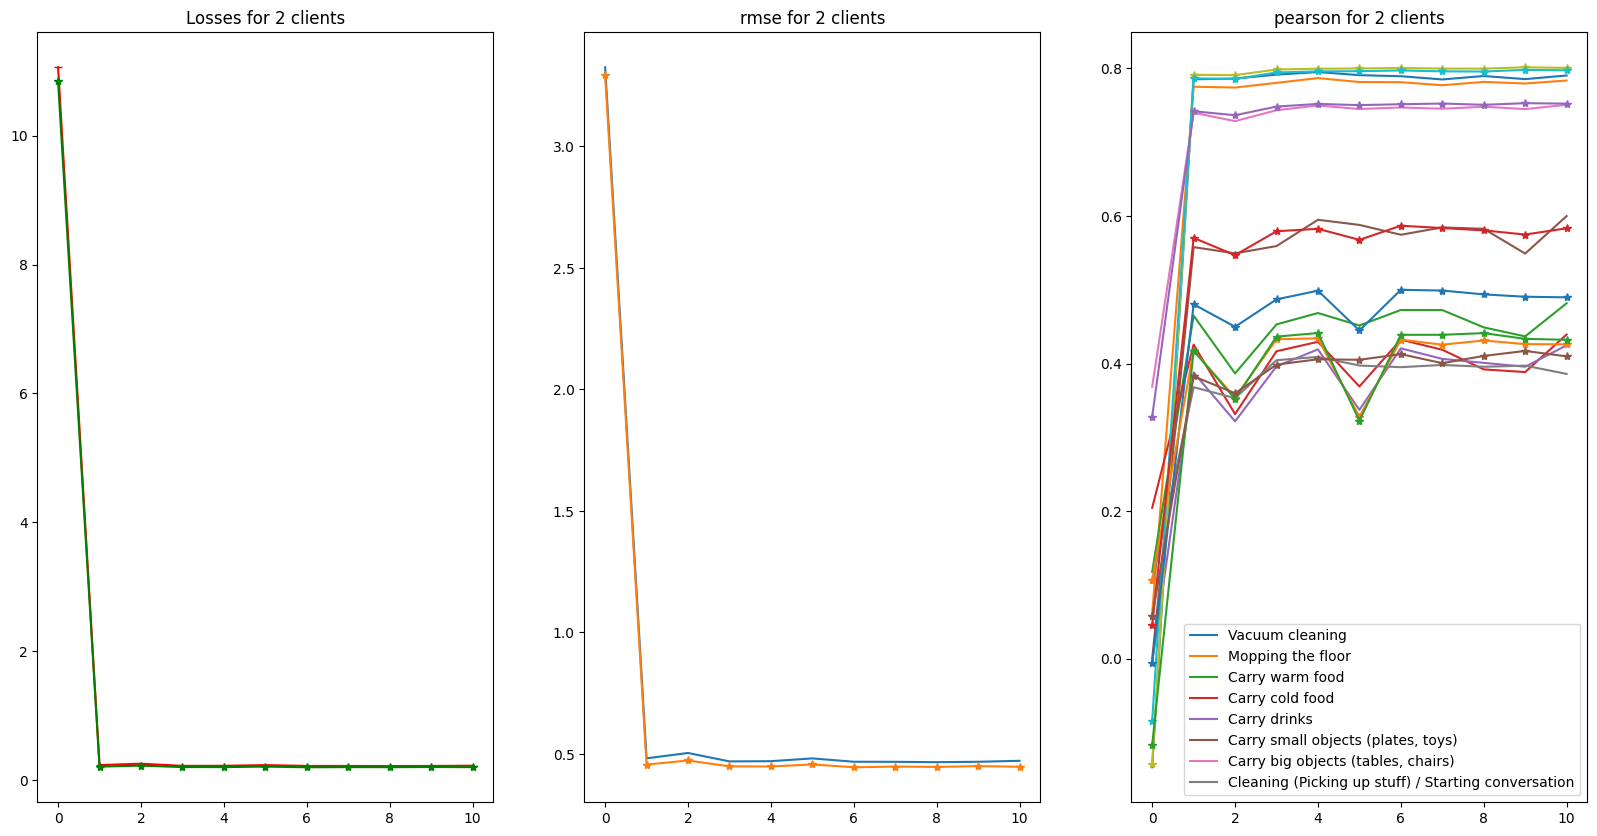

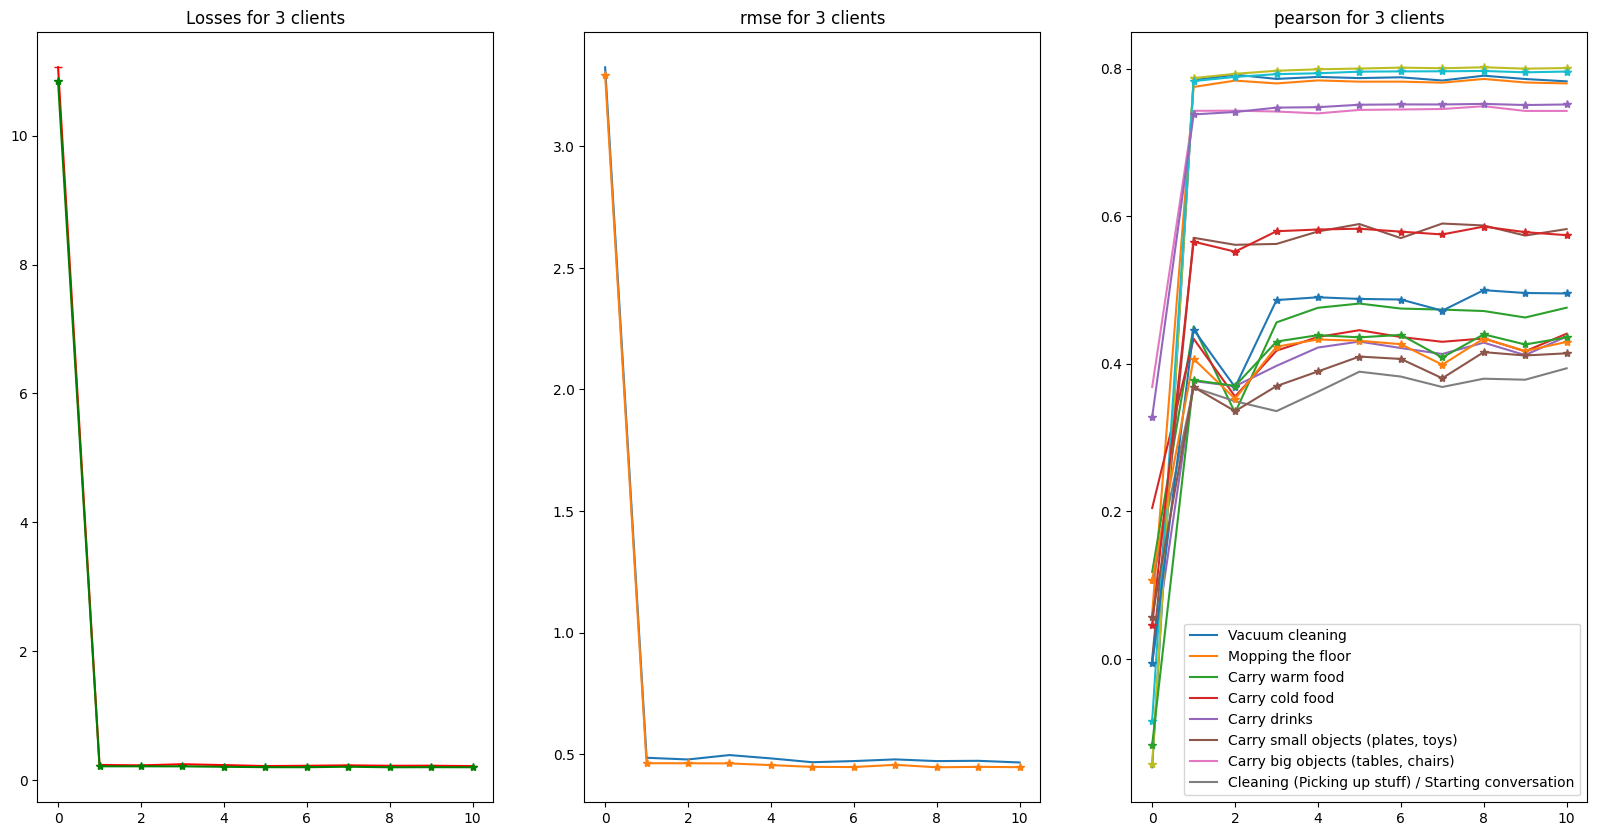

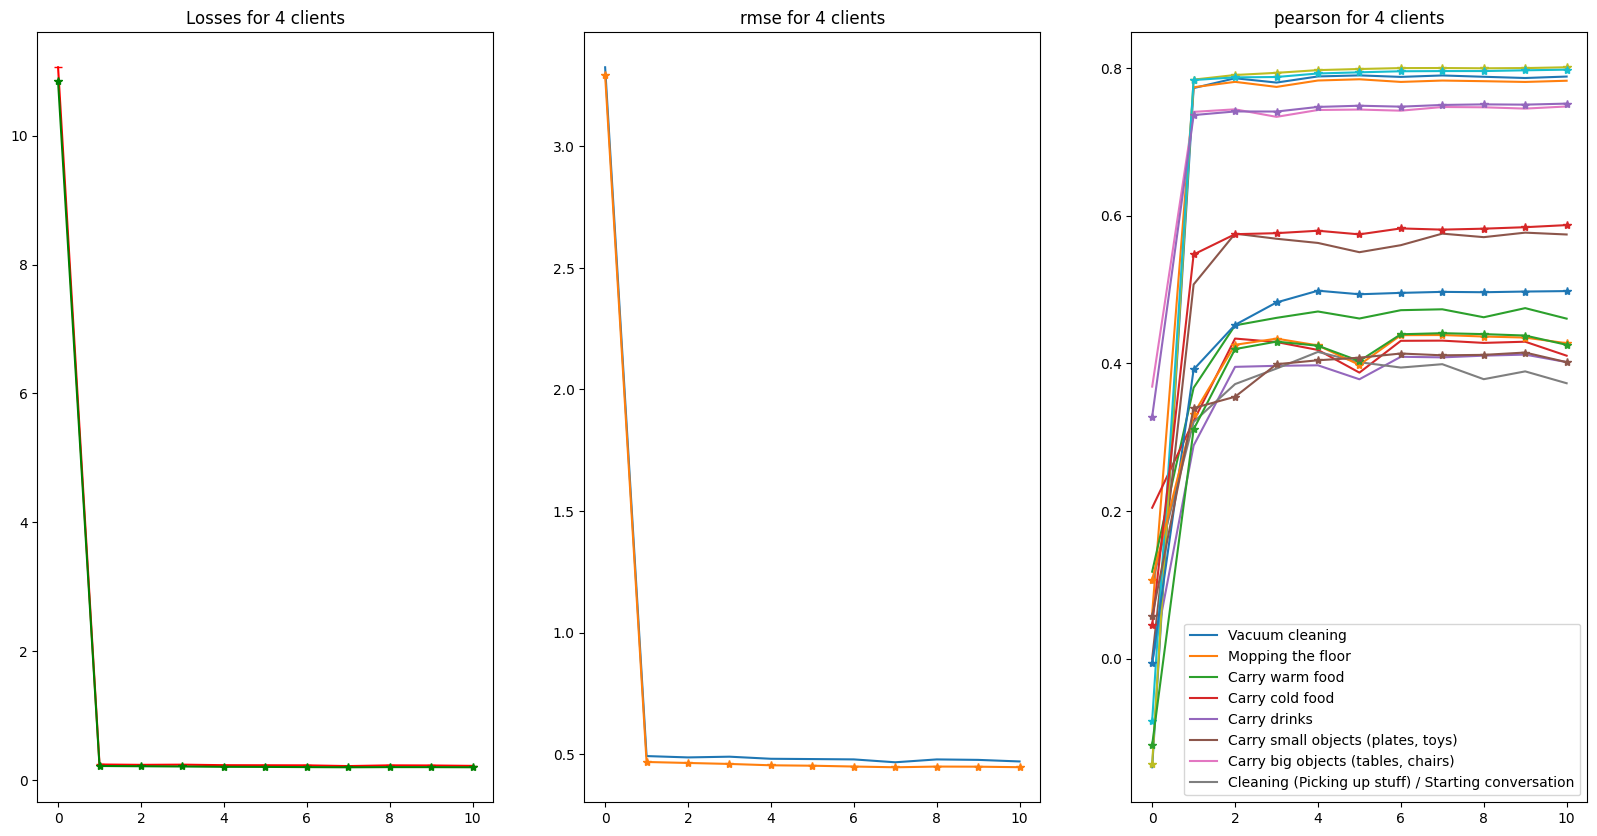

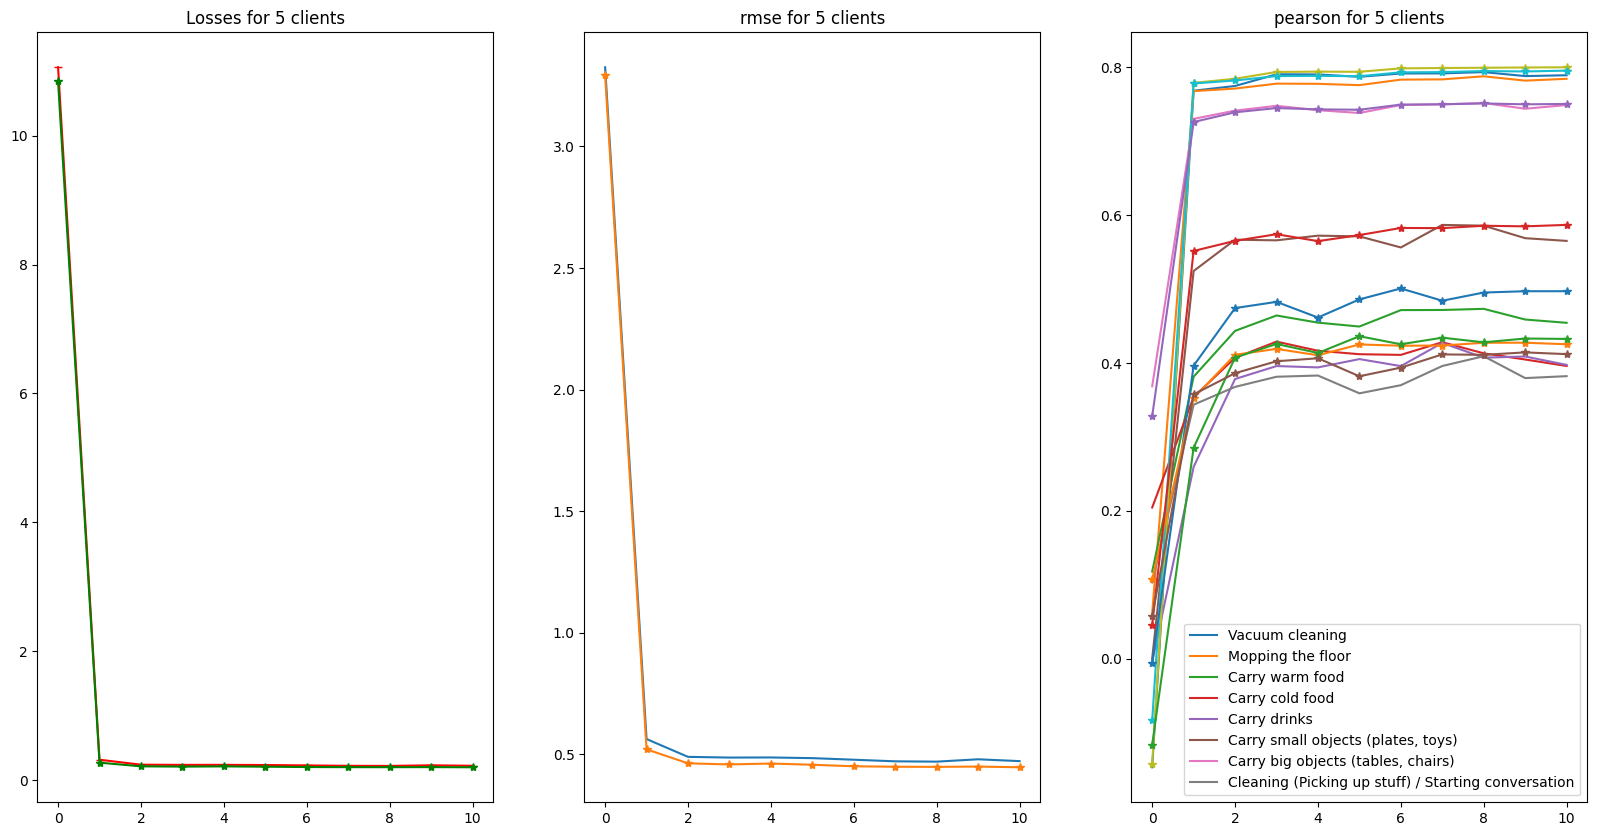

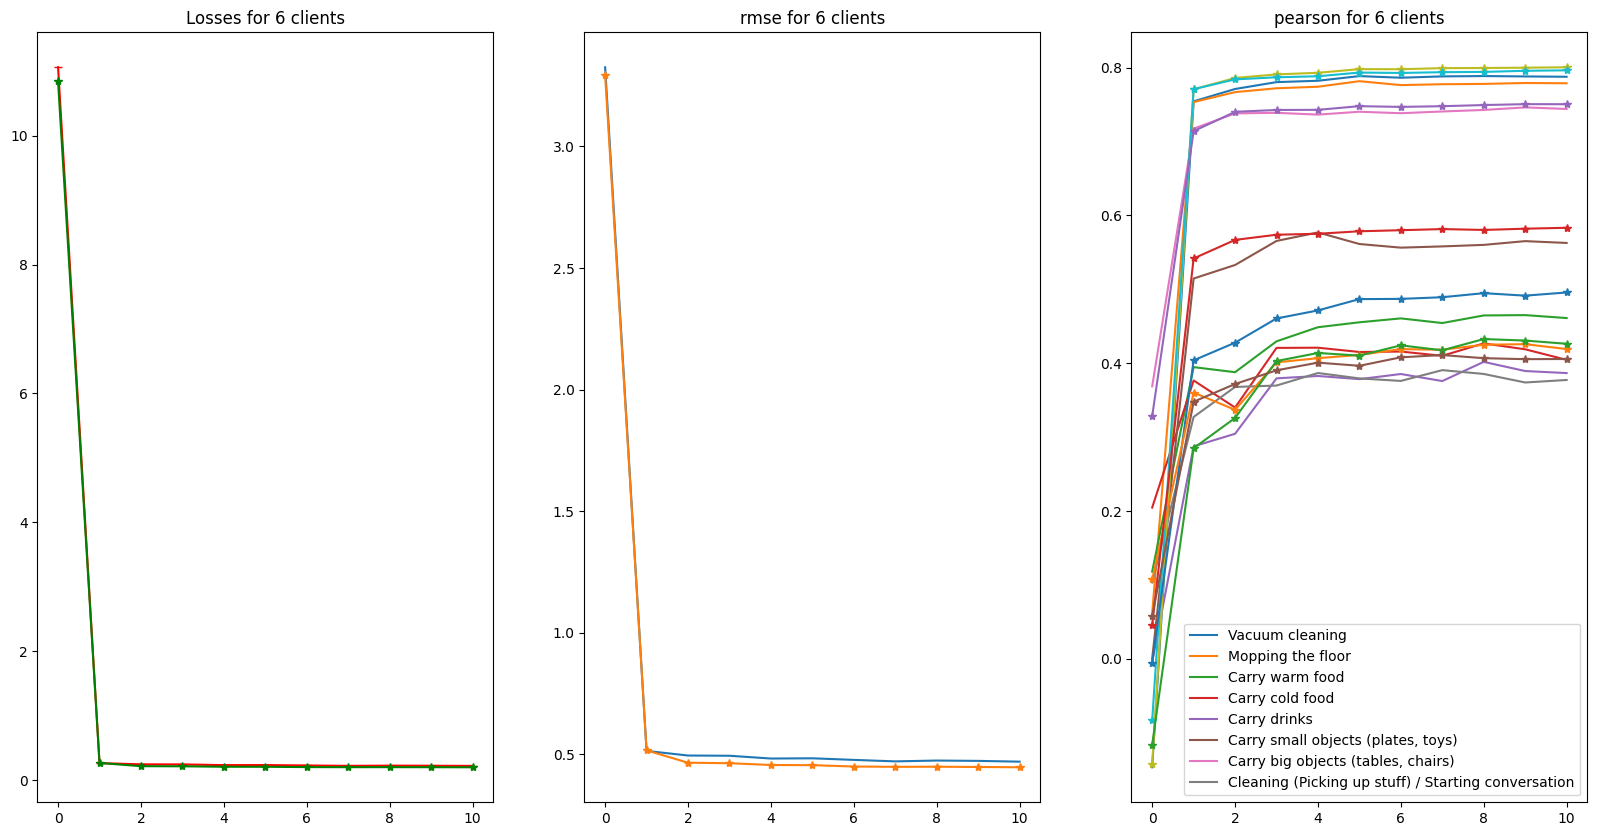

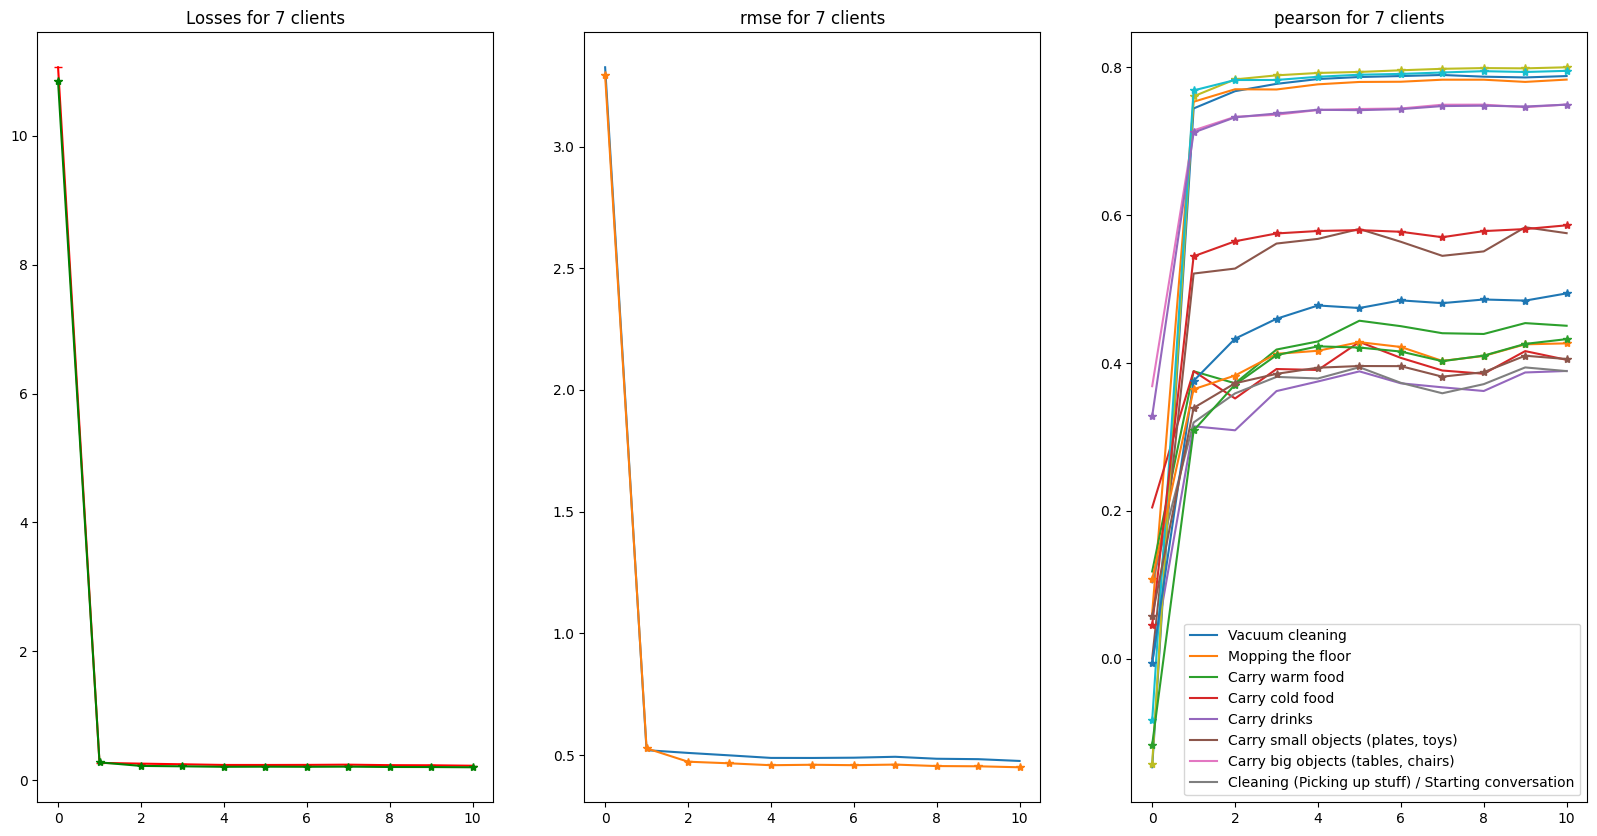

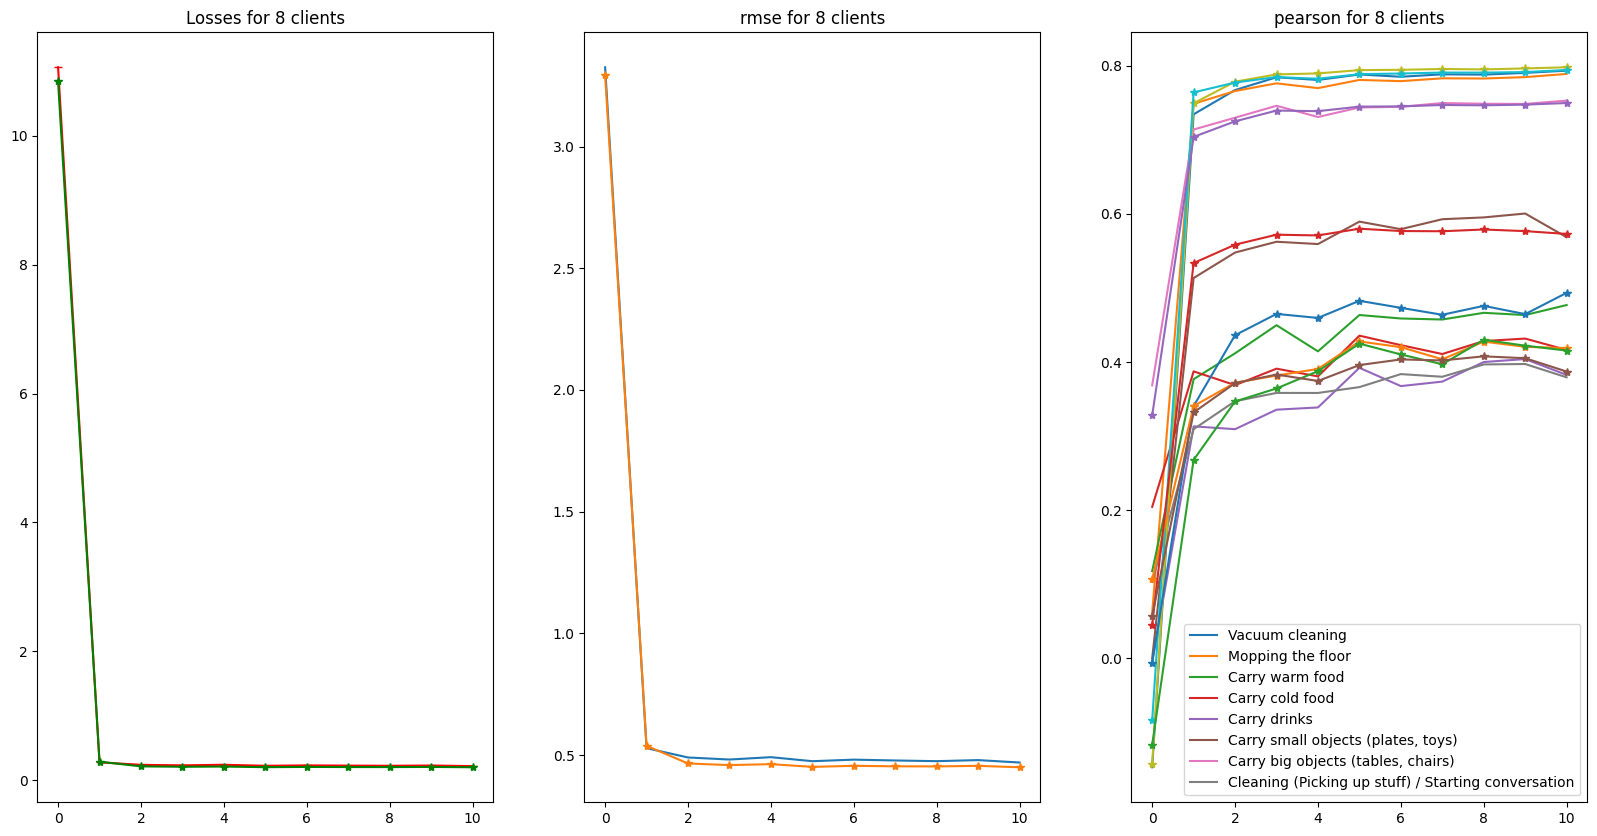

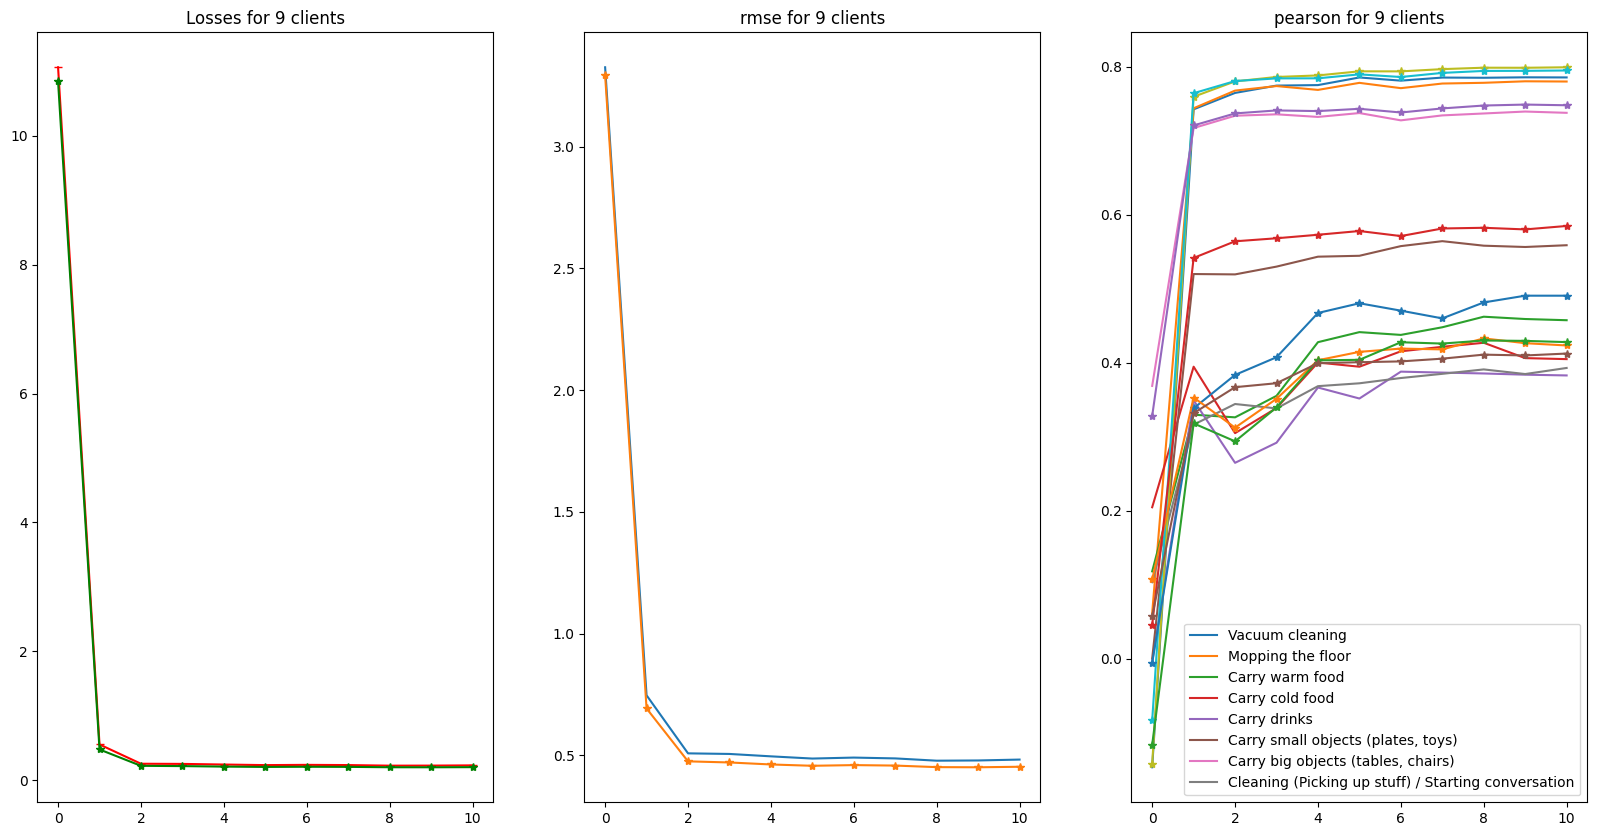

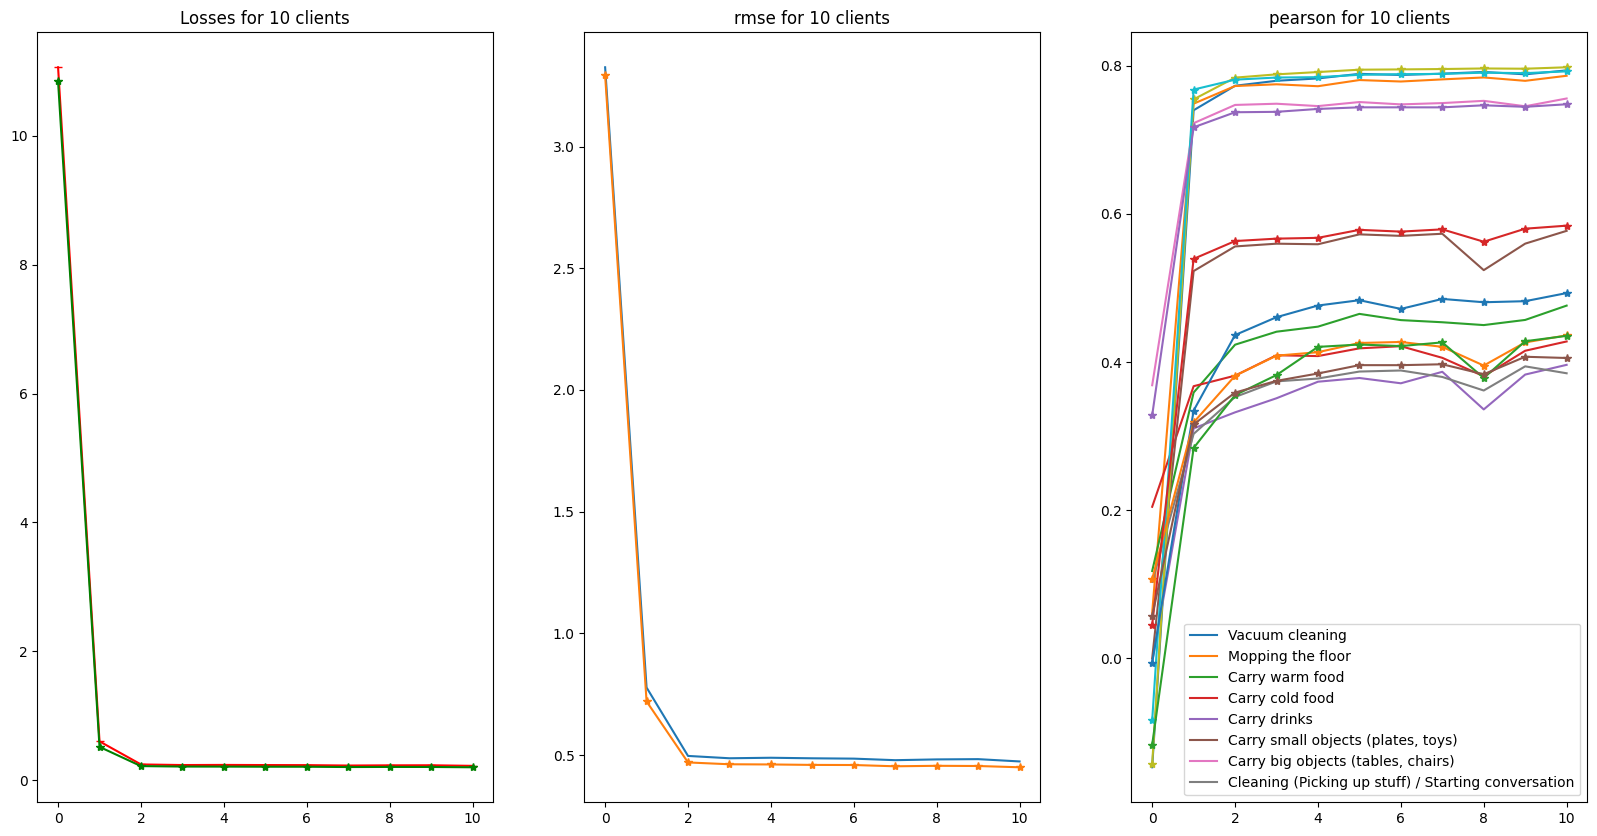

In [26]:
#for each client, plot losses, rmse in separate graphs and pearson of each label in a single graph with all labels marked in the legend
import matplotlib.pyplot as plt
for i in range(len(results)):
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    plt.plot(results[i]['Losses'], marker='_', color='red')
    plt.title("Losses for "+str(results[i]['clients'])+" clients")
    # plt.figure(figsize=(10,5))
    plt.plot(results_train[i]['Losses'],marker='*', color='green')
    plt.subplot(1,3,2)
    plt.plot(results[i]['rmse'])
    plt.plot(results_train[i]['rmse'], marker='*')

    plt.title("rmse for "+str(results[i]['clients'])+" clients")
    plt.subplot(1,3,3)
    for j in range(len(y_labels)):
        plt.plot(results[i]['pearson'][y_labels[j]])
    for j in range(len(y_labels)):
        plt.plot(results_train[i]['pearson'][y_labels[j]],marker='*')
    plt.title("pearson for "+str(results[i]['clients'])+" clients")
    plt.legend(y_labels)
    plt.savefig(f"{path}/{i+2}/{strat}.png")


In [27]:
import json
for i in range(len(results)):
    with open(f"{path}/{i+2}/{strat}/"+str(results[i]['clients'])+"clients.json", "w") as outfile:
        json.dump(results[i], outfile)


In [28]:
#load the results from the path "/results/fedAvgN" and create a dataframe with losses, rmse and average pearson of every label for each client
import json
import os
results=[]
for i in range(2,11):
    with open(f"{path}/{i}/{strat}/"+str(i)+"clients.json") as json_file:
        results.append(json.load(json_file))
import pandas as pd
df=pd.DataFrame(results)
df.head()

,clients,Losses,rmse,pearson
0,2,"[11.060606956481934, 0.23246178030967712, 0.25...","[3.325749158859253, 0.4821428954601288, 0.5040...","{'Vacuum cleaning': [-0.1468226751843182, 0.78..."
1,3,"[11.060606956481934, 0.23495566844940186, 0.22...","[3.325749158859253, 0.4847222566604614, 0.4777...","{'Vacuum cleaning': [-0.1468226751843182, 0.78..."
2,4,"[11.060606956481934, 0.24183045327663422, 0.23...","[3.325749158859253, 0.49176260828971863, 0.486...","{'Vacuum cleaning': [-0.1468226751843182, 0.77..."
3,5,"[11.060606956481934, 0.3168262243270874, 0.239...","[3.325749158859253, 0.5628731846809387, 0.4897...","{'Vacuum cleaning': [-0.1468226751843182, 0.76..."
4,6,"[11.060606956481934, 0.264128714799881, 0.2449...","[3.325749158859253, 0.5139345526695251, 0.4949...","{'Vacuum cleaning': [-0.1468226751843182, 0.75..."


In [29]:
df=pd.DataFrame(results)


In [30]:
#add a new column named pearson_avg
df['pearson_avg']=[[] for i in range(len(df))]


In [31]:
df.head()

,clients,Losses,rmse,pearson,pearson_avg
0,2,"[11.060606956481934, 0.23246178030967712, 0.25...","[3.325749158859253, 0.4821428954601288, 0.5040...","{'Vacuum cleaning': [-0.1468226751843182, 0.78...",[]
1,3,"[11.060606956481934, 0.23495566844940186, 0.22...","[3.325749158859253, 0.4847222566604614, 0.4777...","{'Vacuum cleaning': [-0.1468226751843182, 0.78...",[]
2,4,"[11.060606956481934, 0.24183045327663422, 0.23...","[3.325749158859253, 0.49176260828971863, 0.486...","{'Vacuum cleaning': [-0.1468226751843182, 0.77...",[]
3,5,"[11.060606956481934, 0.3168262243270874, 0.239...","[3.325749158859253, 0.5628731846809387, 0.4897...","{'Vacuum cleaning': [-0.1468226751843182, 0.76...",[]
4,6,"[11.060606956481934, 0.264128714799881, 0.2449...","[3.325749158859253, 0.5139345526695251, 0.4949...","{'Vacuum cleaning': [-0.1468226751843182, 0.75...",[]


In [32]:
y_labels=list(df['pearson'][0].keys())

for i in range(df.shape[0]):
    li=[]
    for k in range(10):
        sum=0
        for j in range(len(y_labels)):
            sum=sum+df['pearson'][i][y_labels[j]][k]
        sum=sum/10
        li.append(sum)
    df['pearson_avg'][i]=li



/tmp/ipykernel_7120/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_7120/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_7120/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=li
/tmp/ipykernel_7120/1854403552.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [33]:
for i in range(df.shape[0]):
  # mini=min(df['Losses'][i])
  # idx=df['Losses'][i].index(mini)
  # print(idx)
  idx=-1
  df['Losses'][i]=df['Losses'][i][idx]
  df['rmse'][i]=df['rmse'][i][idx]
  df['pearson_avg'][i]=df['pearson_avg'][i][idx]


/tmp/ipykernel_7120/3851578825.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Losses'][i]=df['Losses'][i][idx]
/tmp/ipykernel_7120/3851578825.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rmse'][i]=df['rmse'][i][idx]
/tmp/ipykernel_7120/3851578825.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pearson_avg'][i]=df['pearson_avg'][i][idx]
/tmp/ipykernel_7120/3851578825.py:6: SettingWithCopyWarning: 
A value is 

In [34]:
df

,clients,Losses,rmse,pearson,pearson_avg
0,2,0.222724,0.471937,"{'Vacuum cleaning': [-0.1468226751843182, 0.78...",0.447772
1,3,0.216617,0.465421,"{'Vacuum cleaning': [-0.1468226751843182, 0.78...",0.45554
2,4,0.220514,0.469589,"{'Vacuum cleaning': [-0.1468226751843182, 0.77...",0.459568
3,5,0.222965,0.472192,"{'Vacuum cleaning': [-0.1468226751843182, 0.76...",0.4536
4,6,0.220602,0.469683,"{'Vacuum cleaning': [-0.1468226751843182, 0.75...",0.452544
5,7,0.225972,0.475365,"{'Vacuum cleaning': [-0.1468226751843182, 0.74...",0.454739
6,8,0.219916,0.468952,"{'Vacuum cleaning': [-0.1468226751843182, 0.73...",0.462071
7,9,0.232703,0.482393,"{'Vacuum cleaning': [-0.1468226751843182, 0.74...",0.4496
8,10,0.224097,0.473389,"{'Vacuum cleaning': [-0.1468226751843182, 0.73...",0.452151


In [35]:
df.drop(['pearson'], axis=1, inplace=True)

In [36]:
for i in range(df.shape[0]):
  try:
    data=pd.read_csv(f"{path}/clients{i+2}.csv")
    data.drop(["Unnamed: 0"], axis=1, inplace=True)
  except:
    data=pd.DataFrame(columns=["methods", "Loss", "RMSE", "PCC"])
  # data=data.append(pd.Series(["FedAvg_NoAug",df['Losses'][i],df['rmse'][i],df['pearson_avg'][i]]), ignore_index=True)
  data=pd.concat([data,pd.Series([f"{strat}",df['Losses'][i],df['rmse'][i],df['pearson_avg'][i]] , index=data.columns ).to_frame().T])
  data.to_csv(f"{path}/clients{i+2}.csv")

